In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psrchive as psr
import os
import sys
%matplotlib notebook
from scipy import stats
import bilby

We perform following steps to get data ready for use
1. check whether time delay duw to new DM is significantly different than the DM installed? If yes change the DM to new DM then...
2. Tscrunch, pscrunch, de-disperse and centre align the profiles
3. Subtract the baseline by subtracting the mean from the off pulse region

In [2]:
#telescope='Parkes'
telescope='MeerKAT'
if telescope=='Parkes':
    os.chdir("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_UWL_01Aug_22/Processed/phase_shifted")#/32PulInt")
if telescope=='MeerKAT':
    os.chdir("/fred/oz005/users/akulkarn/J0437-4715/J0437-4715_meerkat_19May_22/Processed/Frequency_Appended_all_withK/Corrected_DM")#/32pul_Integrated")

###Parkes UWL#####

#ar=psr.Archive_load("All_32p.ar")
ar=psr.Archive_load("SinglePulses_5000.ar")

#### The DM values obtained from TEMPO2 DM fits

if telescope=='Parkes':
    ar.set_dispersion_measure(2.64199904121215) 
if telescope=='MeerKAT':
    ar.set_dispersion_measure(2.64160768625521)


ar.dedisperse()
ar.pscrunch()
ar.tscrunch()
ar.centre_max_bin()
Freq=ar.get_frequencies()
P=0.00575

In [3]:
def subtract_baseline(datain):
    dim=datain.shape
    dataout=np.ndarray(dim)
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                dataout[subint,pol,freq,:]=datain[subint,pol,freq,:]-np.mean(datain[subint,pol,freq,0:100])
    return dataout

def apply_weights(datain,weights):
    dim=datain.shape
    dataout=np.ndarray(dim)
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                dataout[subint,pol,freq]=datain[subint,pol,freq]*weights[subint,freq]
    return dataout

########  This does not produce data with flat bandshape
data=ar.get_data()
weights=ar.get_weights()
Freq=ar.get_frequencies()

########## Removing Channels which are bad #####

count=0
list_remove_chn=[]
list_keep_chn=[]

if telescope=='Parkes':
    manually_flagged=[1,3,6,20,32,39,42,49,51,52,53,54,56,57,58,59,60,61,62,63]+[2,7,8]  ## Second list contains uneven noise floor
if telescope=='MeerKAT':
    manually_flagged=[1,15,26]+[2,7,8] ## Second list contains uneven floor channels

manually_flagged.sort()

for chn in range(weights.shape[1]):
    for obs in range(weights.shape[0]):
        if (weights[obs,chn]==0):
            count += 1
    if (count > (data.shape[0])/2 or (chn in manually_flagged)):
        list_remove_chn.append(chn)
    else:
        list_keep_chn.append(chn)
    count=0
#####################################################    
            

bandshape=np.mean(np.mean(data[:,0,:,0:100],axis=2),axis=0)
data=subtract_baseline(data)

data=np.delete(data,list_remove_chn,axis=2)
Freq=np.delete(Freq,list_remove_chn)
################### This produces data with flat bandshape
#data=ar.get_data()
#weights=ar.get_weights()
#data=subtract_baseline(data)
#data=apply_weights(data,weights)
#bandshape=np.mean(np.mean(data[:,0,:,0:100],axis=2),axis=0)

## Finding the peak of Component C1 and Main component

The peak of main component can be easily found using the np.max function as its peak will be maximum among all others.
In order to find the peak of component C1 we need to perform some operations

Getting the Peak for the component C1 ( the first left component to the main component of the pulse profile) To do this we find the derivative of the pulse profile and find the index with zero near the expected area.
But to do this first we try to minimize the noise in the profile by convolving the profile with a gaussian whose width is such that it preserves most of the profile features.

<IPython.core.display.Javascript object>


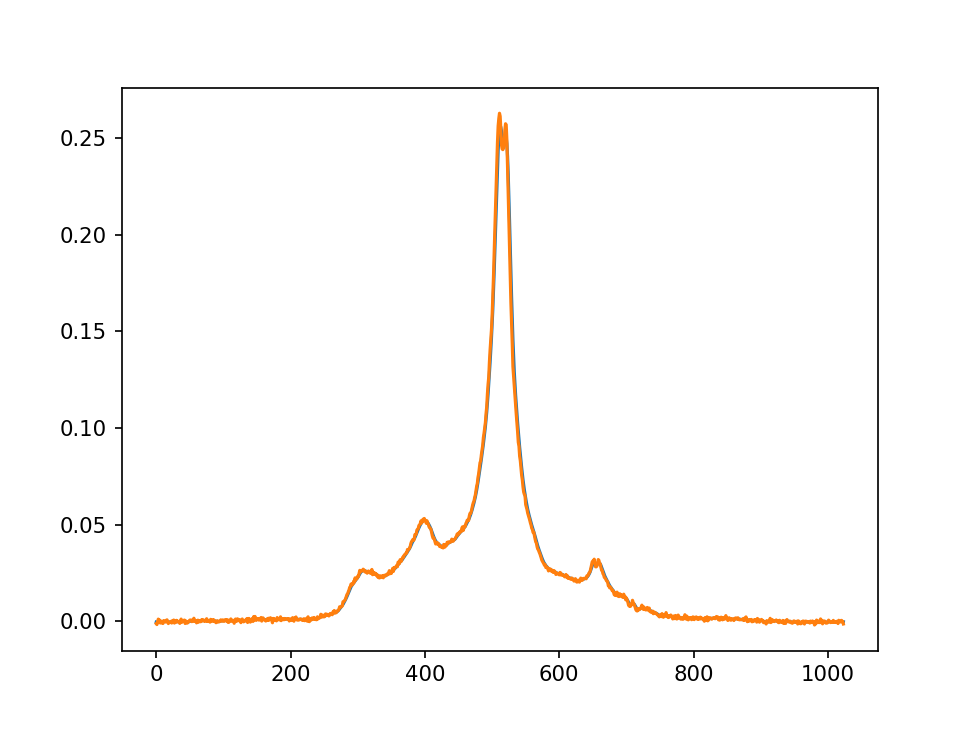

In [24]:
from scipy.signal import fftconvolve

def gaussian(x,mu_gs,sigma_gs):
    return np.exp((-1/2)*((x-mu_gs)/sigma_gs)**2)/(sigma_gs*np.sqrt(2*np.pi))
gauss=gaussian(np.arange(-30,30,1),0,2) ## Width of 2 seems to produce relaible convolved profile
smoothed=fftconvolve(prof,gauss,"same")

plt.figure()
plt.plot(smoothed)
plt.plot(np.mean(data[:,0,0,:],axis=0))

<IPython.core.display.Javascript object>


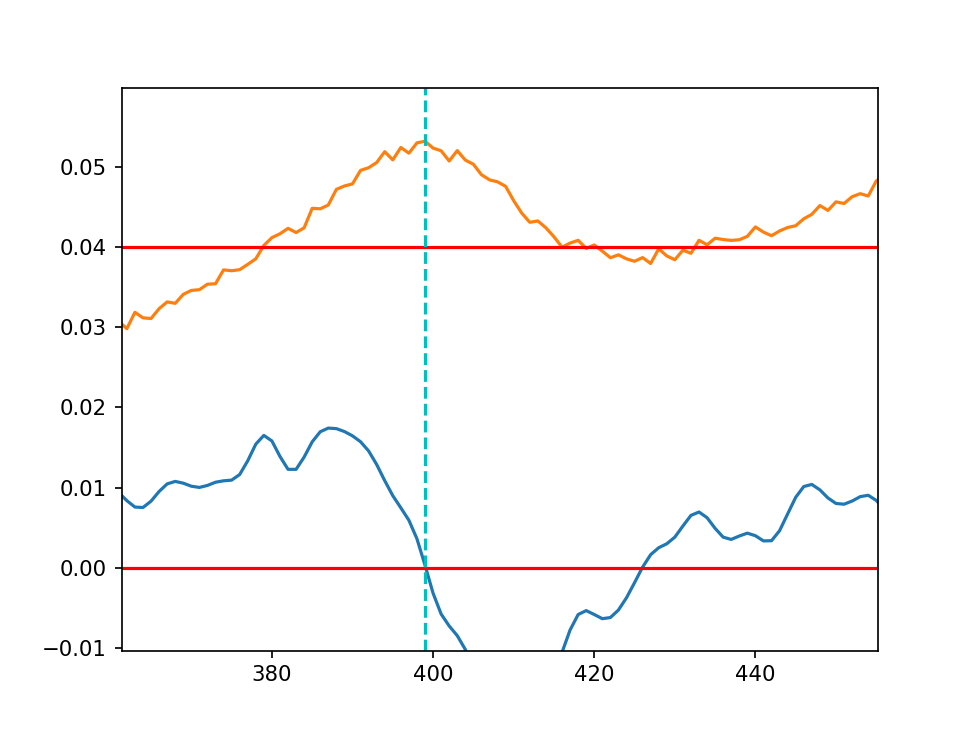

In [68]:
prof=np.mean(data[:,0,0,:],axis=0)
der=np.ndarray(prof.shape[0]-1) 

for bins in range(der.shape[0]):  #Taking the derivative of the pulse profile
    der[bins]=smoothed[bins+1]-smoothed[bins]
    
plt.figure()
plt.plot(20*(der))  # scaling for better visibility
plt.plot((prof))
#plt.axvline(x=512,color='r',ls='--')
plt.plot(np.zeros(der.shape[0]),color='r')
plt.plot(0.04*np.ones_like(der),color='r') ## A reference line to decide how much lower than the peak can be detetable
plt.axvline(x=399,color='c',ls='--')

In [46]:
np.where(np.isclose(der[380:420],0,atol=1e-4)==True)  # To find the position with respect to bin 380 where the value is appoximately zero

(array([19]),)

So the true peak of the C1 component is 380 + np.where(np.isclose(der[380:420],0,atol=1e-4)==True) 

# Frequency dependent Width of the pulsar

##### Defining $W_{50}$ and $W_{10}$

Here p is the period of the pulsar, and n is the width in "%" wrt the peak value in case of main peak and the peak value corresponding to C1 component in case of C1 component.

In [65]:
def get_nWidth(datain,n,p,comp="main"):
    dim=datain.shape
    width=np.ndarray([dim[0],dim[1],dim[2]])
    maxval=np.ndarray([dim[0],dim[1],dim[2]])
    lowindex=np.ndarray([dim[0],dim[1],dim[2]],dtype=int)
    highindex=np.ndarray([dim[0],dim[1],dim[2]],dtype=int)
    sigma_width=np.ndarray([dim[0],dim[1],dim[2]])
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                sigma=np.std(datain[subint,pol,freq,0:100])
                if (comp=="main"):
                    maxval[subint,pol,freq]=np.max(datain[subint,pol,freq])
                    maxarg=np.argmax(datain[subint,pol,freq])
                if (comp=="C1"):
                    maxval[subint,pol,freq]=np.max(datain[subint,pol,freq,360:430])
                    maxarg=360+np.argmax(datain[subint,pol,freq,360:430])
                low,high=None,None
                i=0
                while(low==None):
                    if(datain[subint,pol,freq,maxarg-i]<=n*maxval[subint,pol,freq]):
                        low=maxarg-i
                        dataprime=np.absolute(datain[subint,pol,freq,low+1]-datain[subint,pol,freq,low-1])/(2*P/dim[3])
                        low_err=np.sqrt((n*sigma/dataprime)**2+(1/12)*np.square(P/data.shape[3]))
                    else:
                        i=i+1
                i=0
                while(high==None):
                    if(datain[subint,pol,freq,maxarg+i]<=n*maxval[subint,pol,freq]):
                        high=maxarg+i
                        dataprime=np.absolute(datain[subint,pol,freq,high-1]-datain[subint,pol,freq,high+1])/(2*P/dim[3])
                        high_err=np.sqrt((n*sigma/dataprime)**2+(1/12)*np.square(P/data.shape[3]))
                    else:
                        i=i+1
                width[subint,pol,freq]=(p*(high-low))/dim[3]
                lowindex[subint,pol,freq]=int(low)
                highindex[subint,pol,freq]=int(high)
                sigma_width[subint,pol,freq]=P*(1/data.shape[3])*(high_err**2+low_err**2)
    return width,maxval,lowindex,highindex,sigma_width

[widthC1_90,maxvalC1_90,lowindexC1_90,highindexC1_90,sigmaC1_90]=get_nWidth(data,0.85,P,comp="C1") # Setting 90% of max val
[width_50,maxval_50,lowindex_50,highindex_50,sigma_50]=get_nWidth(data,0.5,P)
[width_10,maxval_10,lowindex_10,highindex_10,sigma_10]=get_nWidth(data,0.1,P)

Visualising the fixed window of 40 bins [390-439]

<IPython.core.display.Javascript object>


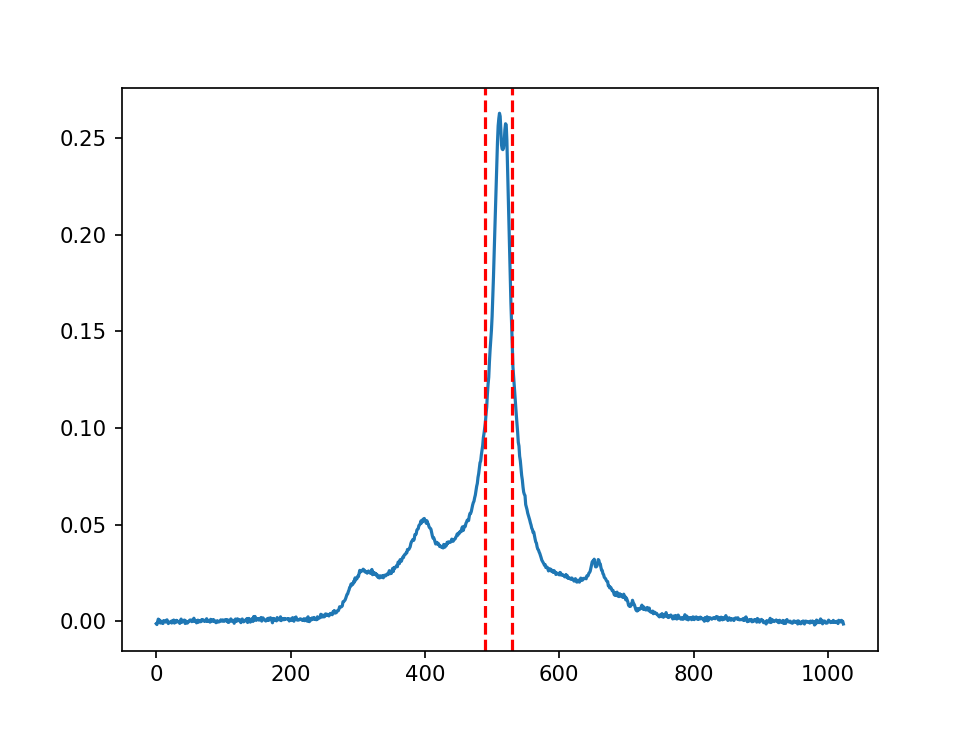

In [4]:
plt.figure()
plt.plot(np.mean(data[:,0,0,:],axis=0))
plt.axvline(x=490,color='r',ls='--')
plt.axvline(x=530,color='r',ls='--')

we find the effective width of the pulse profile calculated from low index and high index and then use it for calculating modeulation index 

$$W_{eff}(f)=\frac{\Delta\phi}{\sum_{i} (I(\phi_{i+1})-I(\phi_{i}))^2}$$

beacuse of presence of noise in the measurement, one needs to subtract $2n_{on}\sigma^2$ from the denominator to remove the effect of noise.
Here one can estimate $\sigma^2$ by taking sample standard deviation of off pulse region of length equal to $n_{on}$

In [ ]:
def get_effWidth(datain,lowindex,highindex,P):
    dim=datain.shape
    effwidth=np.ndarray([dim[0],dim[1],dim[2]])
    deltaphi=P/dim[3]
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                addition=0
                for count in range(int(highindex[subint,pol,freq]-lowindex[subint,pol,freq])):
                    addition+=np.square(datain[subint,pol,freq,int(lowindex[subint,pol,freq])+count+1]-datain[subint,pol,freq,int(lowindex[subint,pol,freq])+count])
                sigma_sq=np.var(datain[subint,pol,freq,0:int(highindex[subint,pol,freq]-lowindex[subint,pol,freq])])
                addition=addition-(2*(highindex[subint,pol,freq]-lowindex[subint,pol,freq])*sigma_sq)
                effwidth[subint,pol,freq]=np.divide(deltaphi,addition)
    return effwidth

effwidth_50=get_effWidth(data,lowindex_50,highindex_50,P)

Fitting Power law to intrinsic width using bilby

18:26 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bibly_results_PulseWidth/'
18:26 bilby INFO    : Search parameters:
18:26 bilby INFO    :   A = Uniform(minimum=0, maximum=10000, name='A', latex_label='A', unit=None, boundary=None)
18:26 bilby INFO    :   Alpha = Uniform(minimum=-10, maximum=10, name='Alpha', latex_label='Alpha', unit=None, boundary=None)
18:26 bilby INFO    :   B = Uniform(minimum=0, maximum=1, name='B', latex_label='B', unit=None, boundary=None)
18:26 bilby INFO    :   sigma = Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
18:26 bilby INFO    : Single likelihood evaluation took 8.691e-05 s


0it [00:00, ?it/s]

18:26 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f696418fdc0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
18:26 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:26 bilby INFO    : Using dynesty version 1.0.1
18:26 bilby INFO    : Using the bilby-implemented rw

<IPython.core.display.Javascript object>


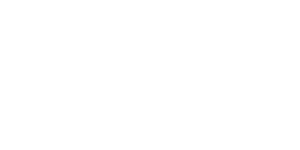

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


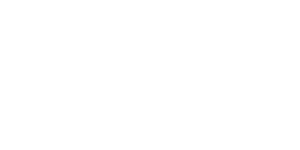

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


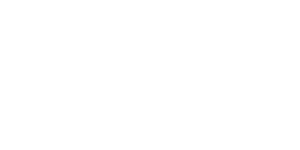

<IPython.core.display.Javascript object>


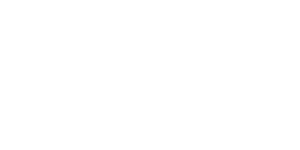

18:33 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_PulseWidth//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


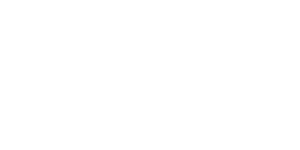

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


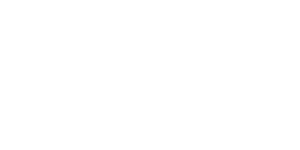

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


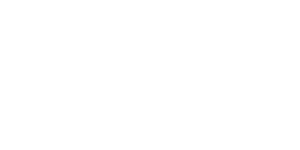

<IPython.core.display.Javascript object>


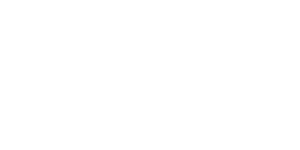

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
18:33 bilby INFO    : Sampling time: 0:06:26.814622
18:33 bilby INFO    : Summary of results:
nsamples: 14314
ln_noise_evidence:    nan
ln_evidence: 305.986 +/-  1.377
ln_bayes_factor:    nan +/-  1.377



In [9]:
import bilby

def func_respowerlawBLB(Freq,A,Alpha,B):
    model=A*(Freq**Alpha)+B
    return model

outdir = "/home/akulkarn/notebooks/bibly_results_PulseWidth/"
if telescope=='Parkes':
    #Freq_norm=Freq/2368
    Freq_norm=Freq/1280
if telescope=='MeerKAT':
    Freq_norm=Freq/1280
    Freq_norm=Freq/1000
#sigma=(np.sqrt(2)*P*(1/data.shape[3])*(np.sqrt(np.var(1.5*data[0,0,:,0:100],axis=1)+np.square(P/2048))))
#likelihood = bilby.likelihood.GaussianLikelihood(Freq_norm, width_50[0,0], func_respowerlawBLB)#, sigma)
#likelihood = bilby.likelihood.GaussianLikelihood(np.asarray(Freq_UWL[0:17]), np.asarray(width_50_UWL[0:17]), func_respowerlawBLB, np.asarray(sigma_uwl[0:17]))

priors = dict()
priors["A"] = bilby.core.prior.Uniform(0, 10000, "A")
priors["Alpha"] = bilby.core.prior.Uniform(-10, 10, "Alpha")
priors["B"] = bilby.core.prior.Uniform(0, 1, "B")
priors["sigma"]=bilby.core.prior.Uniform(0,1,"sigma")

result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )

<IPython.core.display.Javascript object>


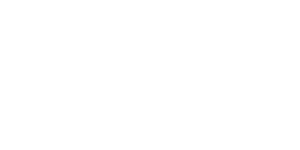

<IPython.core.display.Javascript object>


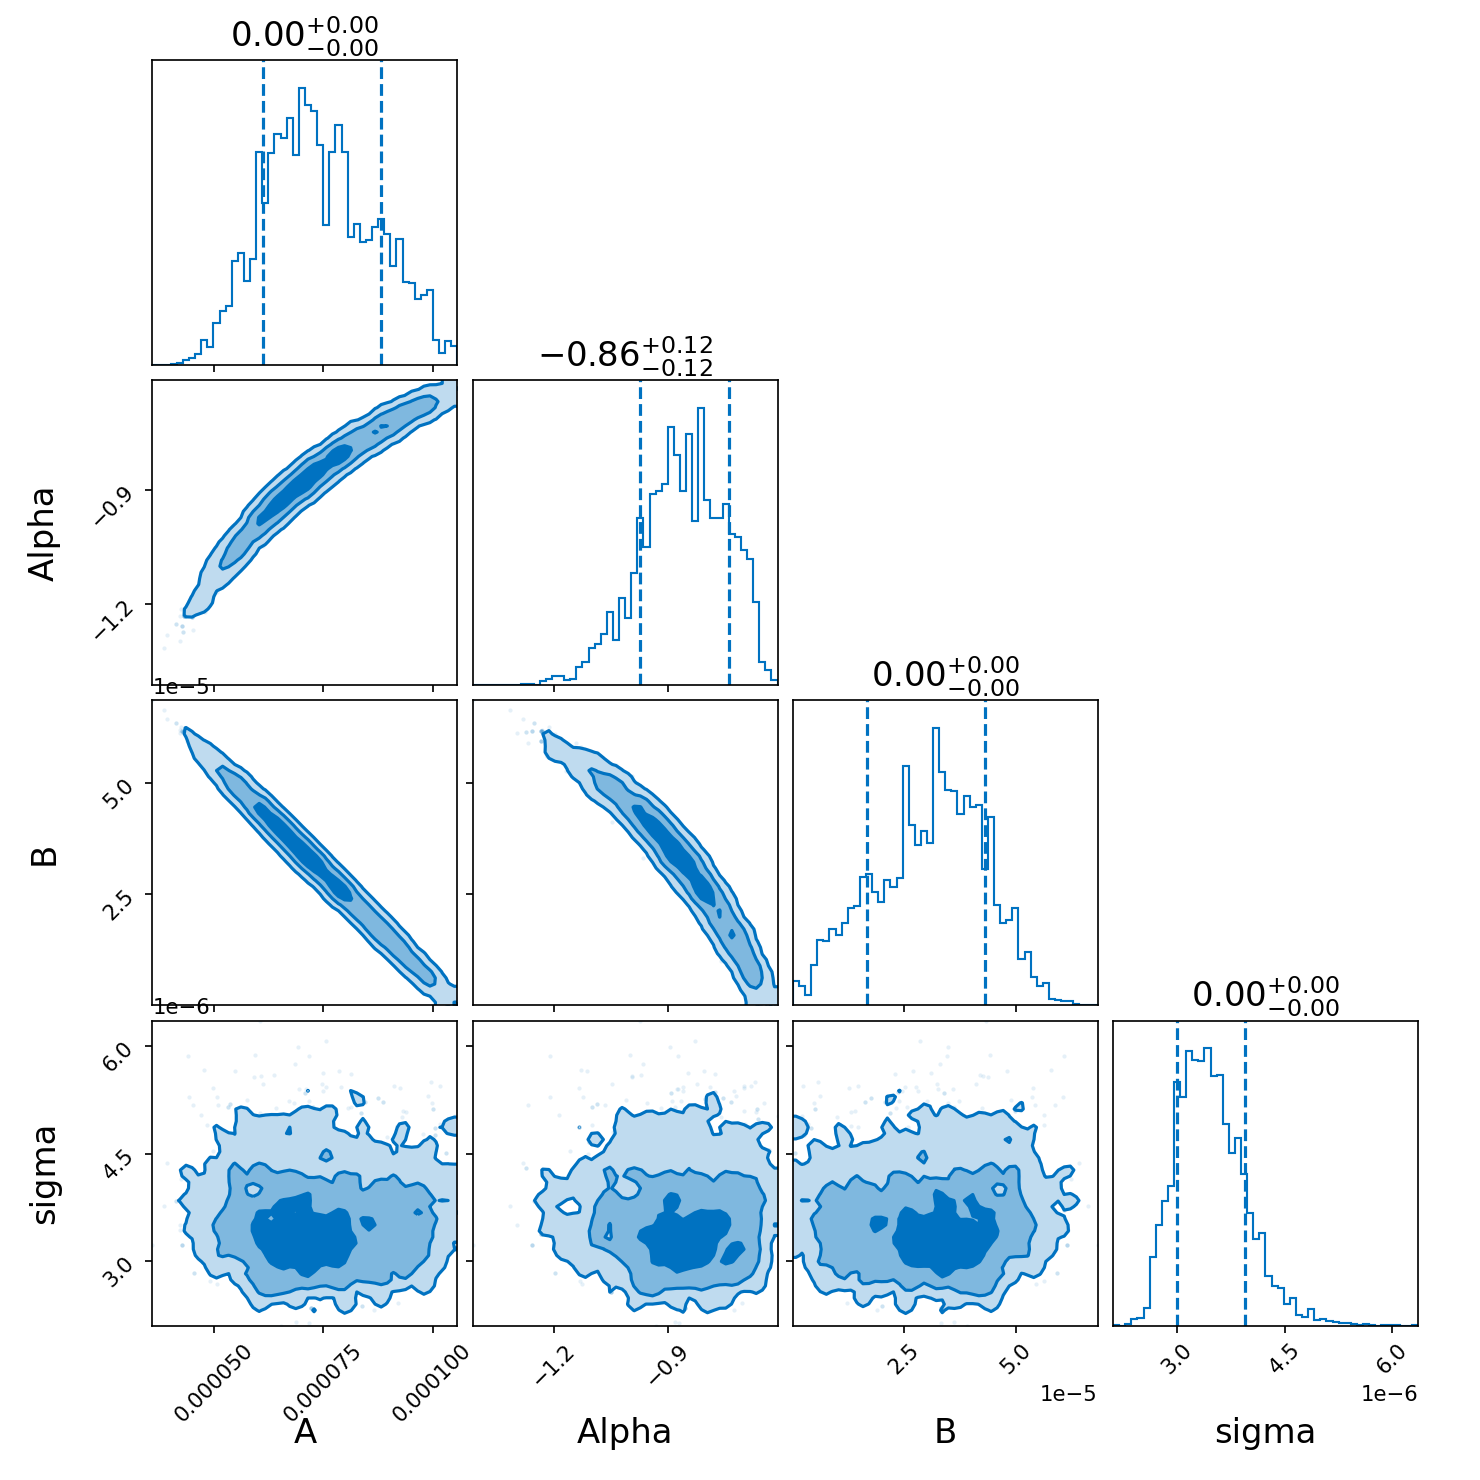

In [10]:
result.plot_corner()

In [44]:
if telescope=='Parkes':
    width_50_Parkes=width_50.copy()
    Freq_Parkes=Freq.copy()
if telescope=='MeerKAT':
    width_50_MeerKAT=width_50.copy()
    Freq_MeerKAT=Freq.copy()
    
Freq_comb=np.concatenate([Freq_MeerKAT,Freq_Parkes])
p=Freq_comb.argsort()
Freq_comb=Freq_comb[p]
width_50_comb=np.concatenate([width_50_MeerKAT[0,0],width_50_Parkes[0,0]])
width_50_comb=width_50_comb[p]

Fitting Powerlaw with bilby using combined data

12:24 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bibly_results_PulseWidth/Combined'
12:24 bilby INFO    : Search parameters:
12:24 bilby INFO    :   A = Uniform(minimum=0, maximum=100, name='A', latex_label='A', unit=None, boundary=None)
12:24 bilby INFO    :   Alpha = Uniform(minimum=-10, maximum=10, name='Alpha', latex_label='Alpha', unit=None, boundary=None)
12:24 bilby INFO    :   B = Uniform(minimum=0, maximum=1, name='B', latex_label='B', unit=None, boundary=None)
12:24 bilby INFO    :   sigma = Uniform(minimum=0, maximum=1, name='sigma', latex_label='sigma', unit=None, boundary=None)
12:24 bilby INFO    : Single likelihood evaluation took 8.098e-05 s


0it [00:00, ?it/s]

12:24 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0213a0ceb0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
12:24 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:24 bilby INFO    : Using dynesty version 1.0.1
12:24 bilby INFO    : Using the bilby-implemented rw

<IPython.core.display.Javascript object>


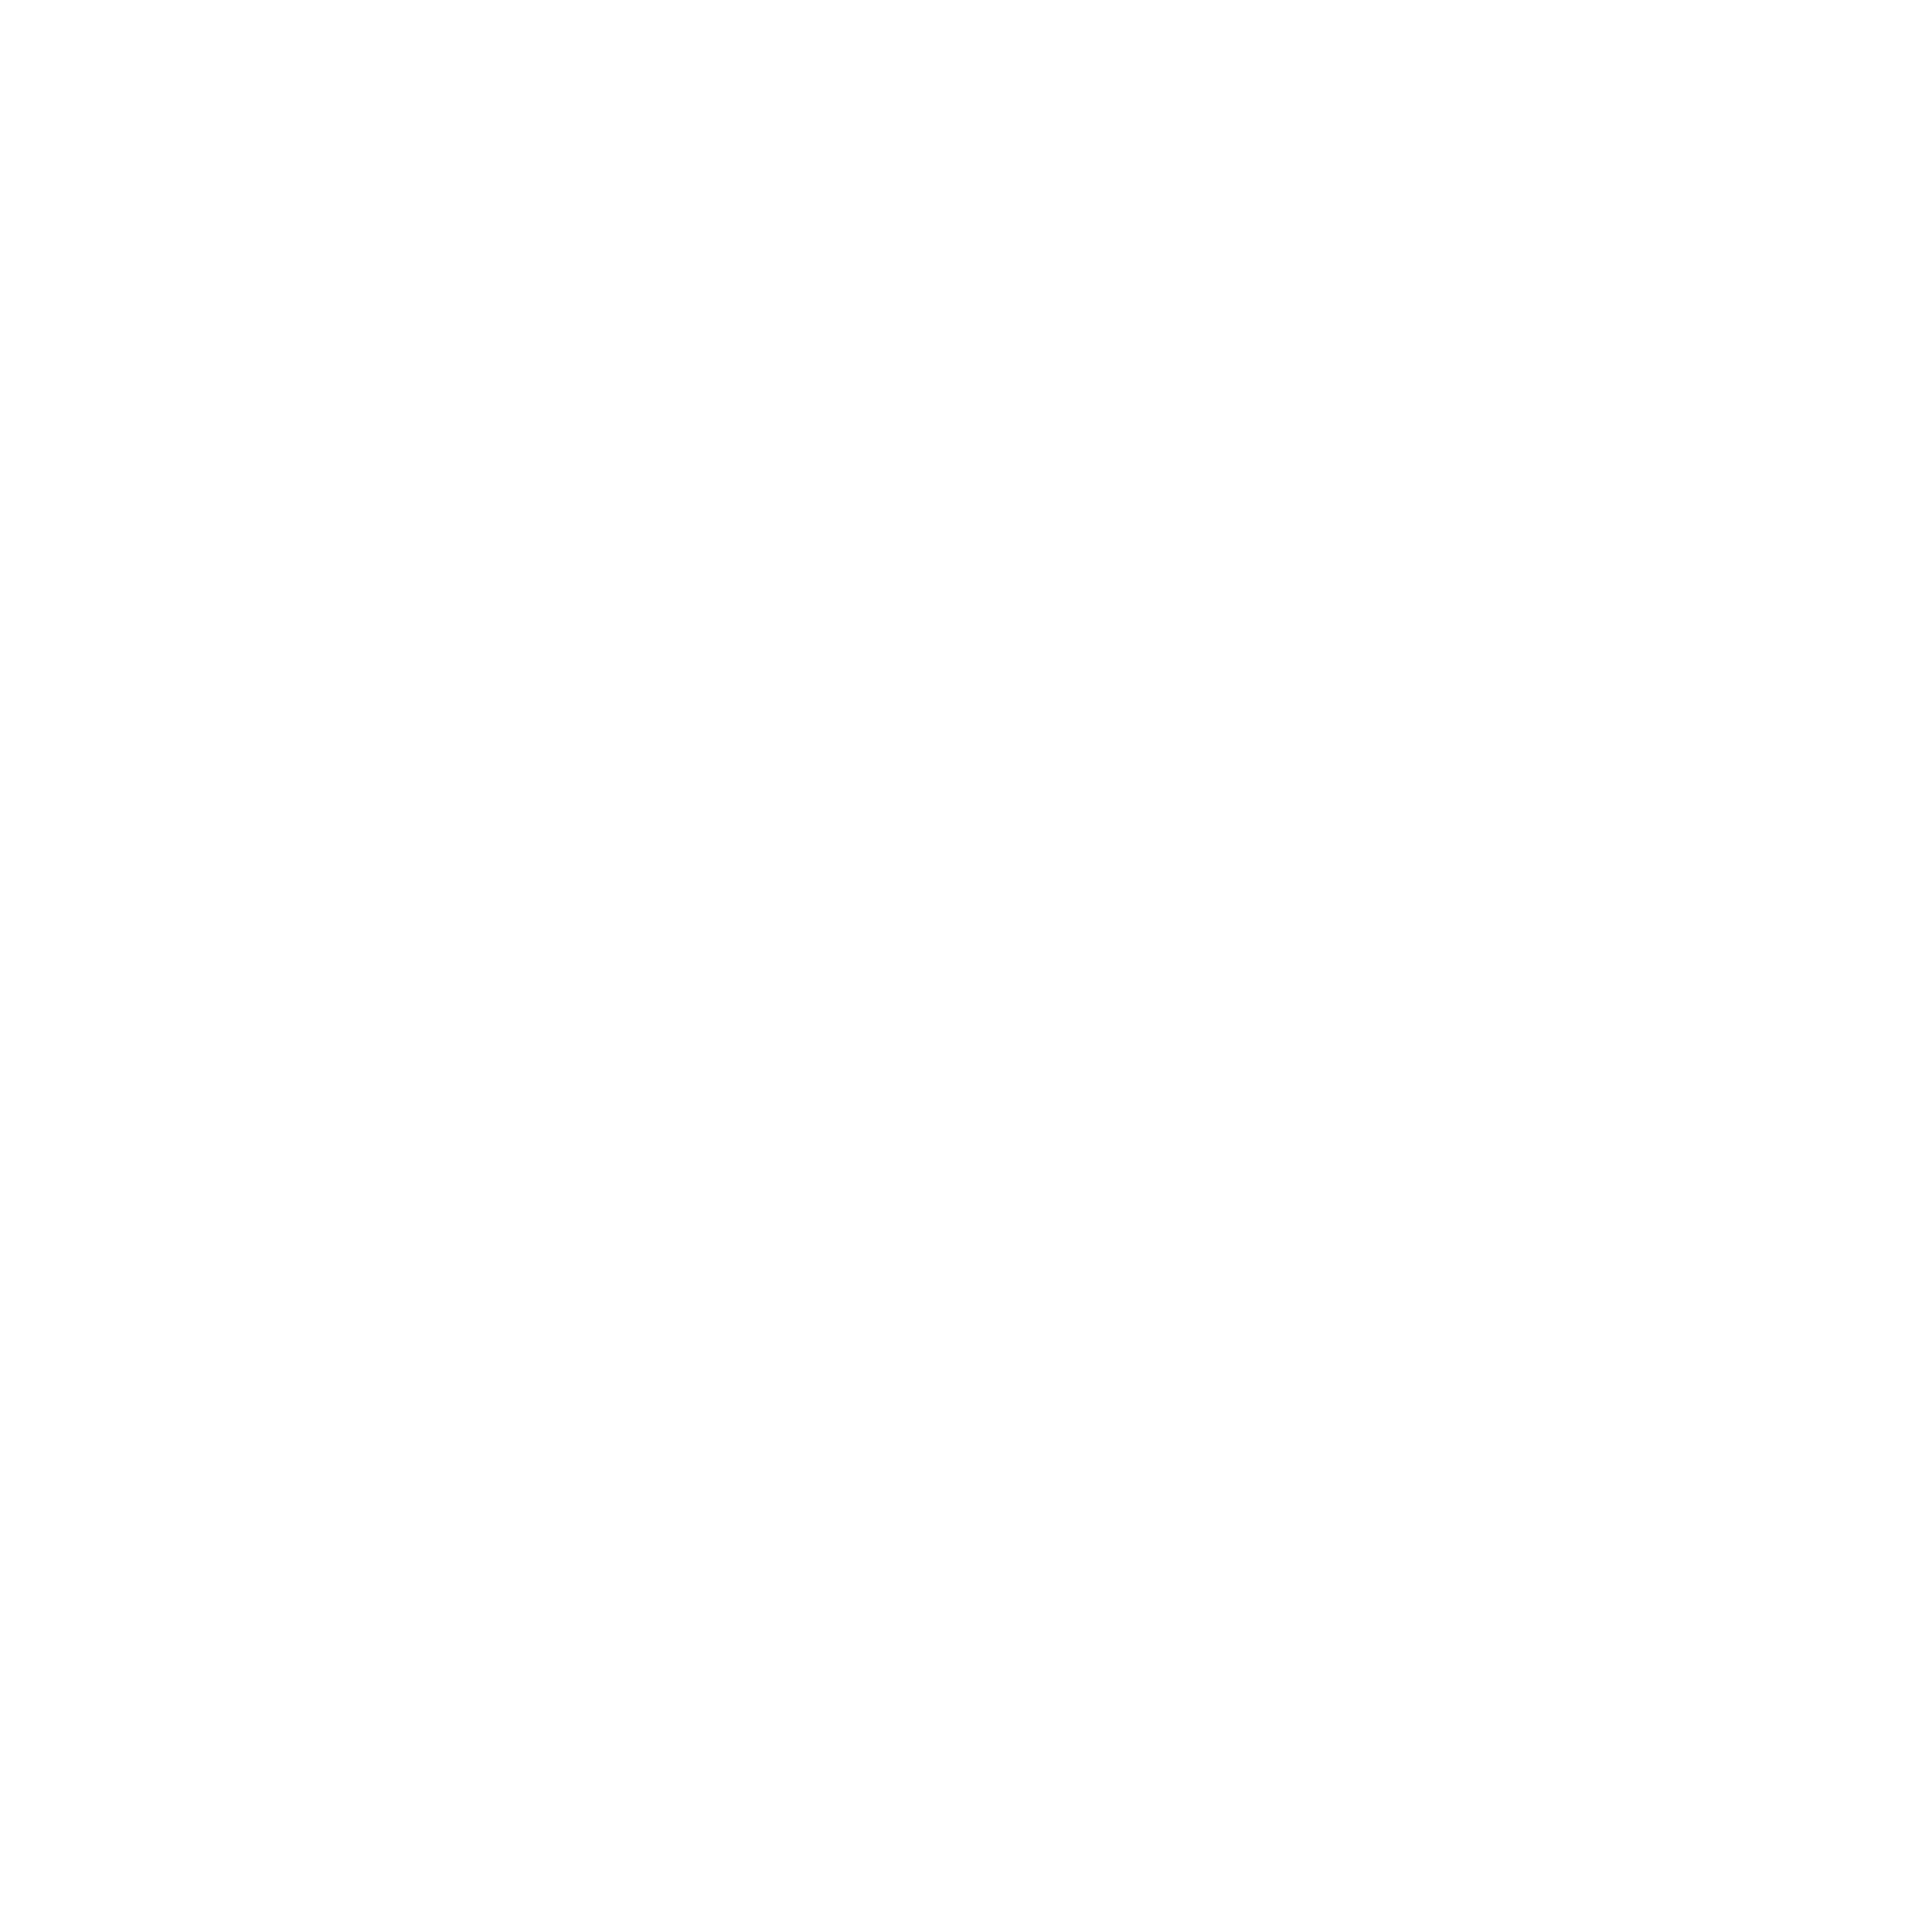

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


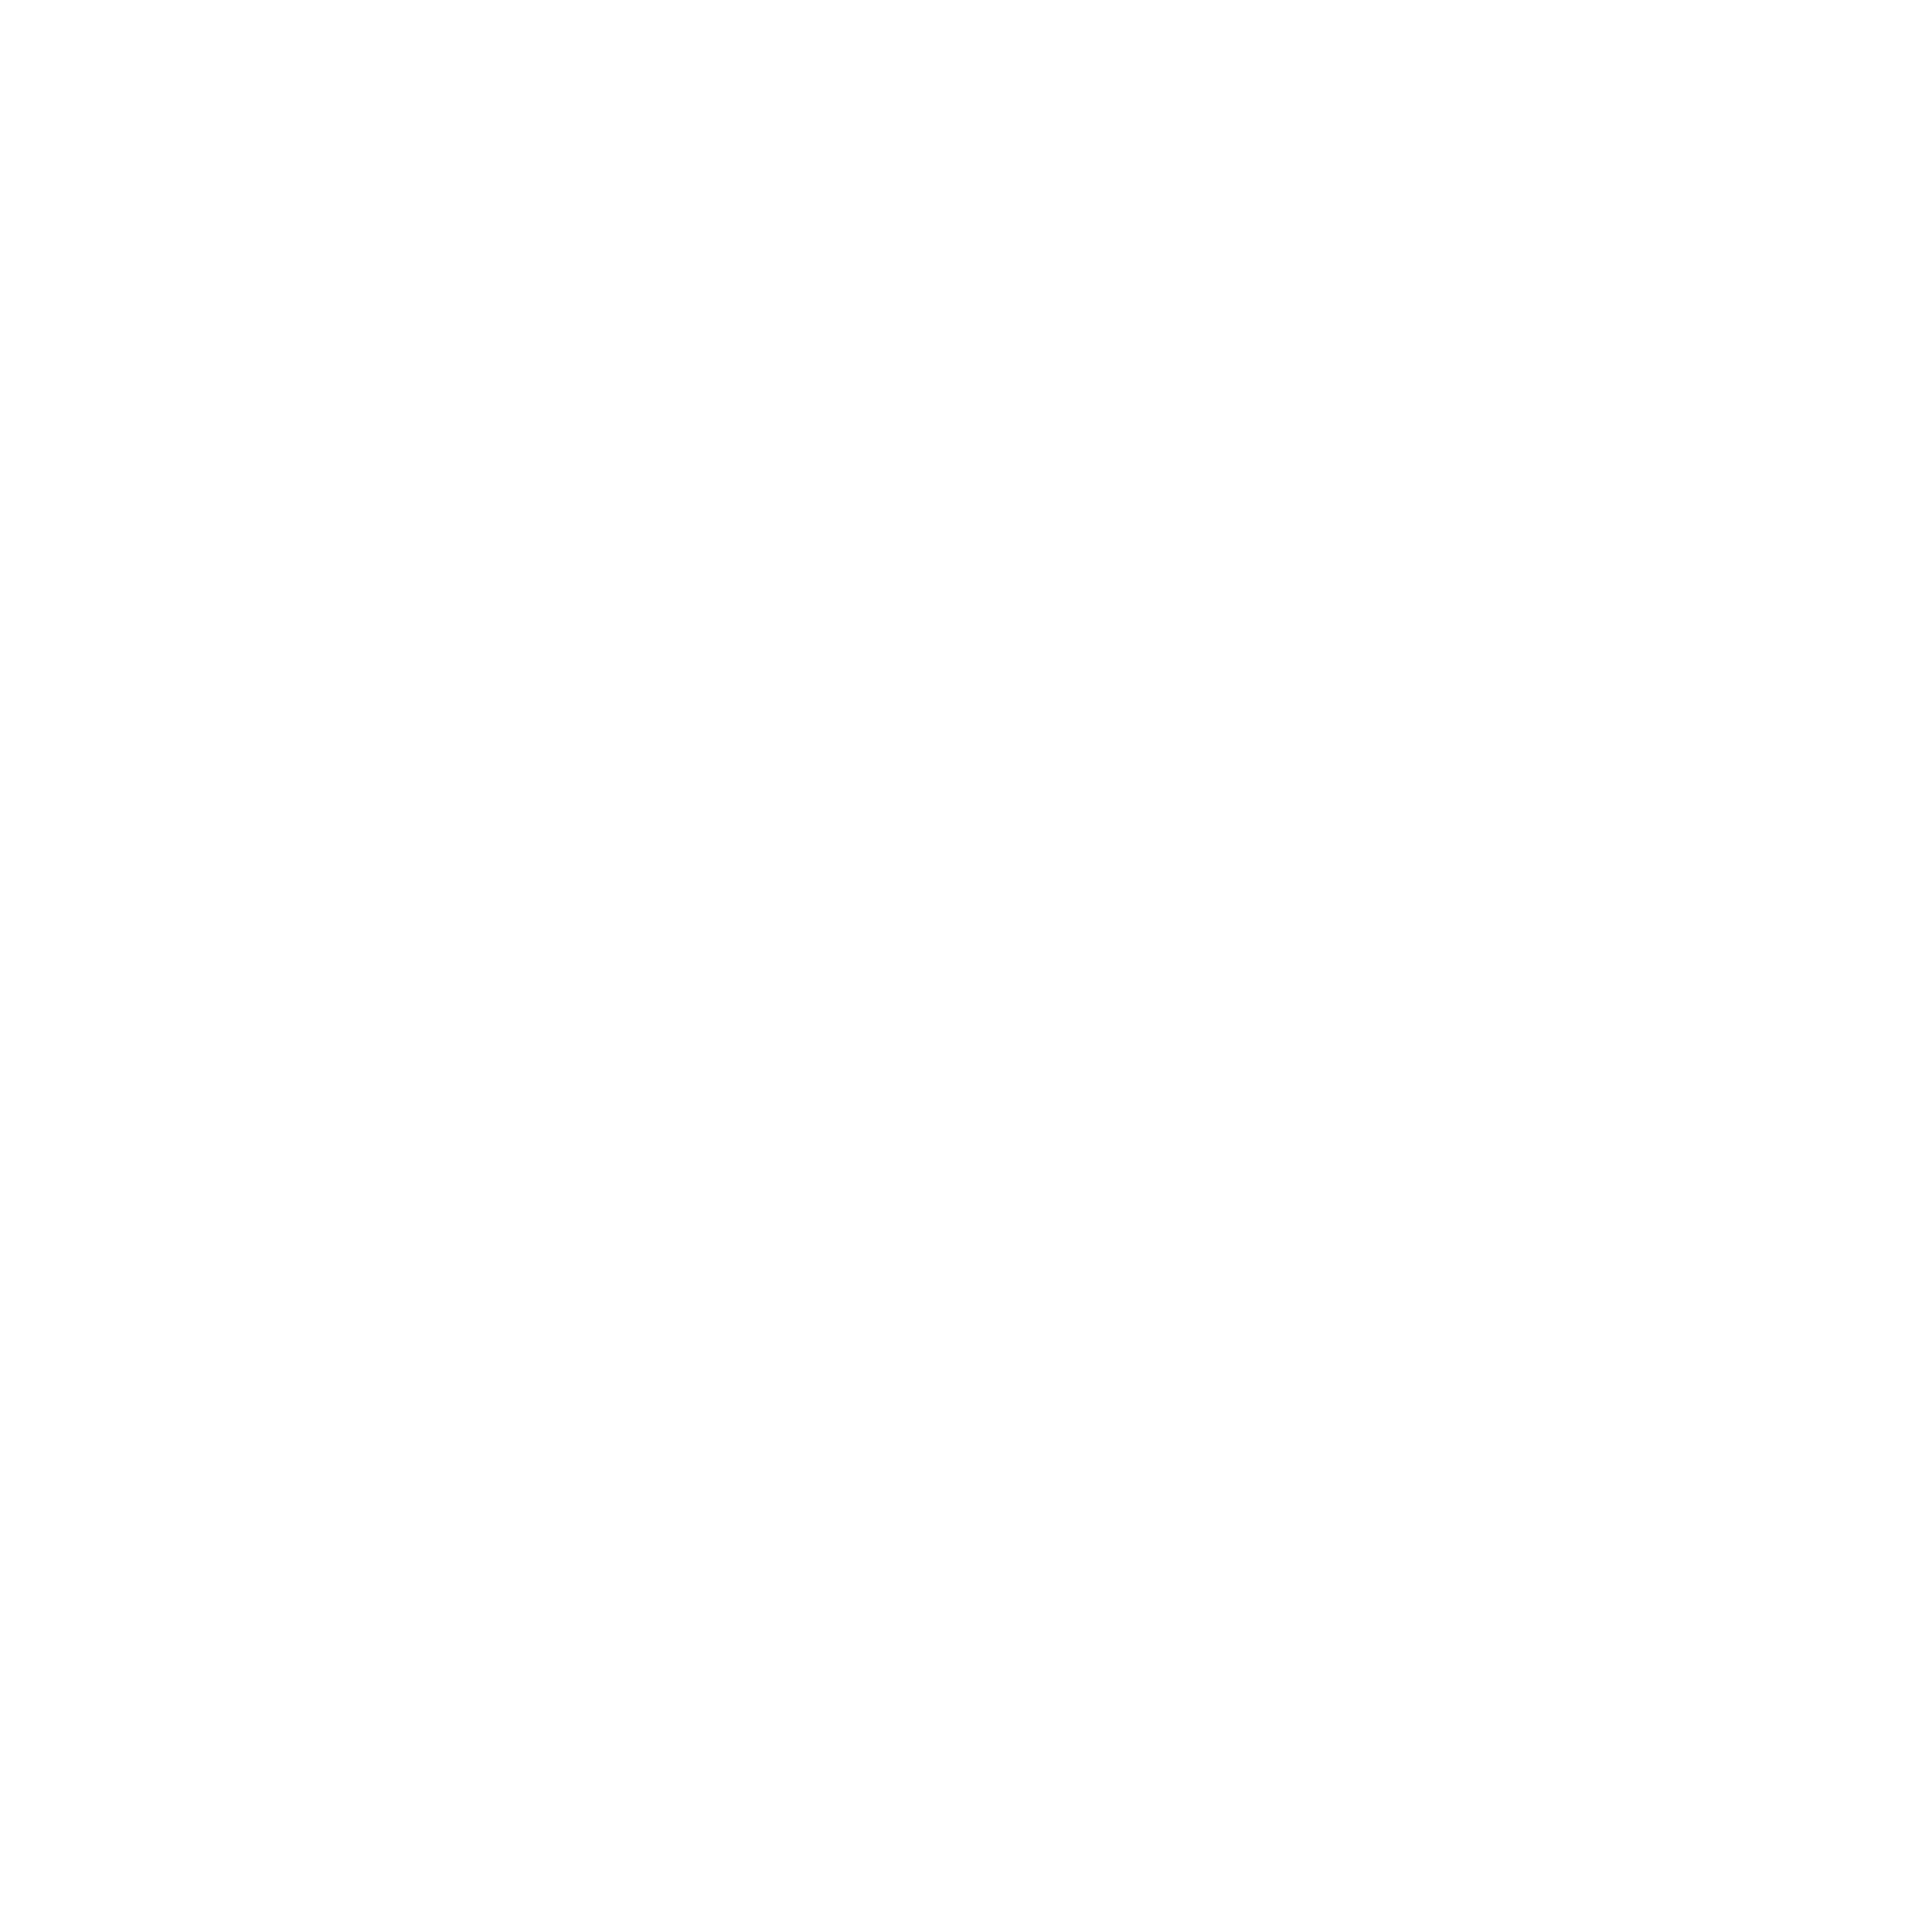

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


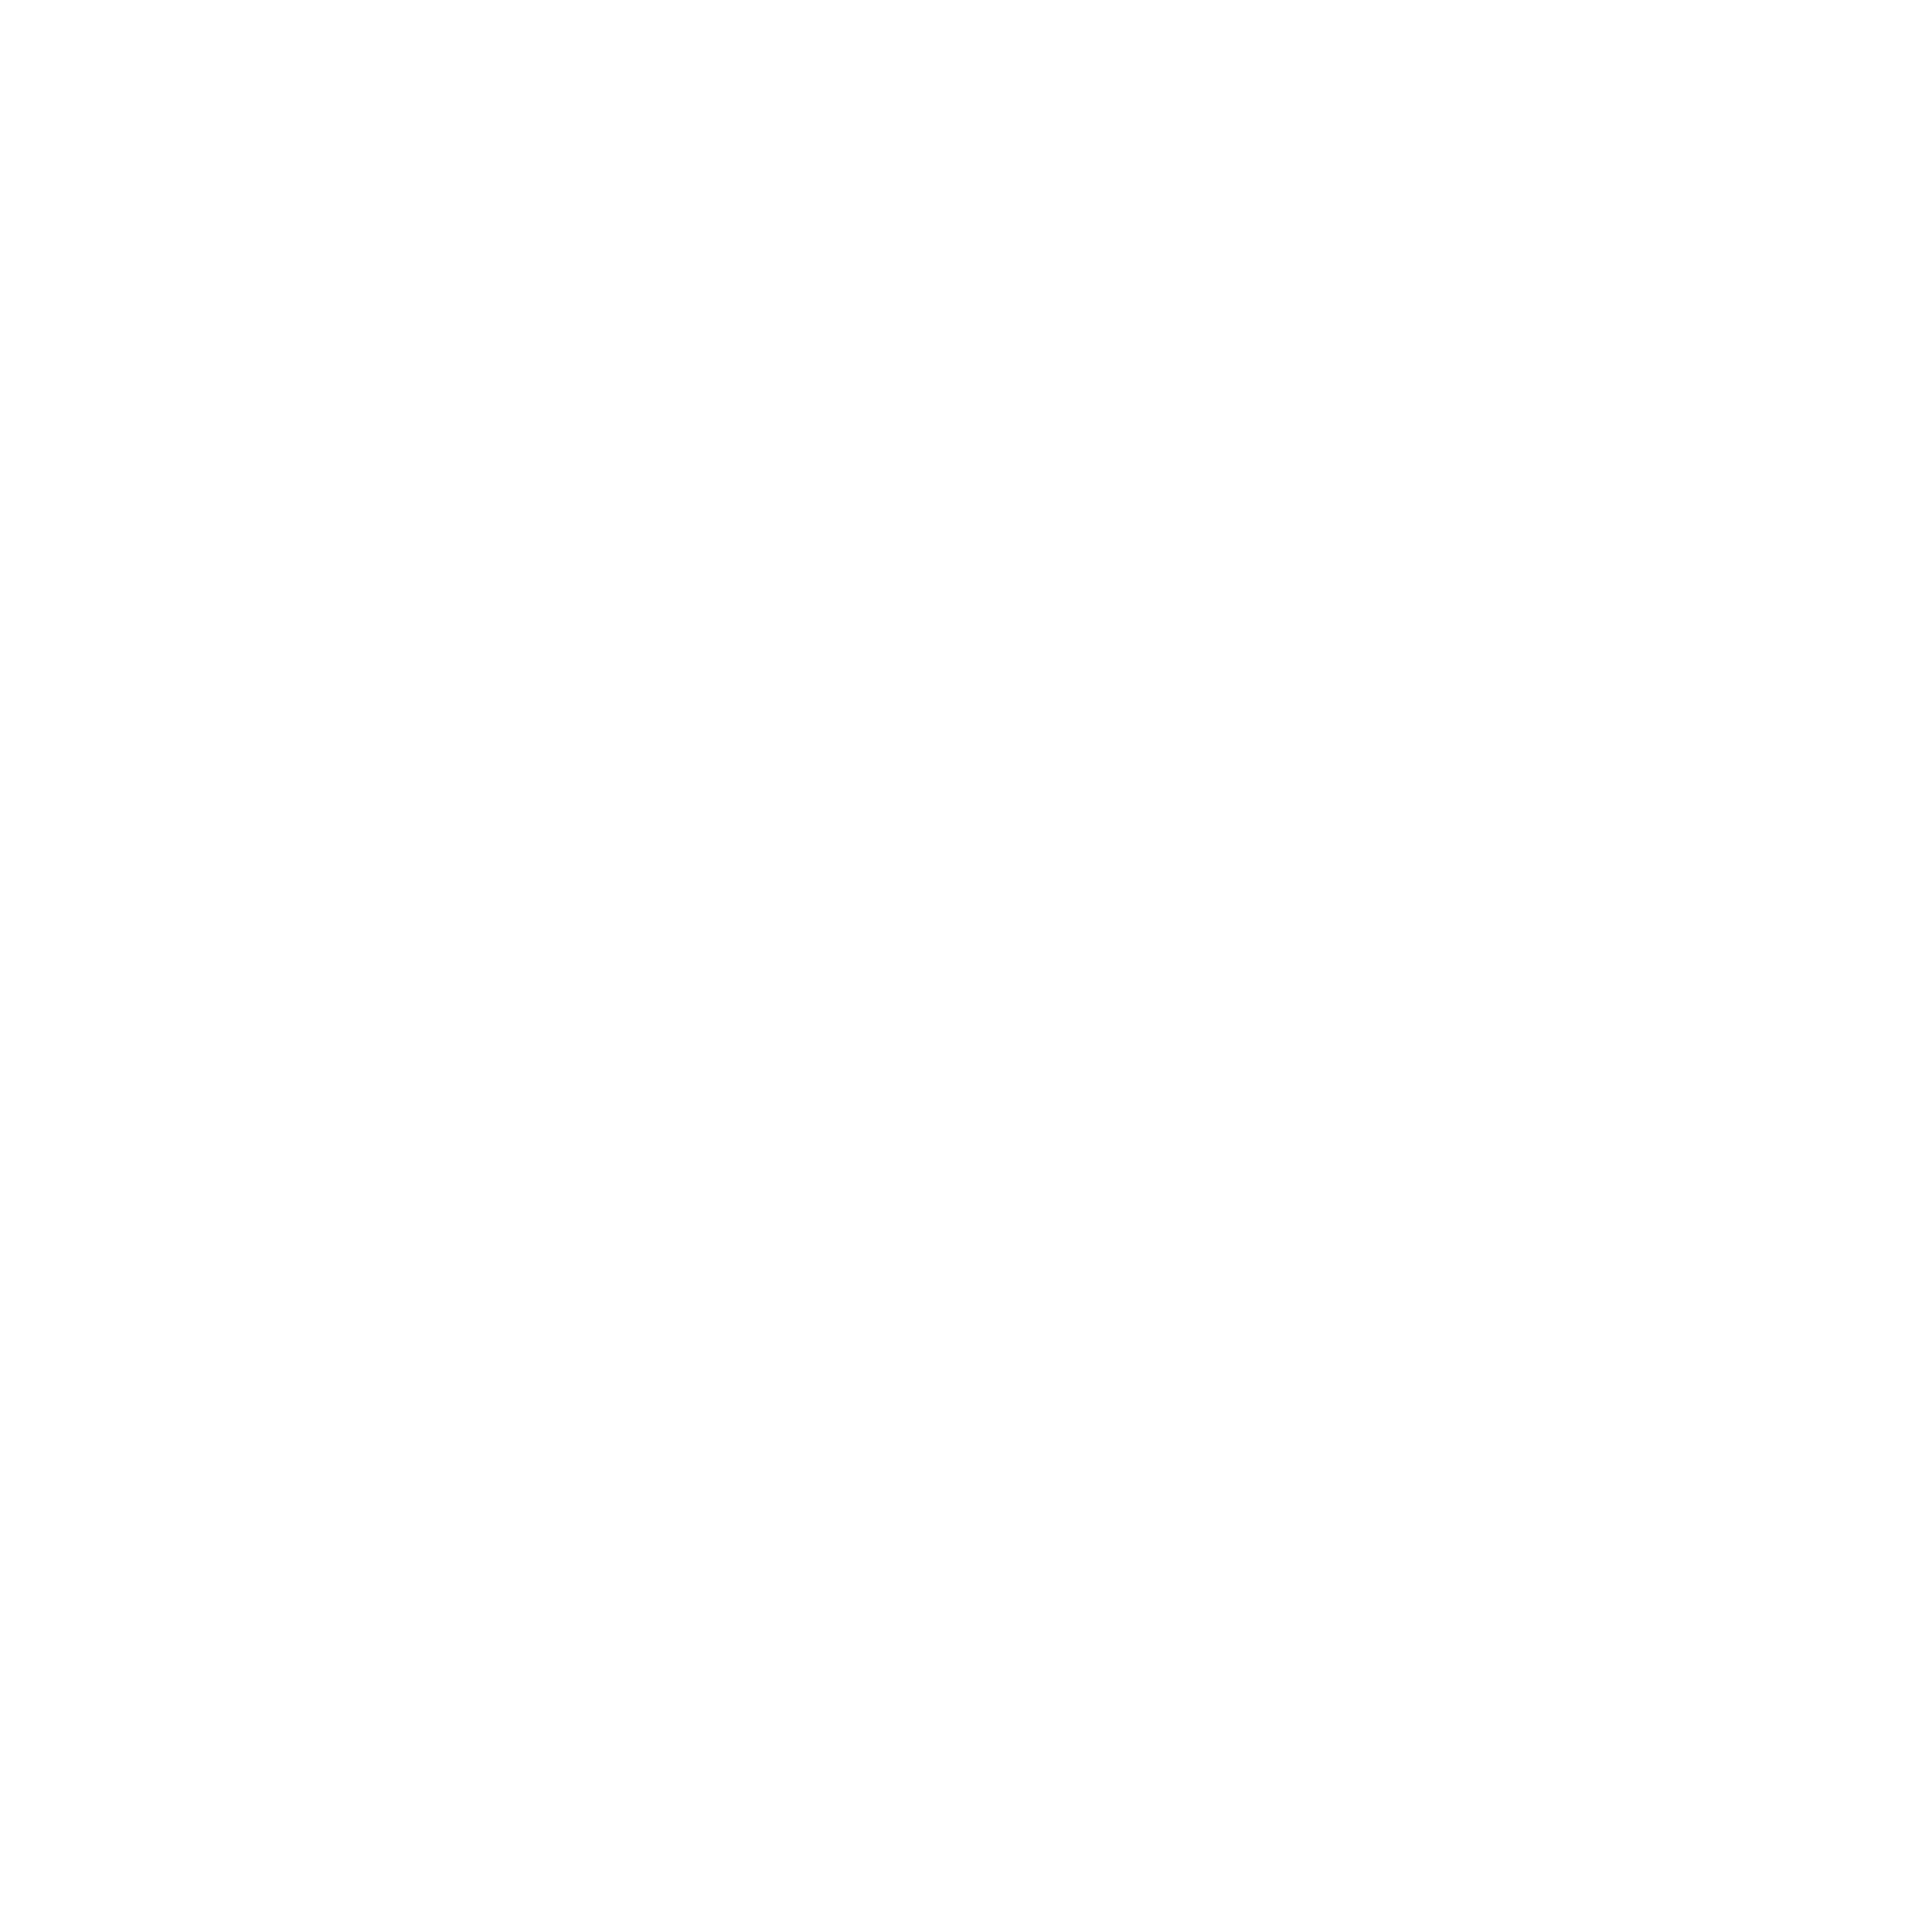

<IPython.core.display.Javascript object>


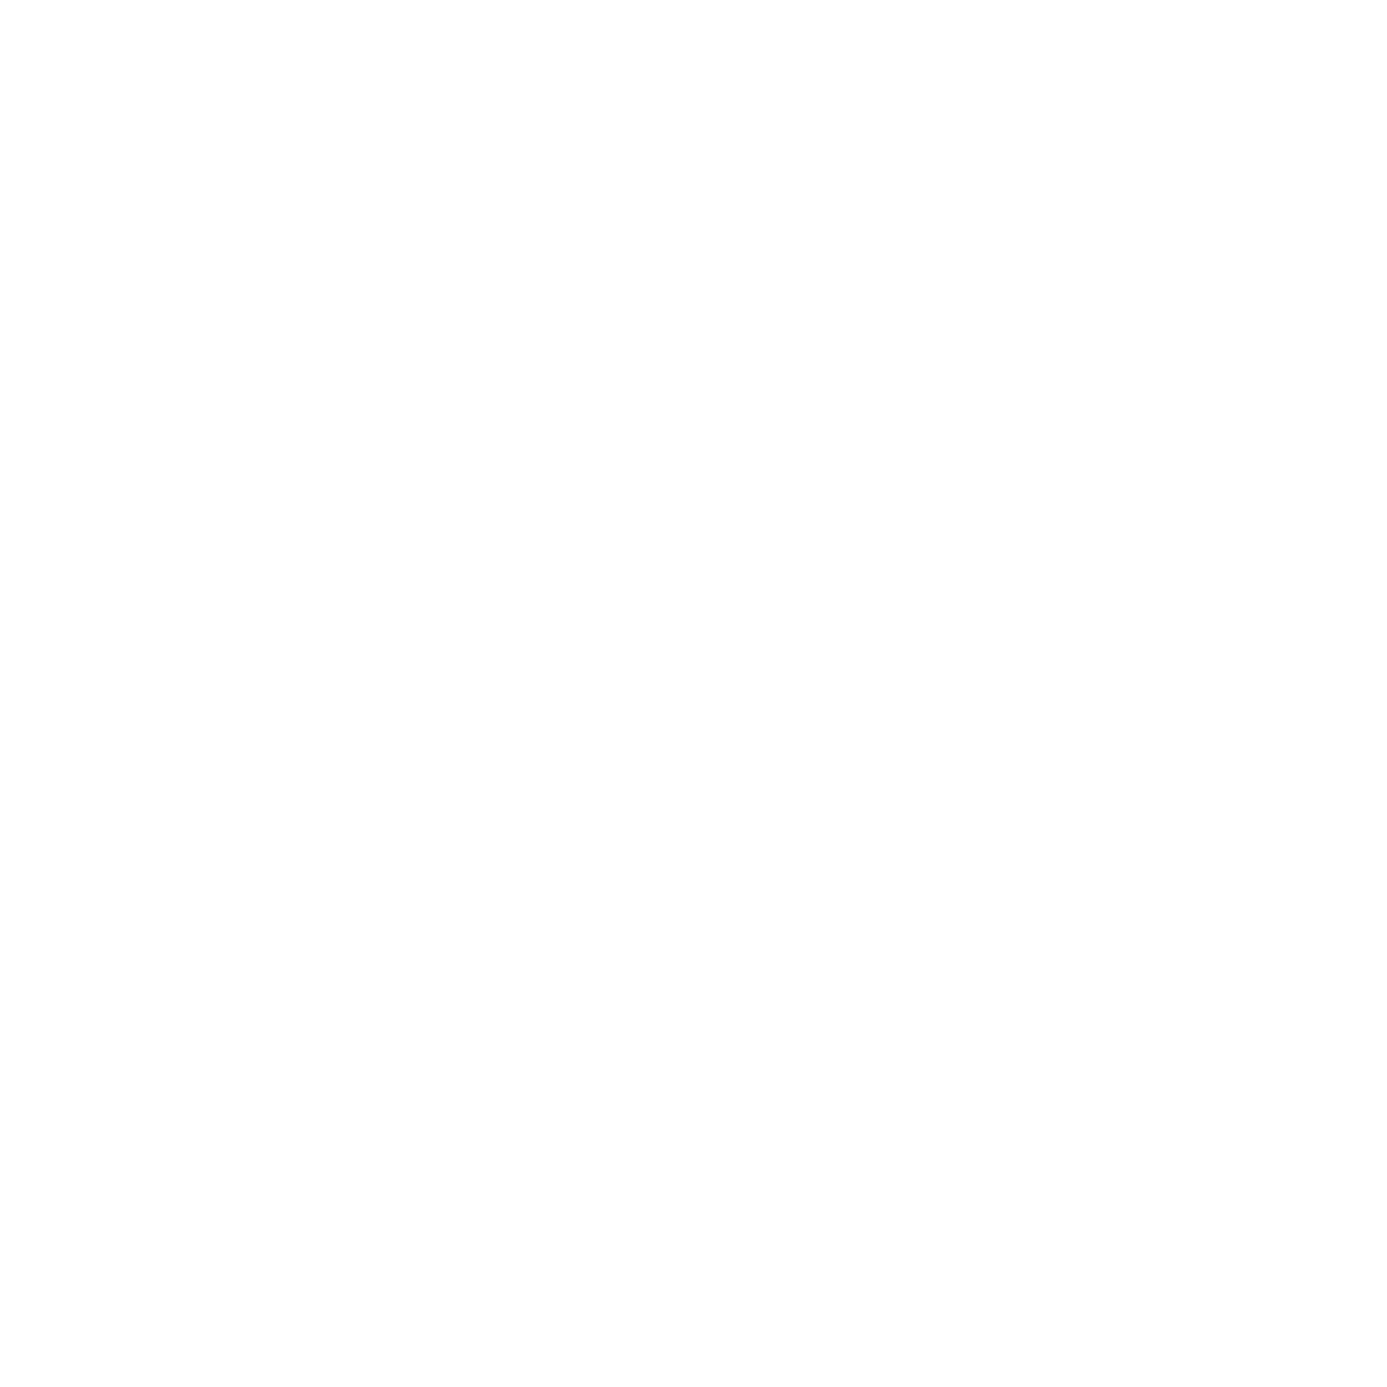

12:29 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_PulseWidth/Combined/label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


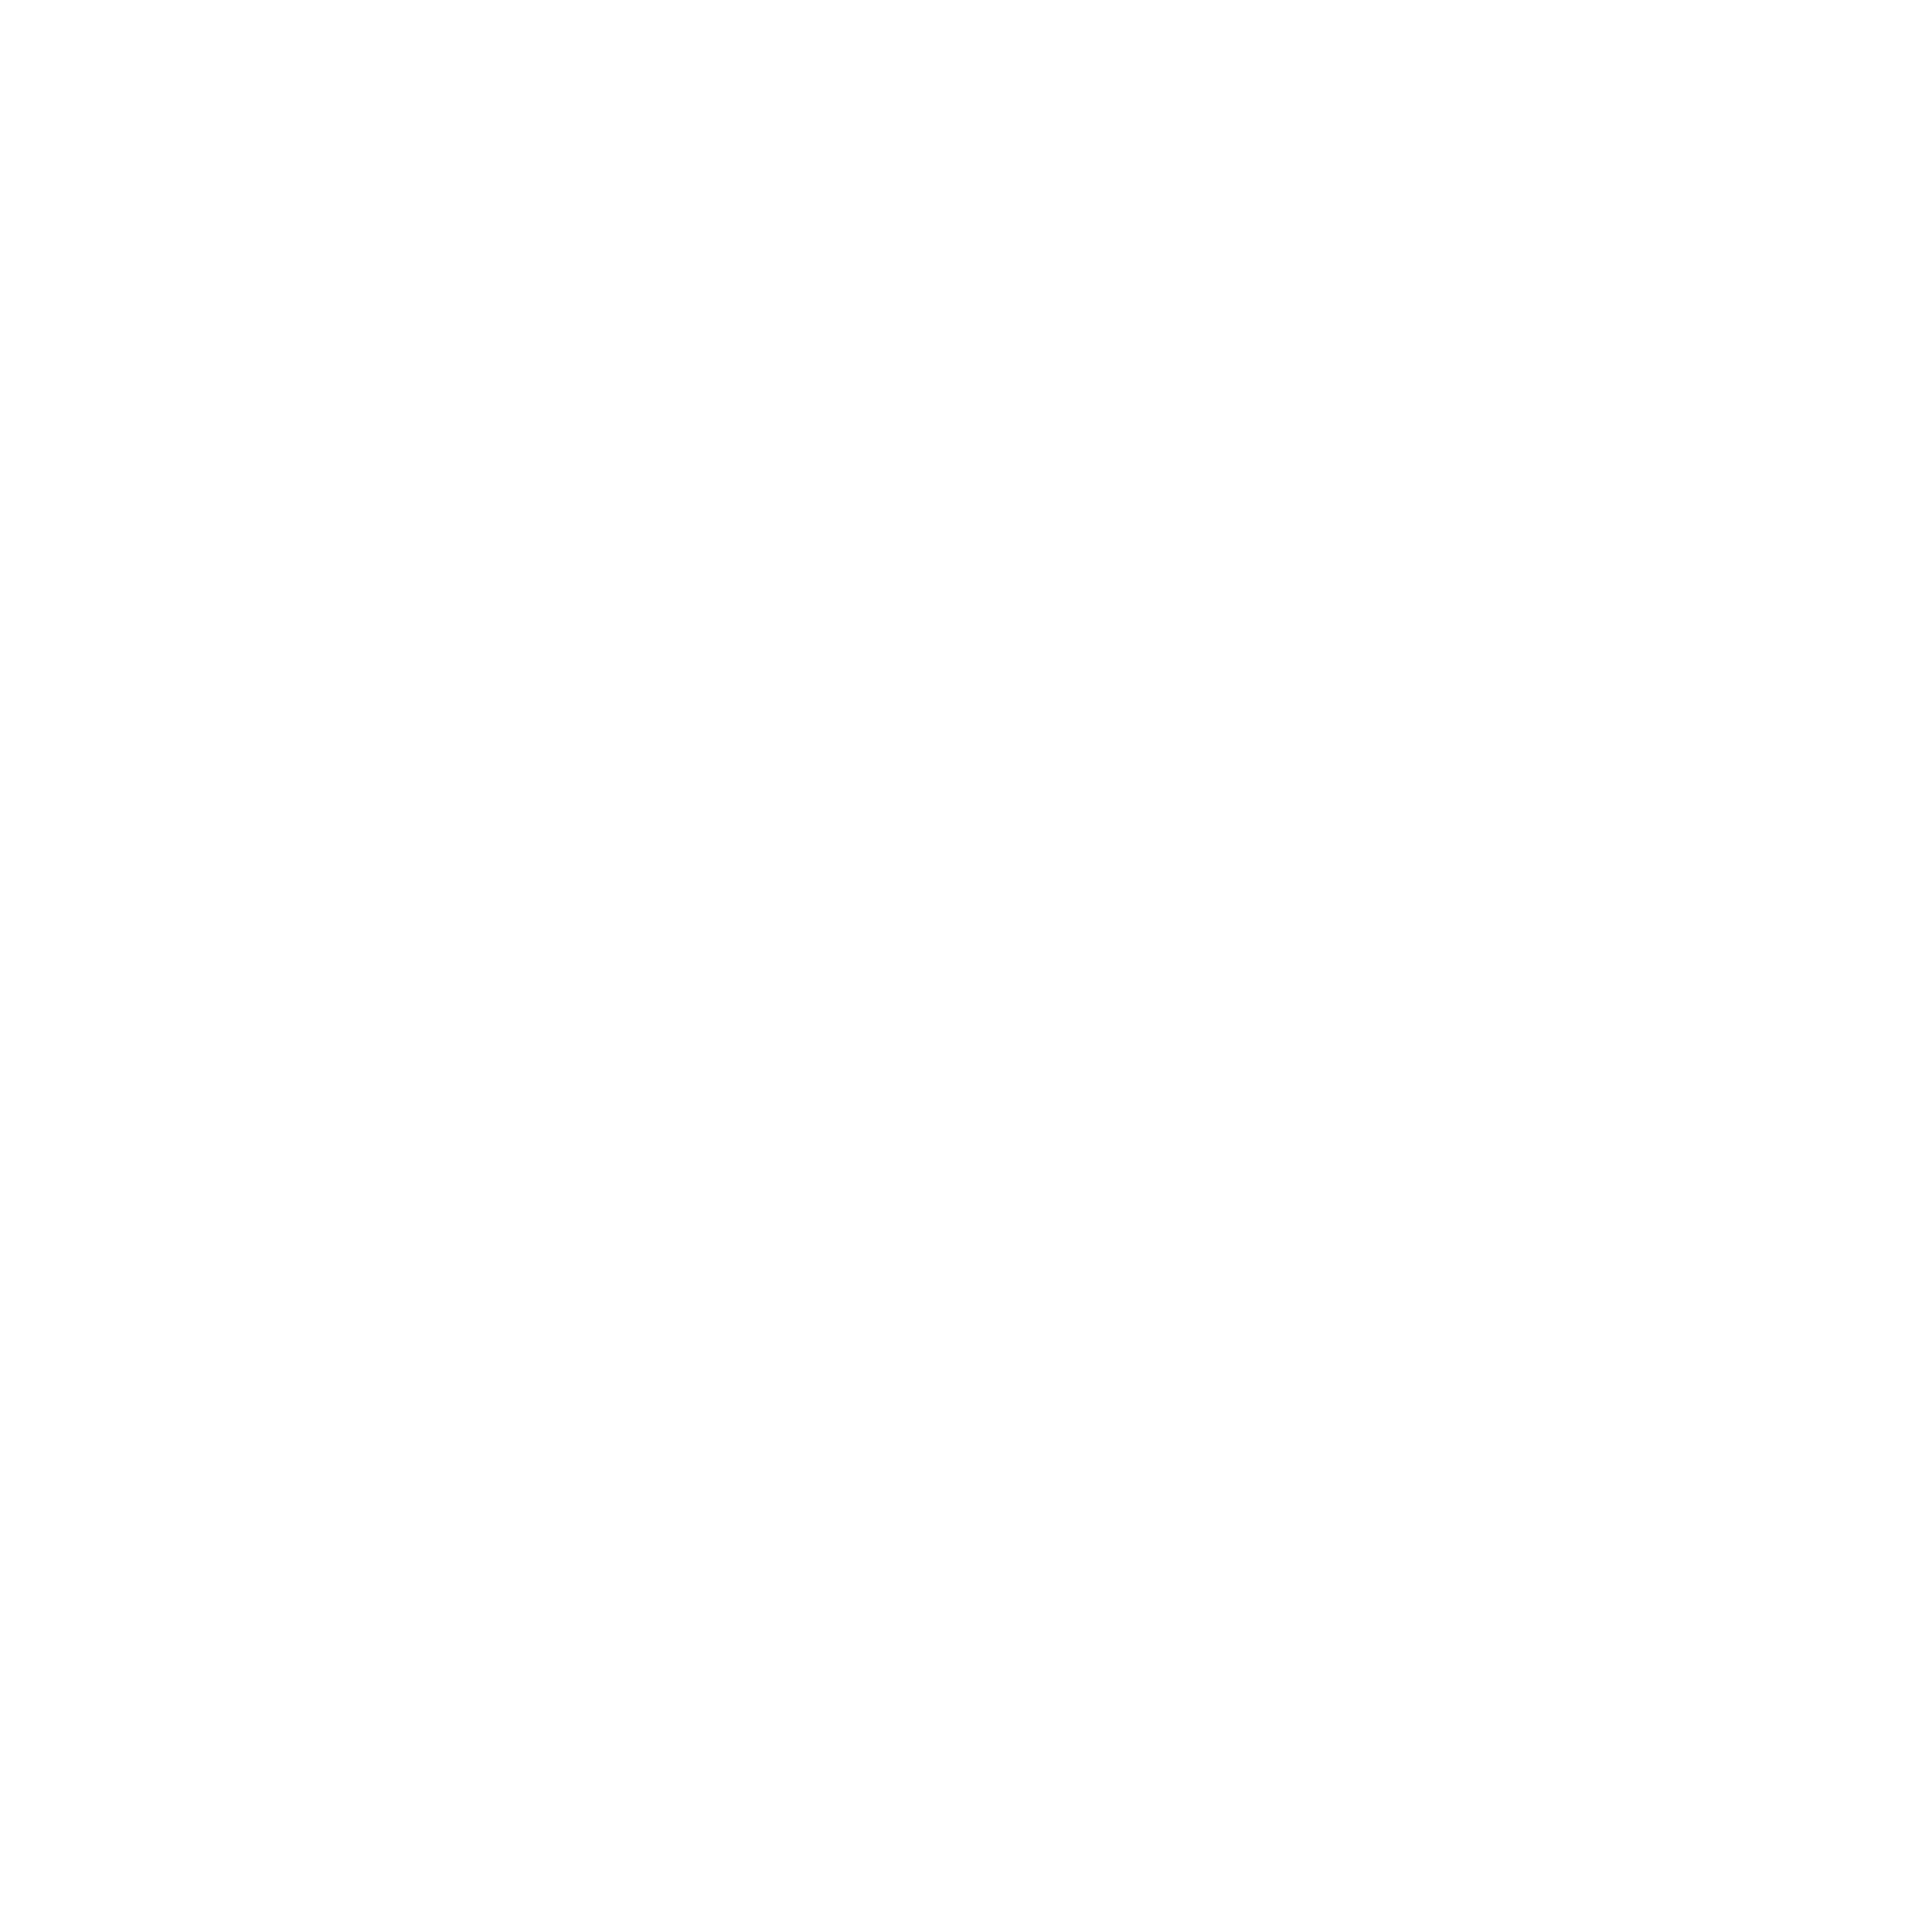

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


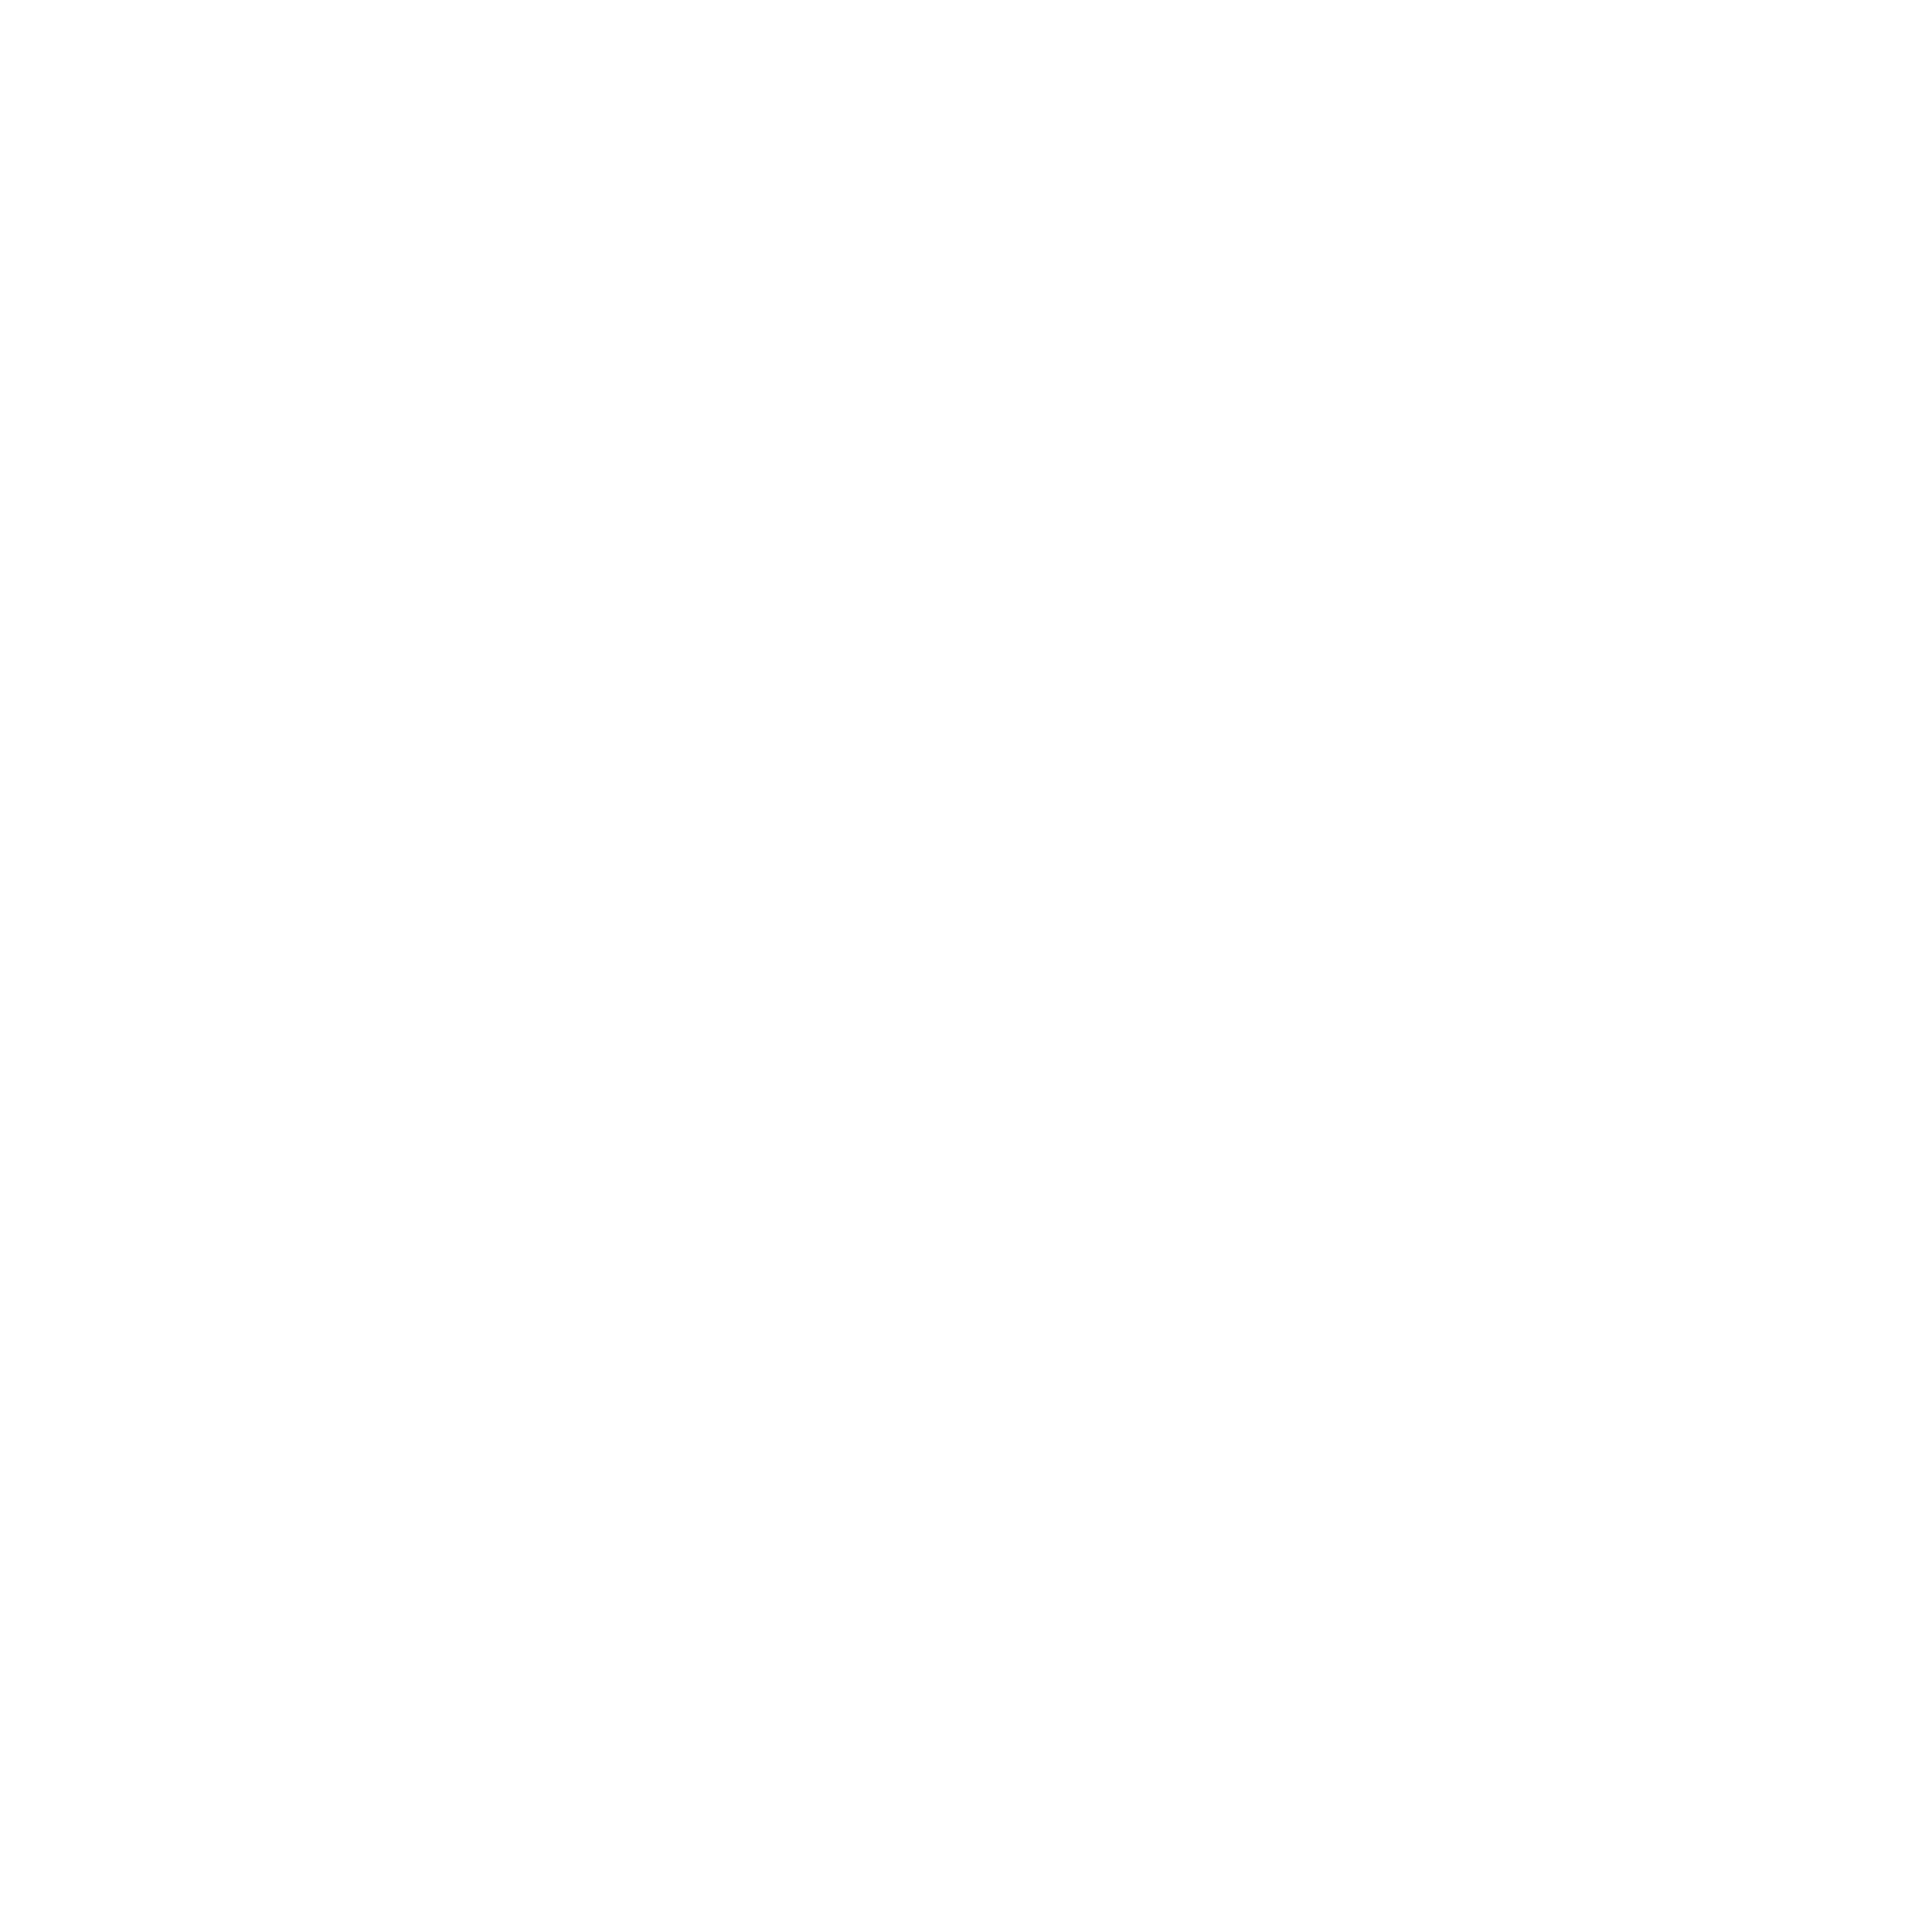

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


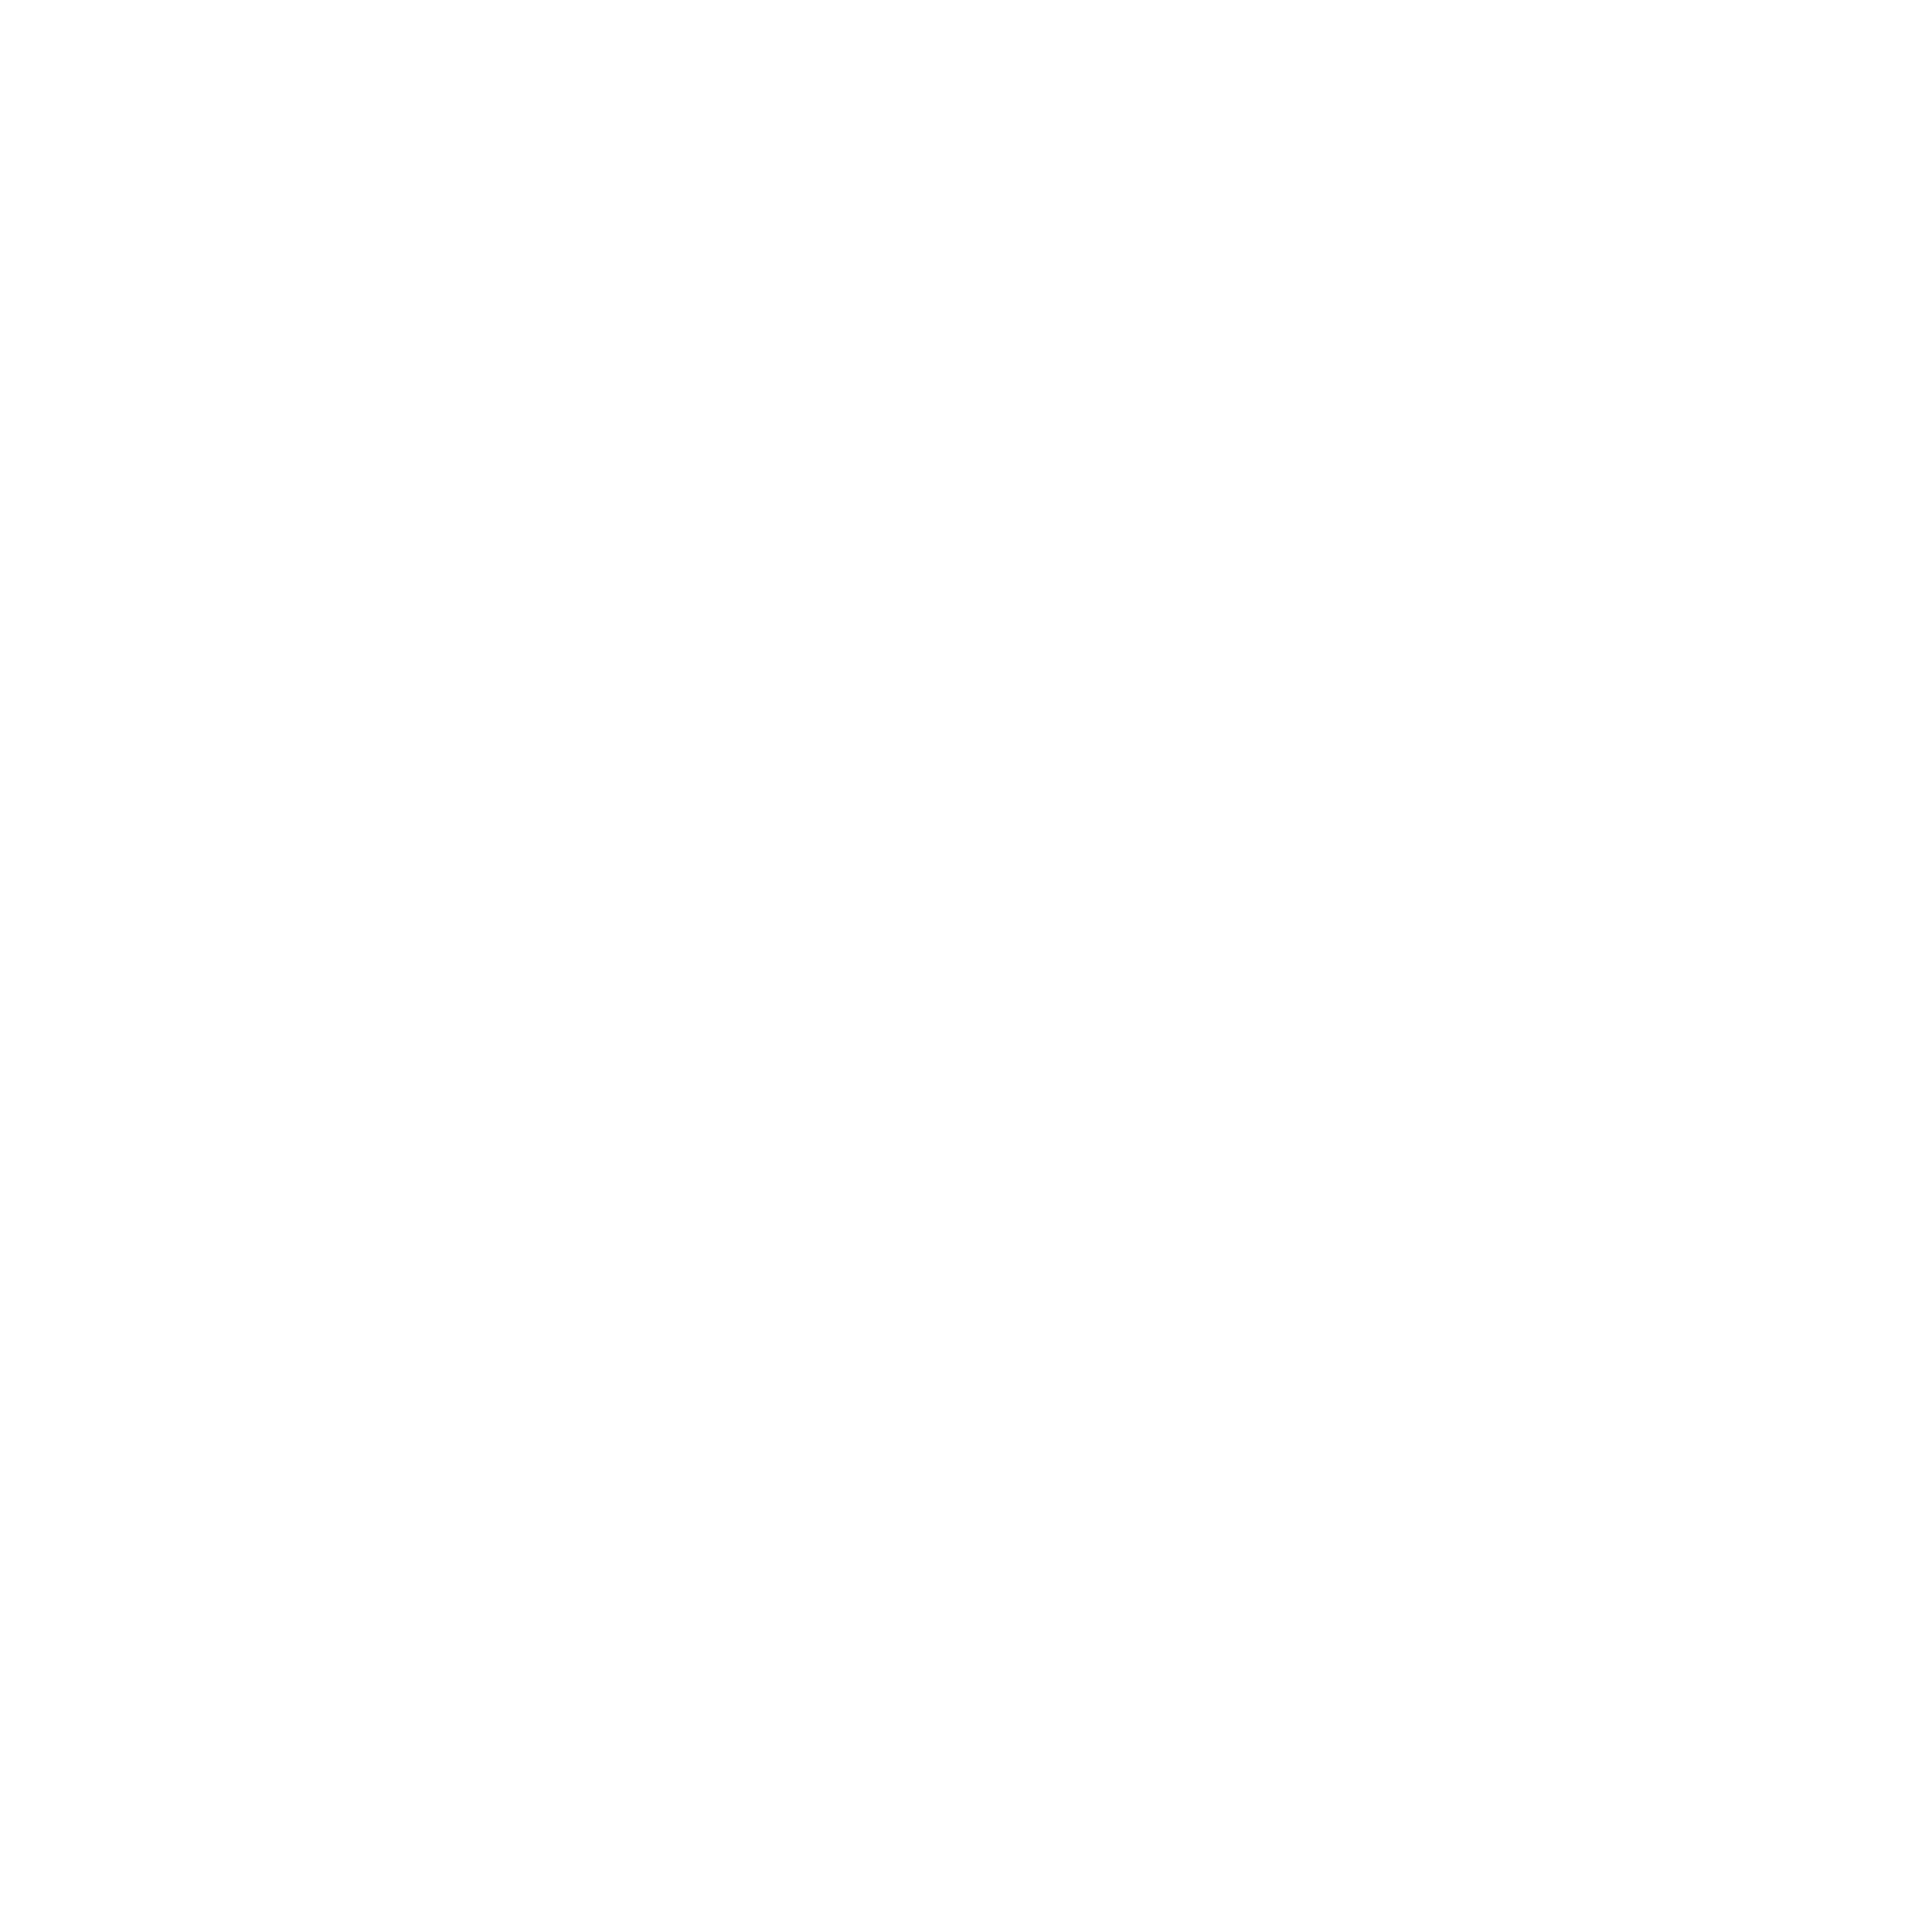

<IPython.core.display.Javascript object>


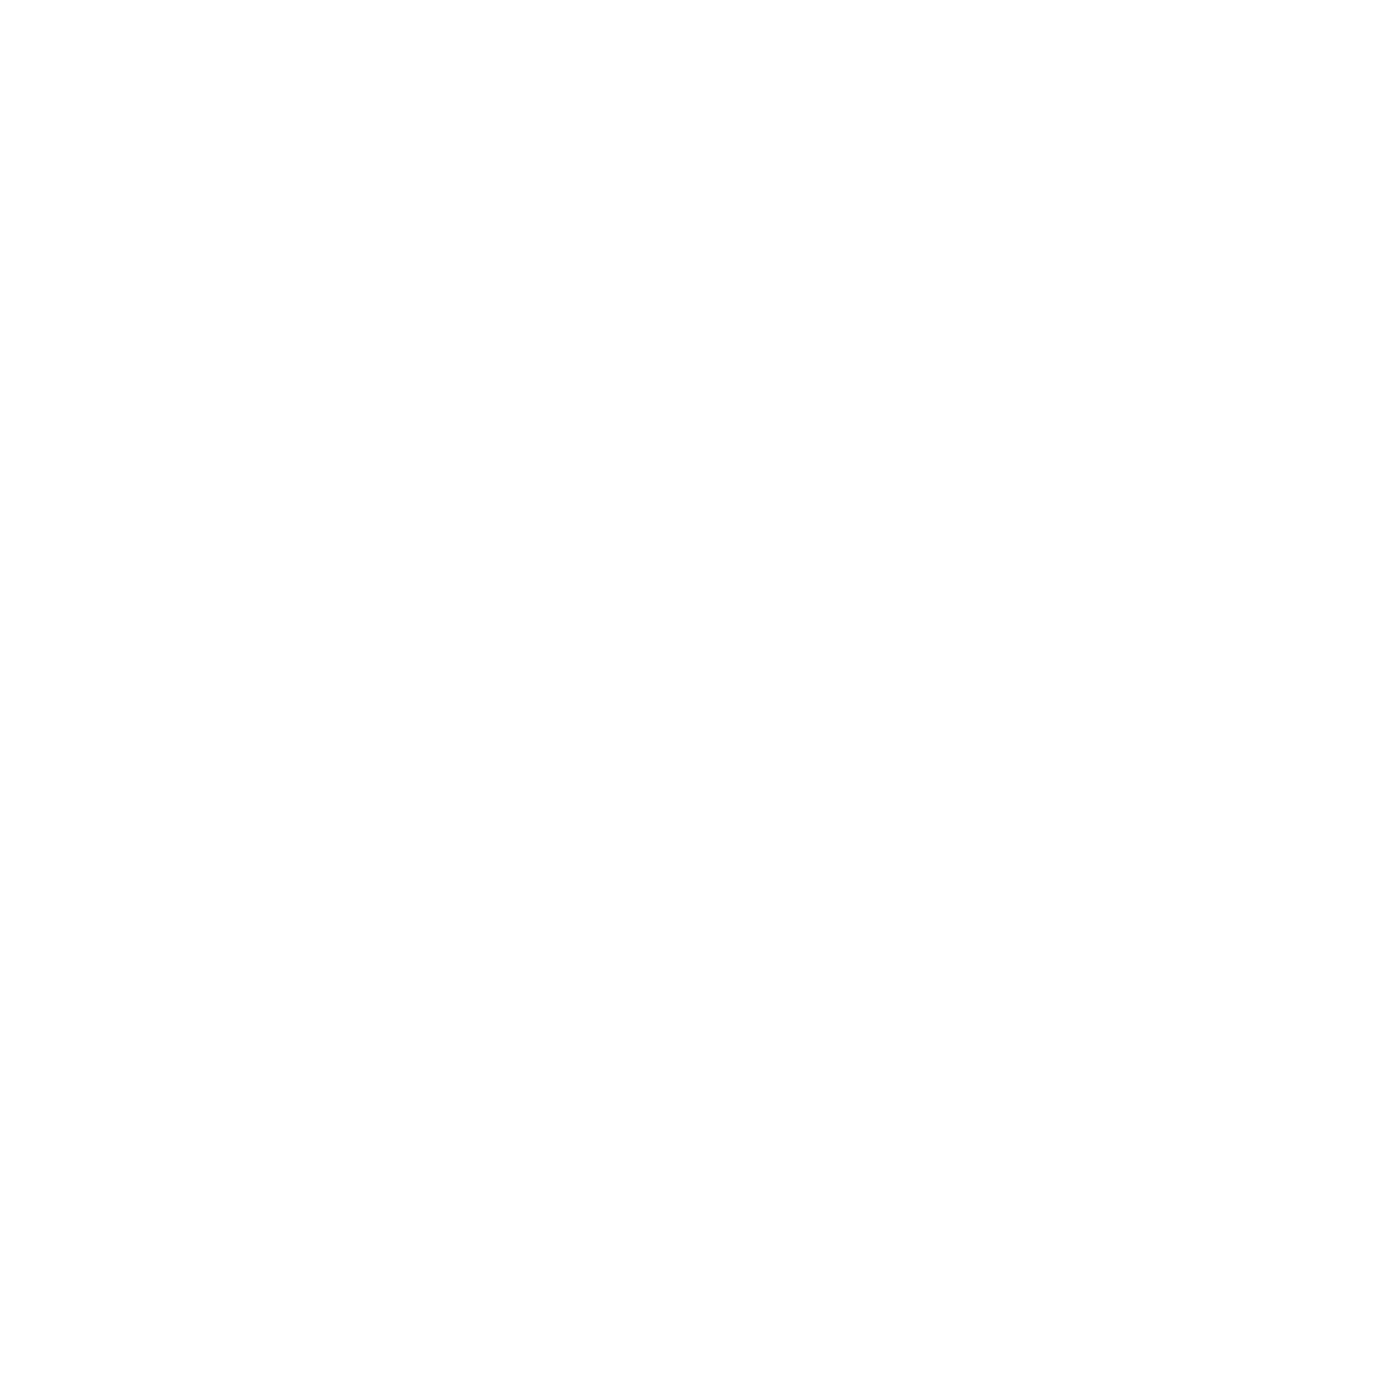

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
12:29 bilby INFO    : Sampling time: 0:05:11.333282
12:29 bilby INFO    : Summary of results:
nsamples: 12997
ln_noise_evidence:    nan
ln_evidence: 599.753 +/-  2.421
ln_bayes_factor:    nan +/-  2.421



<IPython.core.display.Javascript object>


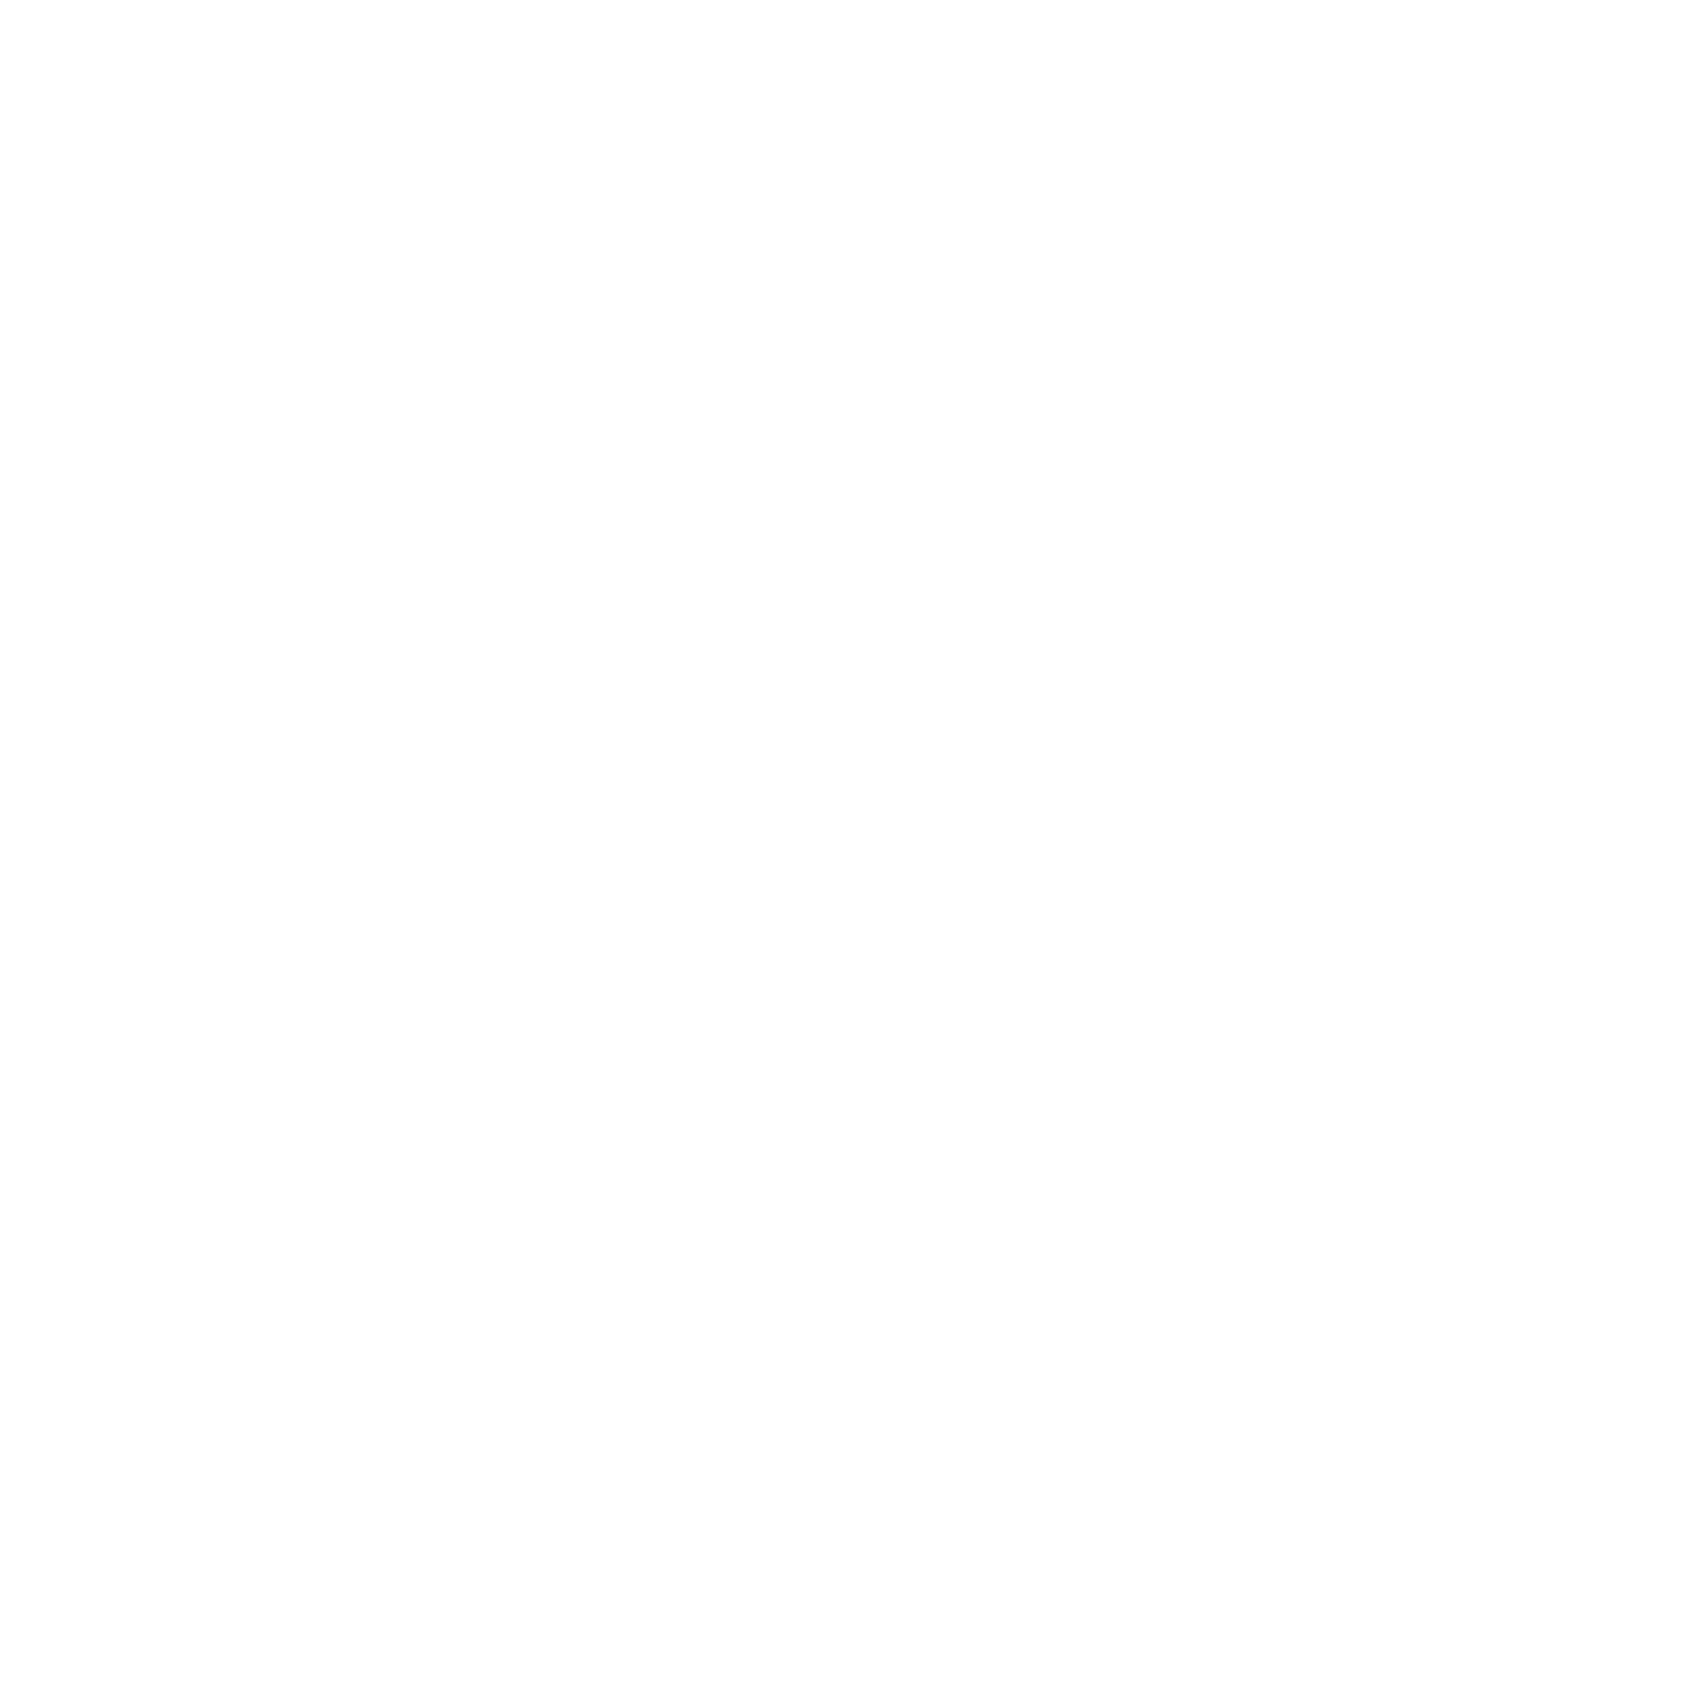

<IPython.core.display.Javascript object>


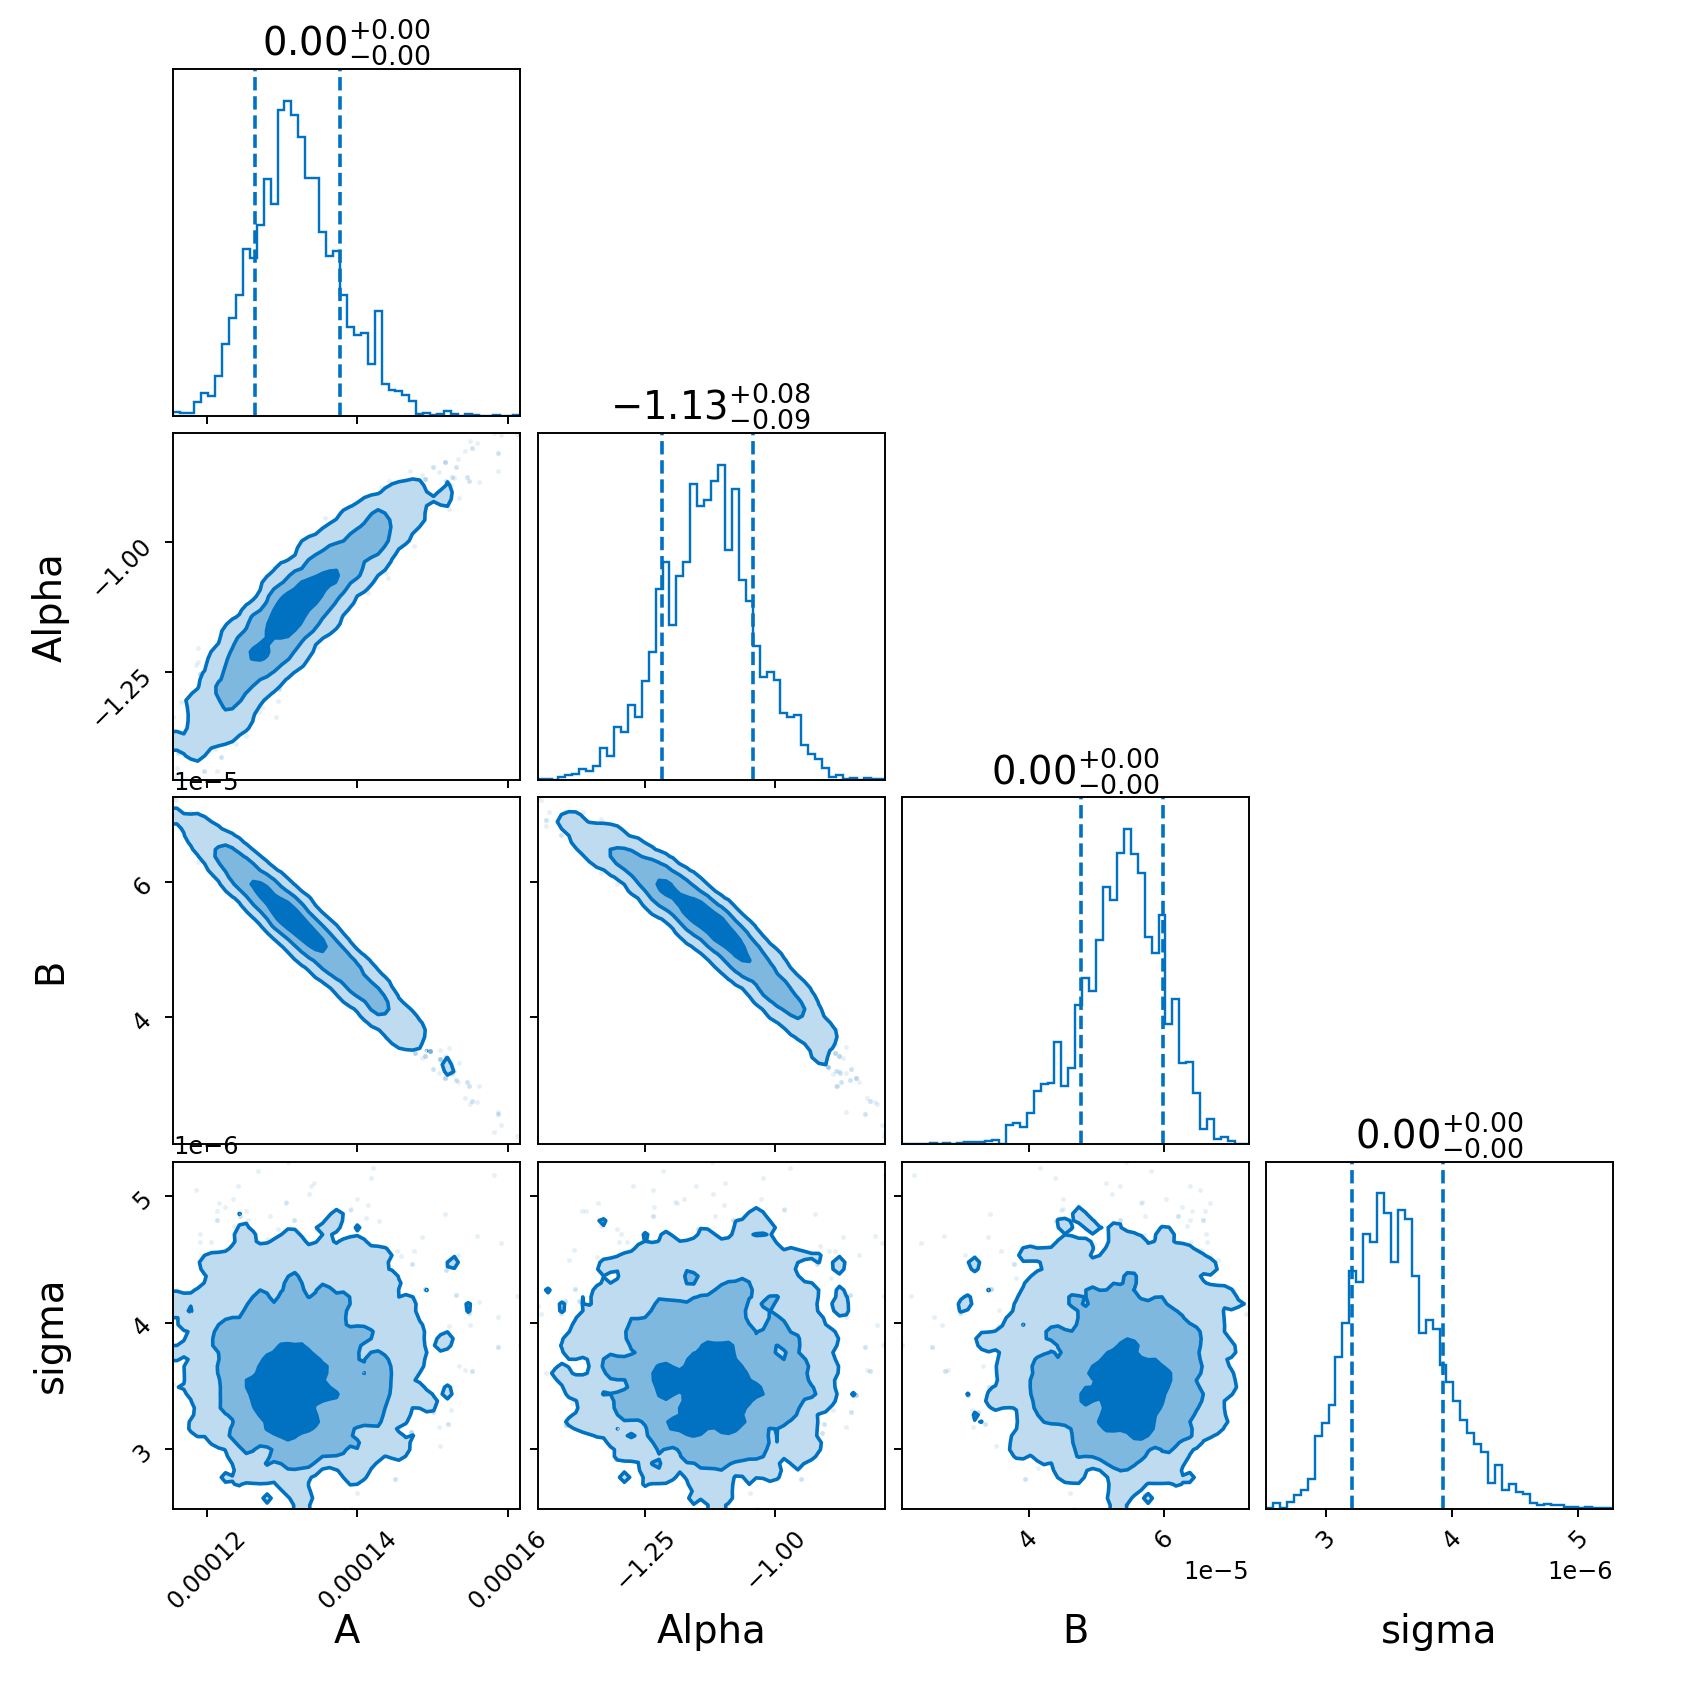

In [45]:
def func_respowerlawBLB(Freq,A,Alpha,B):
    model=A*(Freq**Alpha)+B
    return model

outdir = "/home/akulkarn/notebooks/bibly_results_PulseWidth/Combined"

Freq_comb_norm=Freq_comb/1000

#sigma=(np.sqrt(2)*P*(1/data.shape[3])*(np.sqrt(np.var(1.5*data[0,0,:,0:100],axis=1)+np.square(P/2048))))
likelihood = bilby.likelihood.GaussianLikelihood(Freq_comb_norm, width_50_comb, func_respowerlawBLB)#, sigma)
#likelihood = bilby.likelihood.GaussianLikelihood(np.asarray(Freq_UWL[0:17]), np.asarray(width_50_UWL[0:17]), func_respowerlawBLB, np.asarray(sigma_uwl[0:17]))

priors = dict()
priors["A"] = bilby.core.prior.Uniform(0, 100, "A")
priors["Alpha"] = bilby.core.prior.Uniform(-10, 10, "Alpha")
priors["B"] = bilby.core.prior.Uniform(0, 1, "B")
priors["sigma"]=bilby.core.prior.Uniform(0,1,"sigma")

result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )
result.plot_corner()

In [46]:
A_comb=result.get_one_dimensional_median_and_error_bar("A").median
Alpha_comb=result.get_one_dimensional_median_and_error_bar("Alpha").median
B_comb=result.get_one_dimensional_median_and_error_bar("B").median

<IPython.core.display.Javascript object>


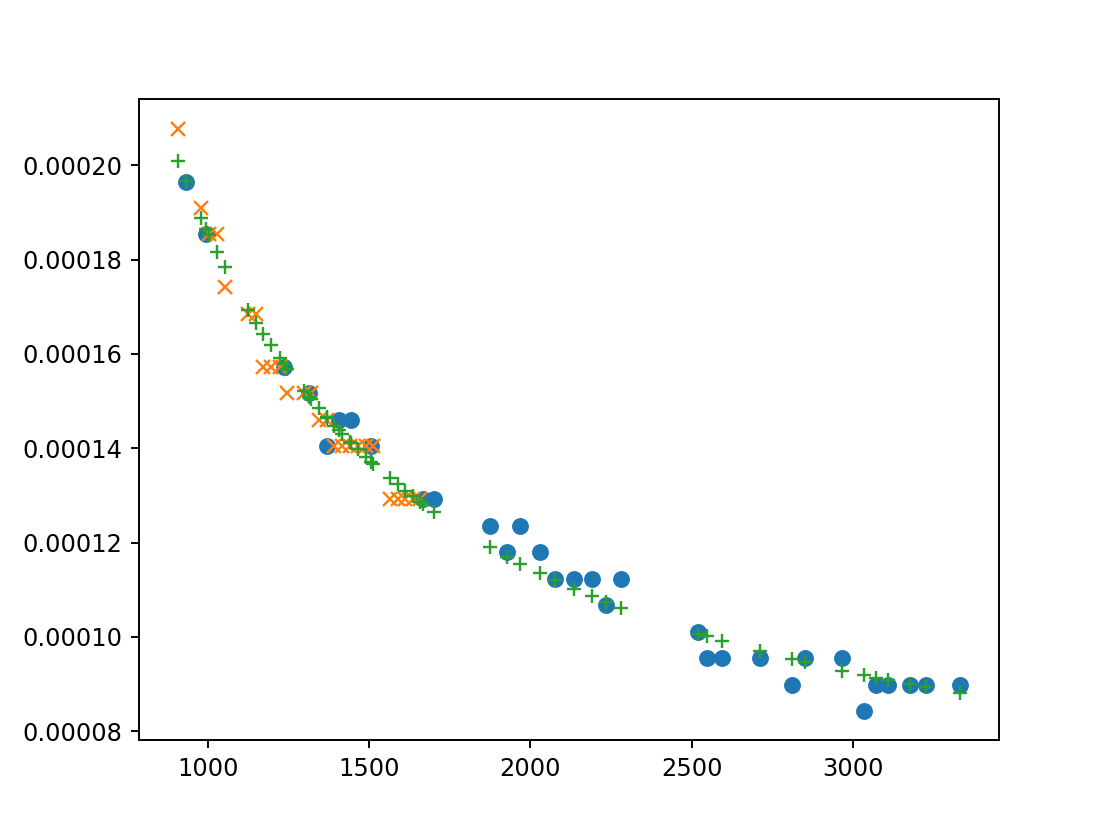

In [47]:
plt.figure()
plt.plot(Freq_Parkes,width_50_Parkes[0,0],'o')
plt.plot(Freq_MeerKAT,width_50_MeerKAT[0,0],'x')
plt.plot(Freq_comb,func_respowerlawBLB(Freq_comb_norm,A_comb,Alpha_comb,B_comb),'+')

<IPython.core.display.Javascript object>


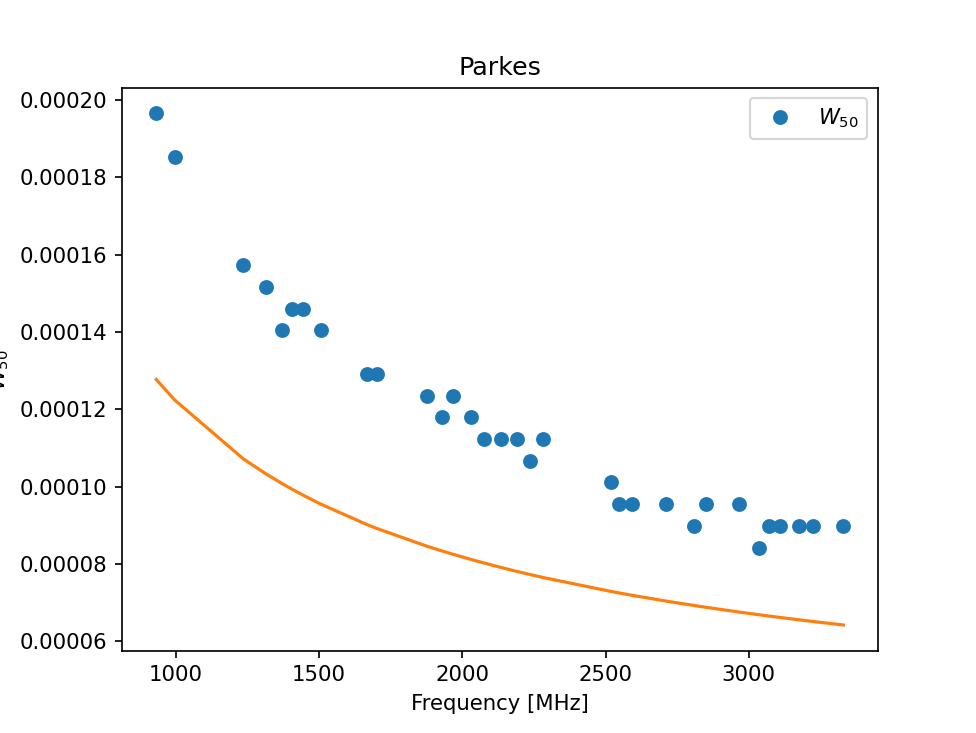

Text(0.5, 1.0, 'Parkes')

In [12]:
plt.figure()
plt.plot(Freq,width_50[0,0],'o',label='$W_{50}$')
plt.plot(Freq,func_respowerlawBLB(Freq_norm,np.median(A),np.median(Alpha),np.median(B)))
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("$W_{50}$")
plt.title(telescope)

Fitting powerlaw to intrinsic widths using lmfit/conventional fitting techniques.

# Modulation Index 

### Phase Resolved Modulation index
$$m_{I}(\phi,f)=\frac{\sqrt(\sigma_{I}^2(\phi,f)-\sigma_{I,off}^2(f))}{I(\phi,f)}$$

Choosing first 100 bins for estimating the off pulse sigma

The modulation index is calculated only for bins around the peak of the pulse.
Choices for range around the maximum of peak:
1. maximum values of the mean of low and high indices calculated at each frequency.

In [12]:
def get_modIndex(datain,low,high):
    dim=datain.shape
    modIndex=np.ndarray([dim[1],dim[2],high-low])
    for pol in range(dim[1]):
        for freq in range(dim[2]):
            maxvalarg=int(np.nanargmax(np.mean(datain[:,pol,freq],axis=0)))
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.var(datain[:,pol,freq,100],axis=0))/np.mean(datain[:,pol,freq,low:high],axis=0)
            modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:100],axis=0)))/np.mean(datain[:,pol,freq,low:high],axis=0)
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:100],axis=0)))
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0))/np.mean(datain[:,pol,freq,low:high],axis=0)
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0))#/np.mean(datain[:,pol,freq,low:high],axis=0)
    return modIndex

shift=0
modIndex=get_modIndex(data+(shift)*np.ones(data.shape),0,1024) ## Adds a DC to intensity curves


/tmp/ipykernel_36730/2050550518.py:8: RuntimeWarning: invalid value encountered in sqrt
  modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:100],axis=0)))/np.mean(datain[:,pol,freq,low:high],axis=0)


Summing consequetive bins first and then computing the modulation index.

In [34]:
def get_summedmodIndex(datain,low,high):
    dim=datain.shape
    modIndex=np.ndarray([dim[1],dim[2],high-low])
    for pol in range(dim[1]):
        for freq in range(dim[2]):
            maxvalarg=int(np.nanargmax(np.mean(datain[:,pol,freq],axis=0)))
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.var(datain[:,pol,freq,100],axis=0))/np.mean(datain[:,pol,freq,low:high],axis=0)
            modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:50],axis=0)))/np.mean(datain[:,pol,freq,low:high],axis=0)
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:100],axis=0)))
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0))/np.mean(datain[:,pol,freq,low:high],axis=0)
            #modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0))#/np.mean(datain[:,pol,freq,low:high],axis=0)
    return modIndex


def summing_filter(datain,n):
    """Return the profile which is summed in bins by factor n with original number of bins=1024"""
    dim=datain.shape
    dataout=np.ndarray([dim[0],dim[1],dim[2],int(dim[3]/n)])
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                for bins in range(int(dim[3]/n)):
                    dataout[subint,pol,freq,bins]=np.sum(datain[subint,pol,freq,n*bins:n*(bins+1)])
    return dataout


data_summed=summing_filter(data,10)  ## bScrunching by a factor of 10.

In [39]:
shift=0
modIndex_summed=get_summedmodIndex(data_summed+(shift)*np.ones(data_summed.shape),0,102) ## Adds a DC to intensity cur

/tmp/ipykernel_15323/1518641396.py:8: RuntimeWarning: invalid value encountered in sqrt
  modIndex[pol,freq,:]=np.sqrt(np.var(datain[:,pol,freq,low:high],axis=0)-np.mean(np.var(datain[:,pol,freq,0:10],axis=0)))/np.mean(datain[:,pol,freq,low:high],axis=0)


<IPython.core.display.Javascript object>


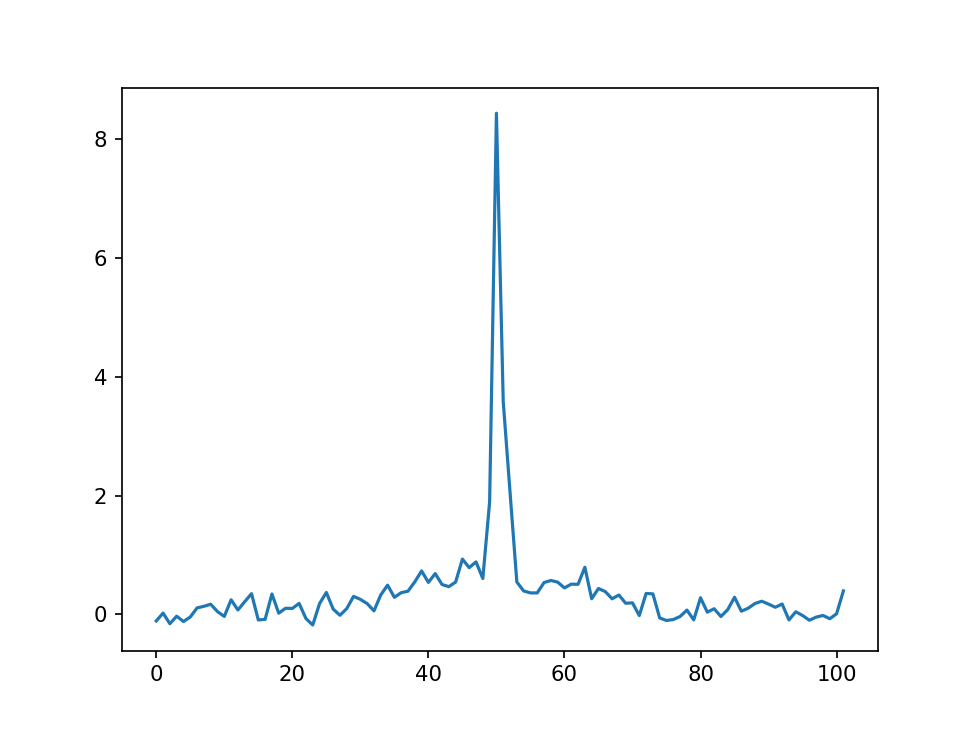

In [36]:
plt.figure()
for chn in range(1):#data_summed.shape[2]):
    plt.plot((data_summed[0,0,chn,:]))#,axis=0))

<IPython.core.display.Javascript object>


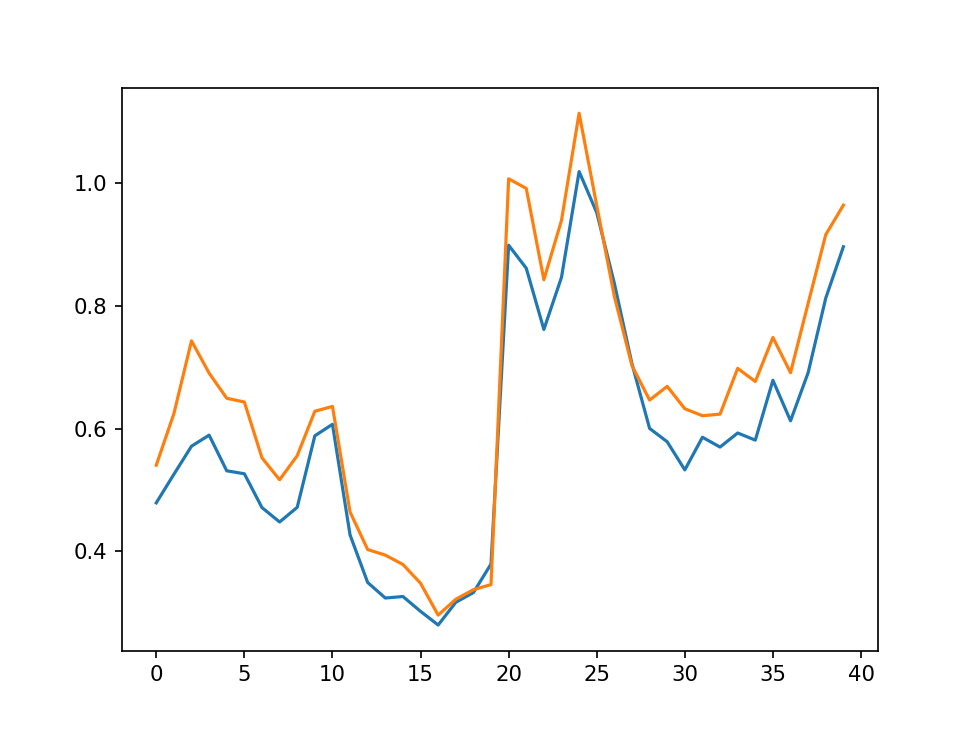

In [42]:
plt.figure()
plt.plot(modIndex_summed[0,4,30:70])
plt.plot(modIndex_summed[0,15,30:70])

The frequency dependence of modulation index might come from the fact that the width of the profile is dropping at higher frequenceis but we are calculating the index with the same wide window at all frequenecis.
To resolve this it was decided to compute modulation index with width equal to 0.5 of Max intensity at that frequency.



<IPython.core.display.Javascript object>


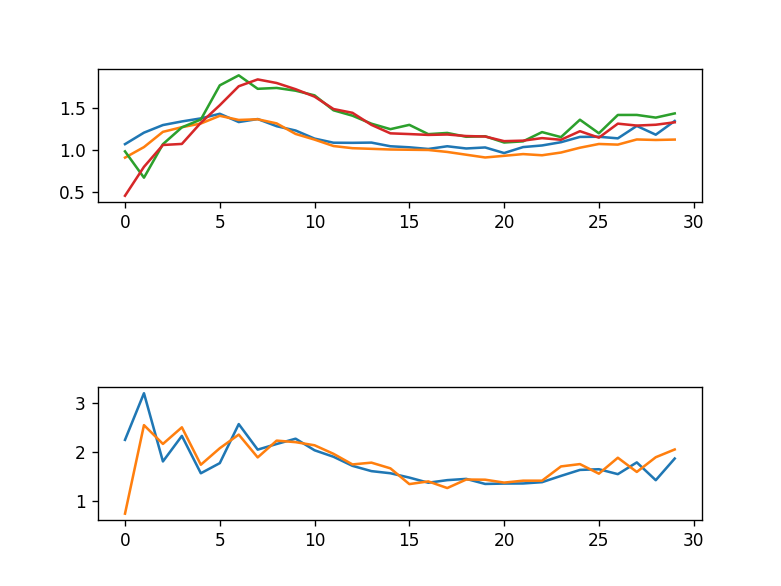

<IPython.core.display.Javascript object>


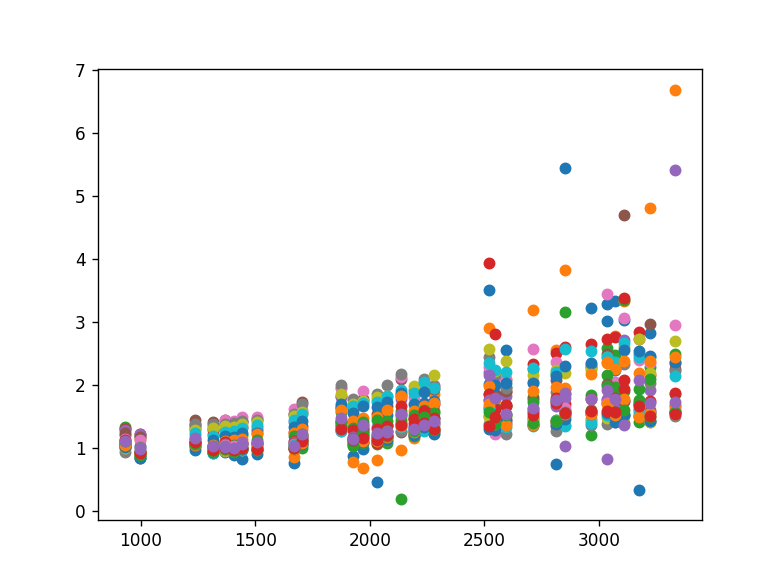

In [11]:
plt.figure()
low=500
high=530
plt.subplot(3,1,1)
plt.plot((modIndex[0,2,low:high]))
plt.plot((modIndex[0,3,low:high]))
plt.subplot(3,1,1)
plt.plot((modIndex[0,12,low:high]))
plt.plot((modIndex[0,13,low:high]))
plt.subplot(3,1,3)
plt.plot((modIndex[0,22,low:high]))
plt.plot((modIndex[0,23,low:high]))


plt.figure()
for bins in range(25):
    plt.scatter(Freq,modIndex[0,:,500+bins])

Comparing Modulation indices obtained from both telescopes

In [11]:
if telescope=='Parkes':
    modIndex_Parkes=modIndex.copy()
    Freq_Parkes=Freq.copy()
if telescope=='MeerKAT':
    modIndex_MeerKAT=modIndex.copy()
    Freq_MeerKAT=Freq.copy()

<IPython.core.display.Javascript object>


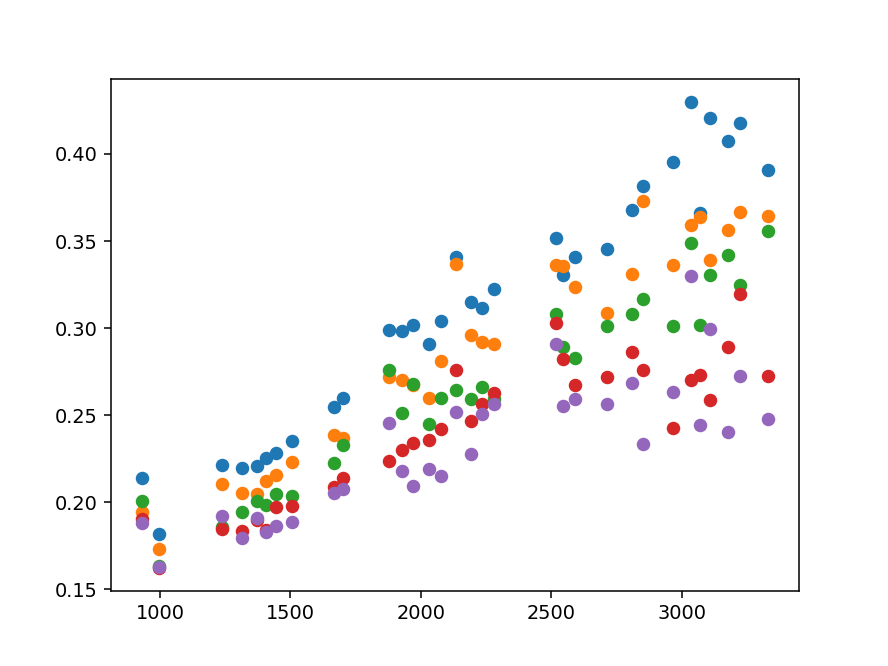

<IPython.core.display.Javascript object>


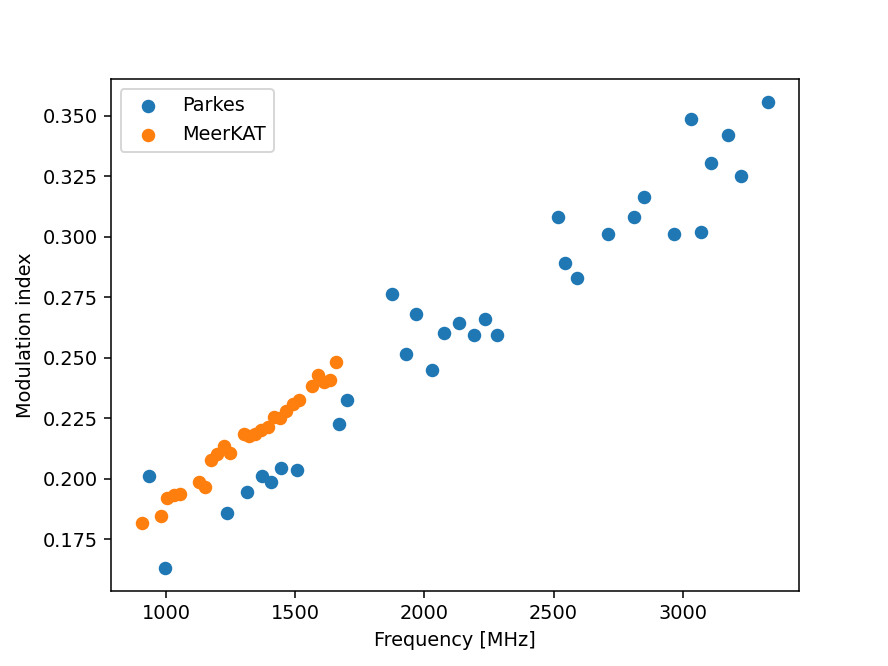

In [47]:
plt.figure()
for bins in np.arange(2,3):
    plt.scatter(Freq_Parkes,modIndex_Parkes[0,:,510+bins],label="Parkes")
    plt.scatter(Freq_MeerKAT,modIndex_MeerKAT[0,:,510+bins],label="MeerKAT")
plt.xlabel(r'Frequency [MHz]')
plt.ylabel(r'Modulation index')
plt.legend()

<IPython.core.display.Javascript object>


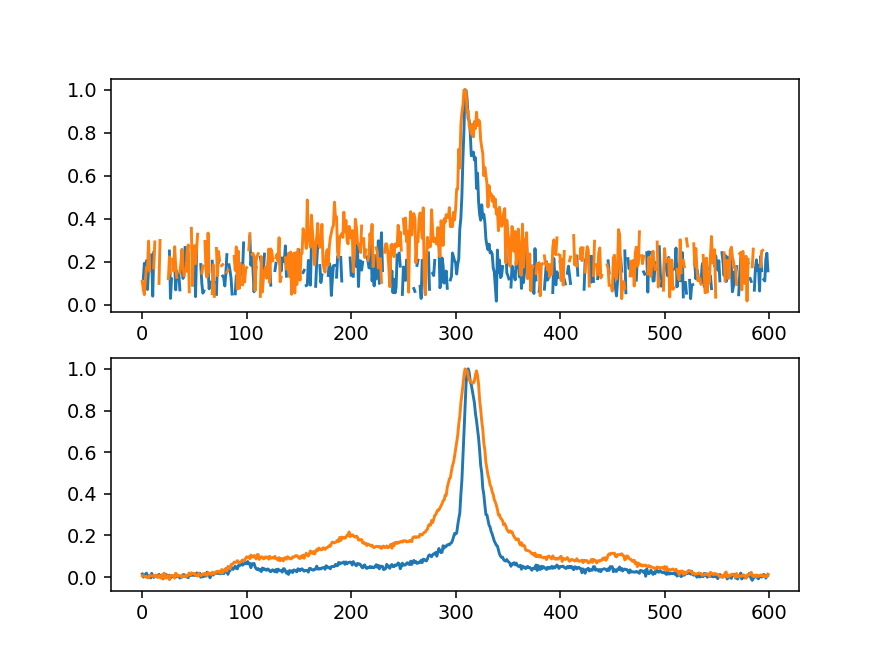

In [5]:
low=400
high=600
plt.figure()
plt.subplot(2,1,1)
plt.plot(modIndex[0,30]/np.nanmax(modIndex[0,30]))
plt.plot(modIndex[0,4]/np.nanmax(modIndex[0,4]))
plt.subplot(2,1,2)
plt.plot(np.mean(data[:,0,30,low-200:high+200],axis=0)/np.nanmax(np.mean(data[:,0,30,low-200:high+200],axis=0)))
plt.plot(np.mean(data[:,0,4,low-200:high+200],axis=0)/np.nanmax(np.mean(data[:,0,4,low-200:high+200],axis=0)))

### Calculatig Modulation index for other component of the pulse profile.

Hint that all the components of the pulse profile show frequency dependence of modulation index.
Here first we plot the modulation index of just the peak and later we plot the modulation index of sum over some bins.
Both show frequency dependence.

<IPython.core.display.Javascript object>


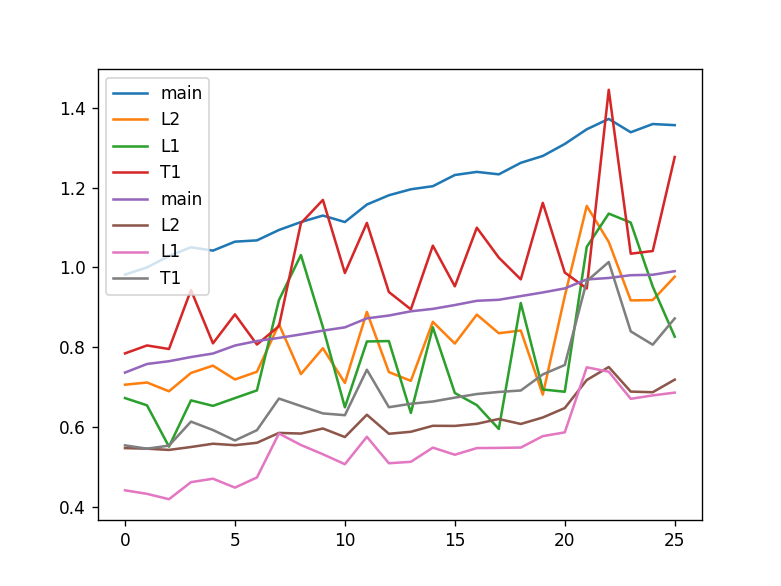

In [25]:
plt.figure()
plt.plot(modIndex[0,:,512],label='main')
plt.plot(modIndex[0,:,397],label='L2')
plt.plot(modIndex[0,:,306],label='L1')
plt.plot(modIndex[0,:,651],label='T1')
plt.legend()


modIndex_cum=np.ndarray([data.shape[2],4])
itr=0
pol=0
for comp in [512,397,306,651]:
    for freq in range(data.shape[2]):
        data_tmp=np.mean(data[:,pol,freq,comp-10:comp+10],axis=1)
        noise_tmp=np.mean(data[:,pol,freq,0:20],axis=1)
        modIndex_cum[freq,itr]=np.sqrt(np.var(data_tmp)-np.mean(np.var(noise_tmp)))/np.mean(data_tmp)
    itr+=1
    
plt.plot(modIndex_cum[:,0],label='main')
plt.plot(modIndex_cum[:,1],label='L2')
plt.plot(modIndex_cum[:,2],label='L1')
plt.plot(modIndex_cum[:,3],label='T1')
plt.legend()

<IPython.core.display.Javascript object>


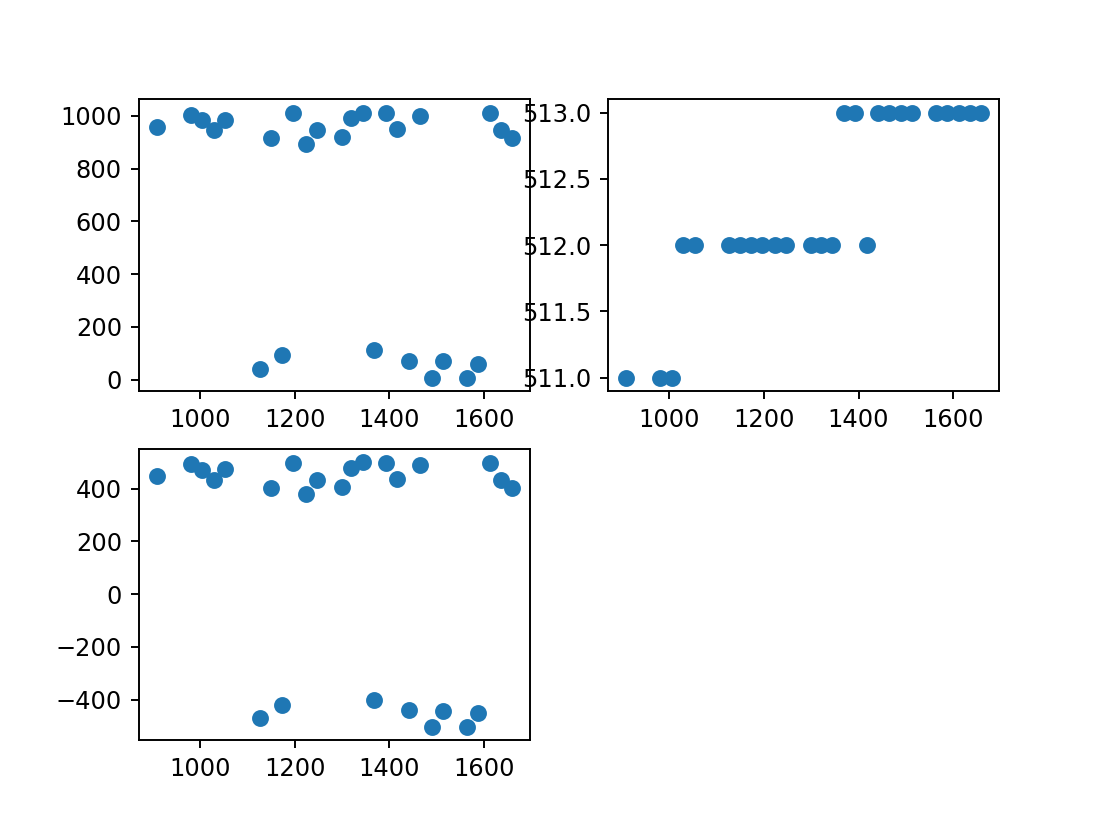

In [100]:
#chn=16
plt.figure()
diff=[]
for chn in range(modIndex.shape[1]):
    #plt.plot(modIndex[0,chn]/np.nanmax(modIndex[0,chn]))
    #plt.plot(np.mean(data[:,0,chn,low-350:high+350],axis=0)/np.nanmax(np.mean(data[:,0,chn,low-350:high+350],axis=0)))
    #diff.append(np.nanargmax(modIndex[0,chn]))
    #diff.append(np.nanargmax(np.mean(data[:,0,chn,low-350:high+350],axis=0)))
    diff.append(np.nanargmax(modIndex[0,chn])-np.nanargmax(np.mean(data[:,0,chn,0:1024],axis=0)))


plt.subplot(2,2,1)
#plt.plot(Freq_plot,modIndex_plot)
plt.scatter(Freq,np.nanargmax(modIndex[0,:],axis=1))
plt.subplot(2,2,2)
#plt.plot(Freq_plot,datamax_plot)
plt.scatter(Freq,np.nanargmax(np.mean(data[:,0,:,0:1024],axis=0),axis=1))
plt.subplot(2,2,3)
#plt.plot(Freq_plot,diff)
plt.scatter(Freq,diff)





### Calculating modulation Index from the pulse energy distributions.

(In the notebook we develop the code to compute the modulation index from pulse energies and implememnt it as a separate python code )

Using following statistics for estimating pulse energy distribution:

$$ S/N = \frac{\sum_{i=1}^{N_{window}} (A_{i} -B)}{\sqrt{N_{window}}\sigma_{off}}  $$

Here B is mean in the offpulse region.
Inorder to mitigate effect due to the dis-similar baselines in each frequency the mean has been subtracted.

In [4]:

def get_energies(datain,low,high):
    dim=datain.shape
    Ener_main_comp=np.ndarray([dim[0],dim[1],dim[2]])
    
    for subint in range(dim[0]):
        for pol in range(dim[1]):
            for freq in range(dim[2]):
                #mu=np.mean(datain[:,0,freq,0:100])
                #sig=np.std(datain[:,0,freq,0:100])
                Ener_main_comp[subint,pol,freq]=np.divide(np.sum(datain[subint,pol,freq,low:high]-np.mean(datain[subint,pol,freq,0:100])),np.multiply(np.sqrt(high-low),np.std(datain[subint,pol,freq,0:100])))
                #Ener_main_comp[subint,pol,freq]=np.divide(np.sum(datain[subint,0,freq,low:high]-mu),np.multiply(np.sqrt(high-low),sig))
    return Ener_main_comp

Energy_main_comp=get_energies(data,490,530)
Energy_noise=get_energies(data,900,940)


In [4]:
import copy

import numpy as np
from scipy.special import gammaln, xlogy
from scipy.stats import multivariate_normal

from bilby.core.utils import infer_parameters_from_function, infer_args_from_function_except_n_args

from bilby.core.likelihood import *

In [51]:
from scipy.signal import fftconvolve


def gaussian(x,mu_gs,sigma_gs):
    return np.exp((-1/2)*((x-mu_gs)/sigma_gs)**2)/(sigma_gs*np.sqrt(2*np.pi))

def log_normal(x,mu_ln,sigma_ln):
    out=np.ndarray(x.shape[0])
    for i in range(x.shape[0]):
        if x[i]<=0:
            out[i]=0  
        else:
            out[i]=(1/(x[i]*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x[i])-mu_ln)**2))
    return out

def get_prob_pulseEnergy(x,mu_ln,sigma_ln):
    start=x[0]
    stop=x[-1]
    n=x.shape[0]
    delta=(stop-start)/n
    x_conv=np.linspace(start-delta*(n/2),stop+delta*(n/2),num=2*n-1)
    dx=x[10]-x[9]
    #guss=gaussian(x,-0.03,1.23)
    guss=gaussian(np.arange(-16,16,dx),-0.03,1.23)
    #log_norm=log_normal(np.concatenate((np.arange(-16,0,dx),x)),mu_ln,sigma_ln)
    log_norm=log_normal(x,mu_ln,sigma_ln)
    
    return fftconvolve(log_norm,guss,'same')*dx#, x_conv

In [14]:
from scipy.signal import fftconvolve
class Pulse_Energies(object):
    def __init__(self,chn,mu_gs,sigma_gs):
        self.chn=chn
        self.mu_gs=mu_gs
        self.sigma_gs=sigma_gs
        
    def gaussian(self,x,mu_gs,sigma_gs):
        return np.exp((-1/2)*((x-mu_gs)/sigma_gs)**2)/(sigma_gs*np.sqrt(2*np.pi))

    def log_normal(self,x,mu_ln,sigma_ln):
        out=np.ndarray(x.shape[0])
        for i in range(x.shape[0]):
            if x[i]<=0:
                out[i]=0  
            else:
                out[i]=(1/(x[i]*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x[i])-mu_ln)**2))
        return out

    def get_prob_pulseEnergy(self,x,mu_ln,sigma_ln):
        start=x[0]
        stop=x[-1]
        n=x.shape[0]
        delta=(stop-start)/n
        x_conv=np.linspace(start-delta*(n/2),stop+delta*(n/2),num=2*n-1)
        dx=x[10]-x[9]
        #guss=gaussian(x,-0.03,1.23)
        guss=self.gaussian(np.arange(-16,16,dx),self.mu_gs,self.sigma_gs)
        #log_norm=log_normal(np.concatenate((np.arange(-16,0,dx),x)),mu_ln,sigma_ln)
        log_norm=self.log_normal(x,mu_ln,sigma_ln)

        return fftconvolve(log_norm,guss,'same')*dx#, x_conv

<IPython.core.display.Javascript object>


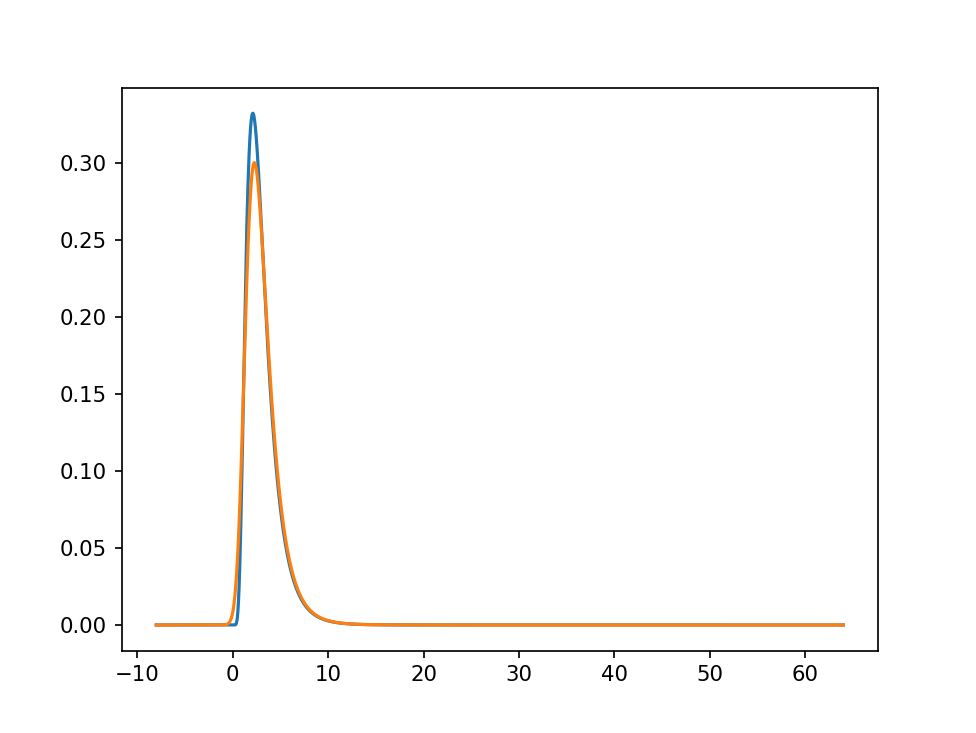

In [24]:
a=Pulse_Energies(0,0,0.5)
x_conv=np.arange(-8,64,(16)/1024)
conv=a.get_prob_pulseEnergy(x_conv,1,0.5)

plt.figure()
plt.plot(x_conv,(a.log_normal(x_conv,1,0.5)))
#plt.plot(np.arange(-8,8,16/1024),a.gaussian(np.arange(-8,8,16/1024),-0.03,1.23))
plt.plot(x_conv,conv)

For a likelihood function it was seen that along with the multinomial distribution on frequency of occurance of the pulse energies (i.e. NOT the probability density), the gaussian distribution for a probability density function can also be used. 

Here the multinomial definition is written


Multinomial likelihood with parameters to be defined from a function and the probabilities at each bin are calculated using a function

In [8]:
class Multinomial_Atharva(Analytical1DLikelihood):
    """
    Likelihood for system with N discrete possibilities.
    """

    def __init__(self, data, n_dimensions, func, label="parameter_"):
        """
        Parameters
        ==========
        data: array-like
            The number of objects in each class
        n_dimensions: int
            The number of classes
        """
        self.data = np.array(data)
        self._total = np.sum(self.data)
        #super(Multinomial_Atharva, self).__init__(dict())
        super(Multinomial_Atharva, self).__init__(x=n_dimensions, y=data, func=func)#, **kwargs)
        #self.n = n_dim
        self.label = label
        self._nll = None

    def log_likelihood(self):
#         """
#         Since n - 1 parameters are sampled, the last parameter is 1 - the rest
#         """
#         probs = [self.parameters[self.label + str(ii)]
#                  for ii in range(self.n - 1)]
#         probs.append(1 - sum(probs))
        #probs = self.func(self.x,self.parameters['mu_gs'],self.parameters['sigma_gs']) ##For gaussian noise
        probs = self.func(self.x,self.parameters['mu_ln'],self.parameters['sigma_ln']) ## For energies
        return self._multinomial_ln_pdf(probs=probs)

#     def noise_log_likelihood(self):
#         """
#         Our null hypothesis is that all bins have probability 1 / nbins, i.e.,
#         no bin is preferred over any other.
#         """
#         if self._nll is None:
#             self._nll = self._multinomial_ln_pdf(probs=1 / self.n)
#         return self._nll

    def _multinomial_ln_pdf(self, probs):
        """Lifted from scipy.stats.multinomial._logpdf"""
        ln_prob = gammaln(self._total + 1) + np.sum(
            xlogy(self.data, probs) - gammaln(self.data + 1), axis=-1)
        return ln_prob

Using method given in bilby documentation to fit for a gaussian to data.

class SimpleGaussianLikelihood(Likelihood):
    def __init__(self, data):
        """
        A very simple Gaussian likelihood

        Parameters
        ----------
        data: array_like
            The data to analyse
        """
        super().__init__(parameters={"mu": None, "sigma": None})
        self.data = data
        self.N = len(data)

    def log_likelihood(self):
        mu = self.parameters["mu"]
        sigma = self.parameters["sigma"]
        res = self.data - mu
        return -0.5 * (
            np.sum((res / sigma) ** 2) + self.N * np.log(2 * np.pi * sigma**2)
        )
#data = np.random.normal(3, 4, 100)
outdir=outdir = "/home/akulkarn/notebooks/bibly_results_NoiseEnergy_Dist/"
label='label'
likelihood = SimpleGaussianLikelihood(Energy_noise[:,0,10])
priors = dict(
    mu=bilby.core.prior.Uniform(-10, 10, "mu"),
    sigma=bilby.core.prior.Uniform(0, 15, "sigma"),
)

#And run sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1000,
    outdir=outdir,
    label=label,
    clean=True
)
result.plot_corner()


##### Running first for the off pulse distribution which is expected to be gaussian (due to Centrsl Limit Theorem)

In [32]:
likelihood = Multinomial_Atharva(noise_hist,noise_bin[0:-1],gaussian)
#likelihood = bilby.likelihood.GaussianLikelihood(noise_hist,noise_bin[0:-1],gaussian)#, <sigma>)

priors=dict()
priors["mu_gs"] = bilby.core.prior.Uniform(-3, 3, "mu_gs")
priors["sigma_gs"] = bilby.core.prior.Uniform(-3, 3, "sigma_gs")
#priors["A"] = bilby.core.prior.Uniform(0, 50, "A")
#priors["sigma"] = bilby.core.prior.Uniform(0, 0.1, "sigma")

11:59 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bibly_results_NoiseEnergy_Dist/'
11:59 bilby INFO    : Search parameters:
11:59 bilby INFO    :   mu_gs = Uniform(minimum=-3, maximum=3, name='mu_gs', latex_label='mu_gs', unit=None, boundary=None)
11:59 bilby INFO    :   sigma_gs = Uniform(minimum=-3, maximum=3, name='sigma_gs', latex_label='sigma_gs', unit=None, boundary=None)
11:59 bilby INFO    : Single likelihood evaluation took 8.354e-05 s


0it [00:00, ?it/s]

11:59 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff20c50d3d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
11:59 bilby INFO    : Checkpoint every check_point_delta_t = 600s
11:59 bilby INFO    : Using dynesty version 1.0.1
11:59 bilby INFO    : Using the bilby-implemented rw

<IPython.core.display.Javascript object>


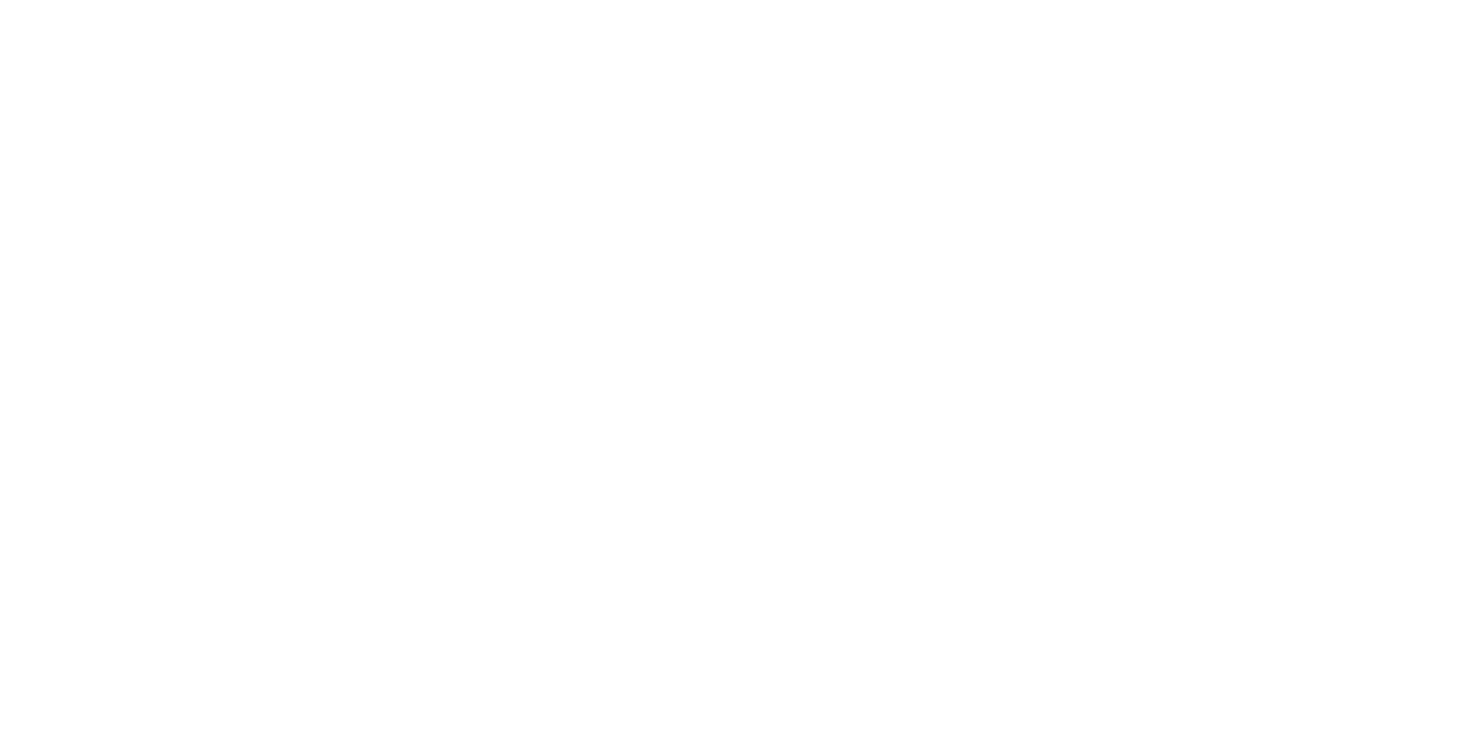

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


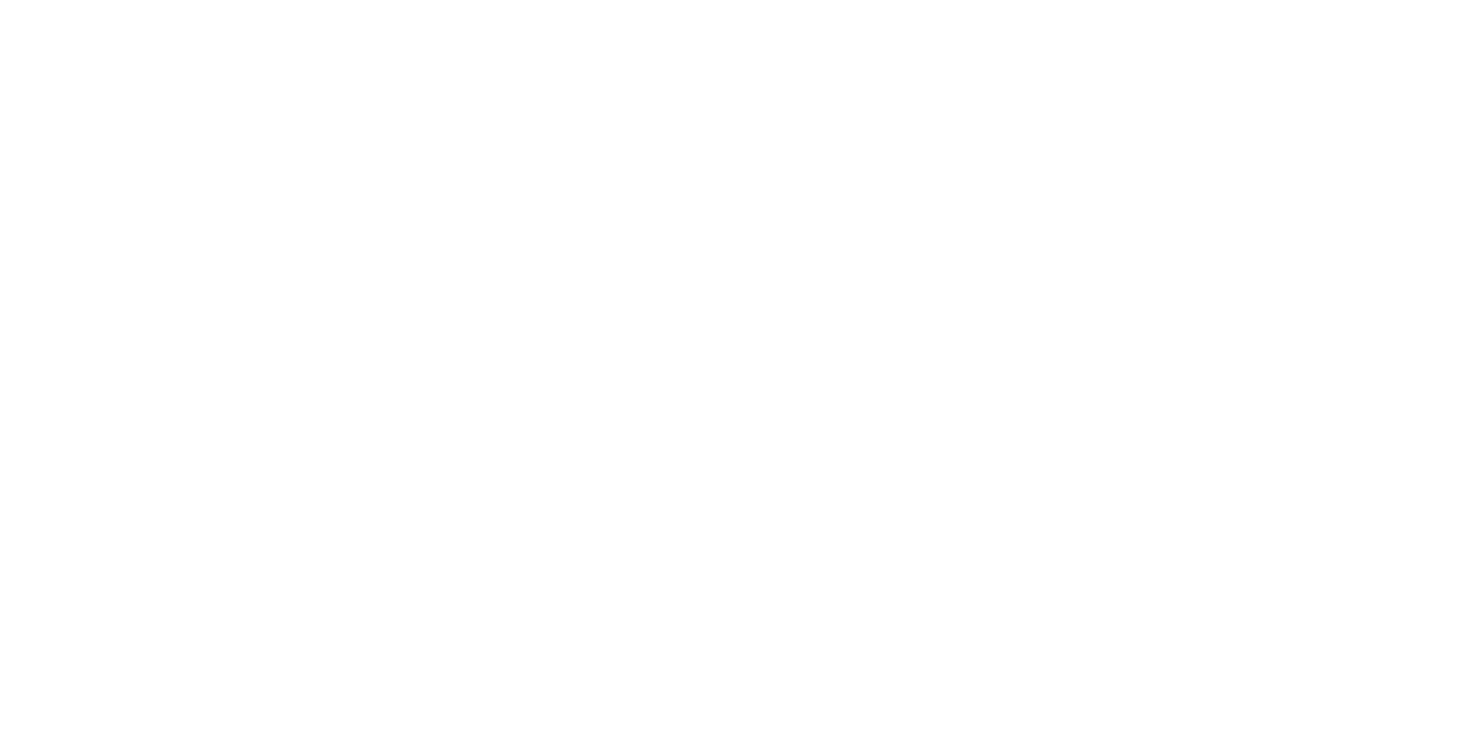

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


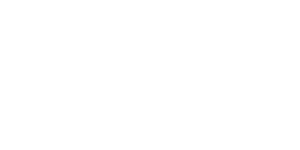

11:59 bilby WARNING : Axis limits cannot be NaN or Inf
11:59 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


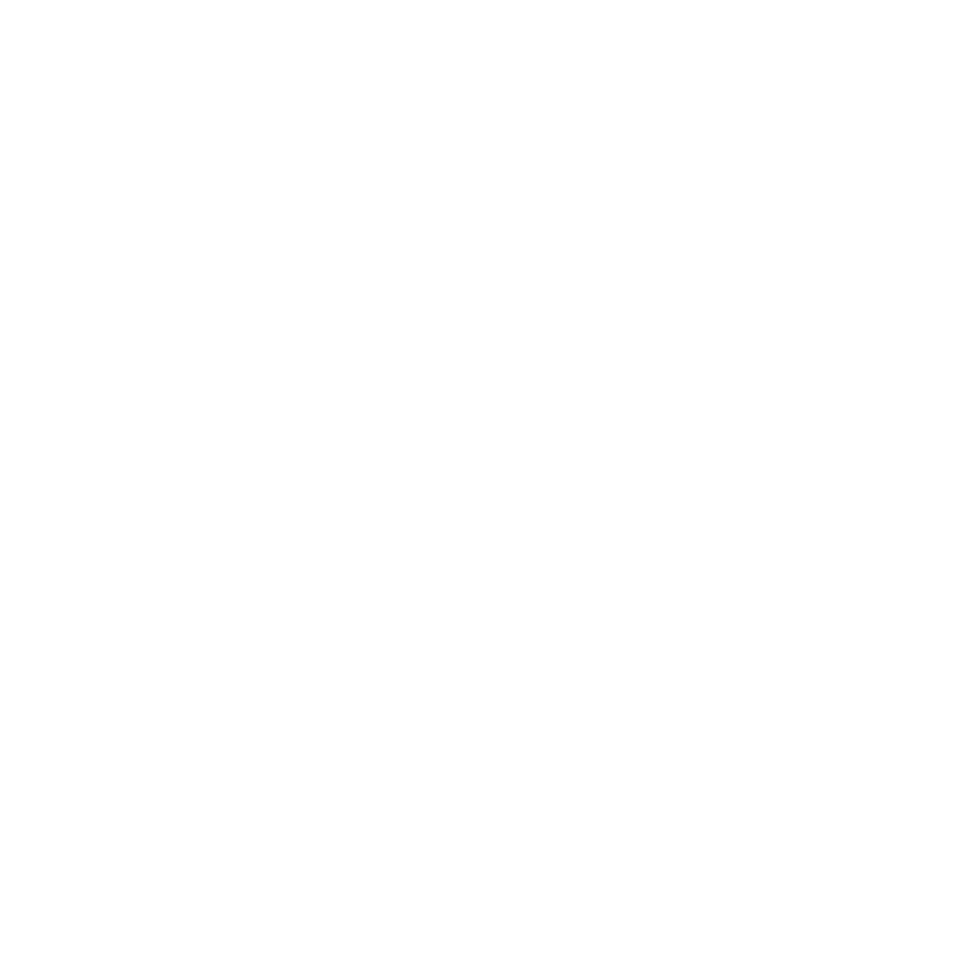

12:00 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_NoiseEnergy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


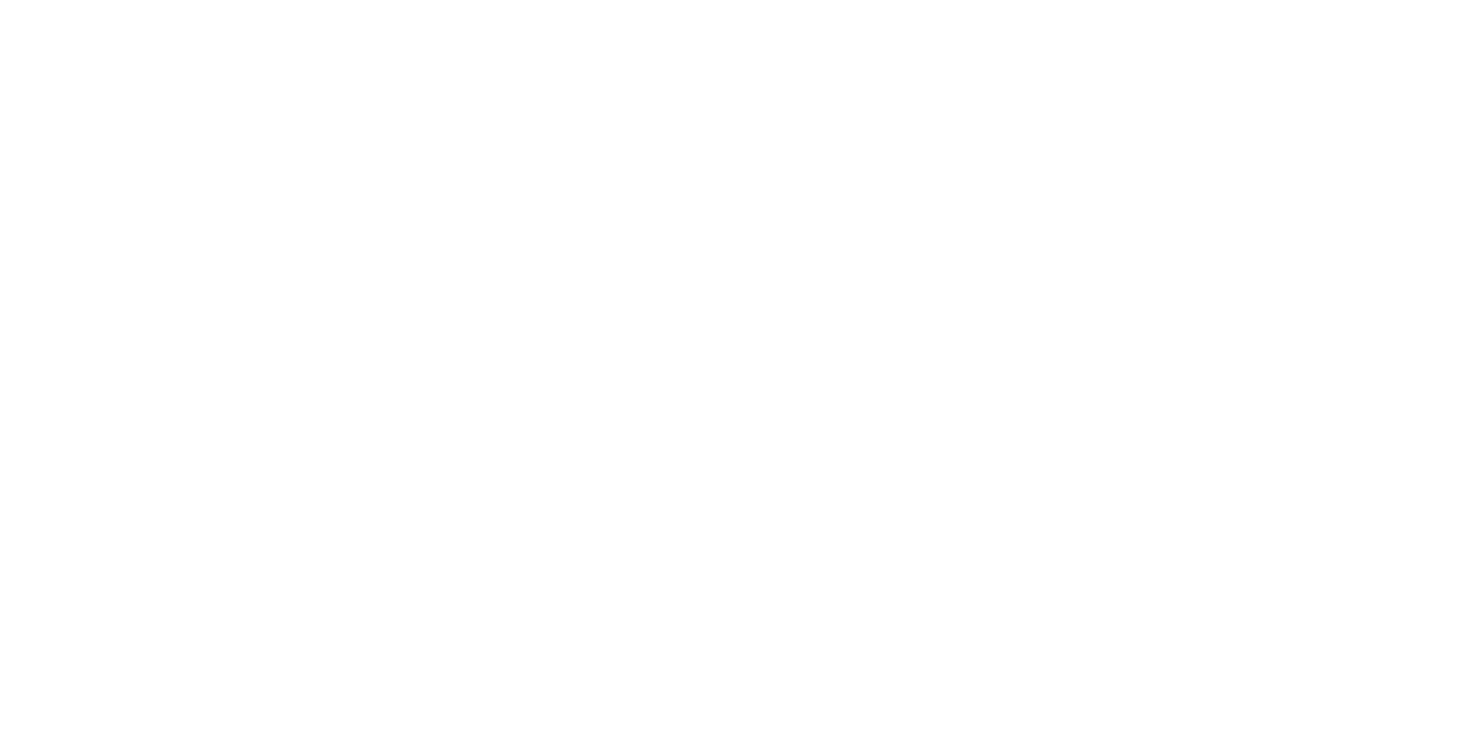

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


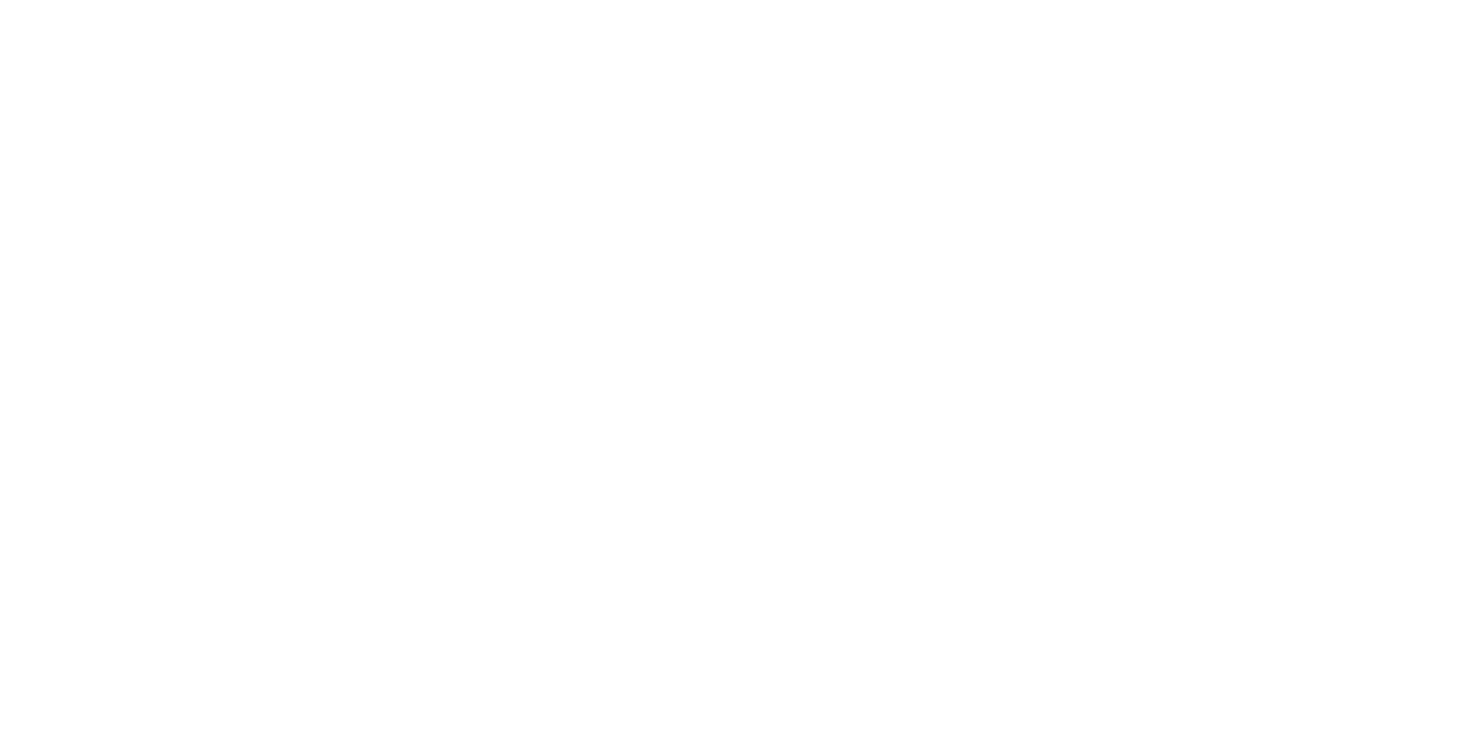

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


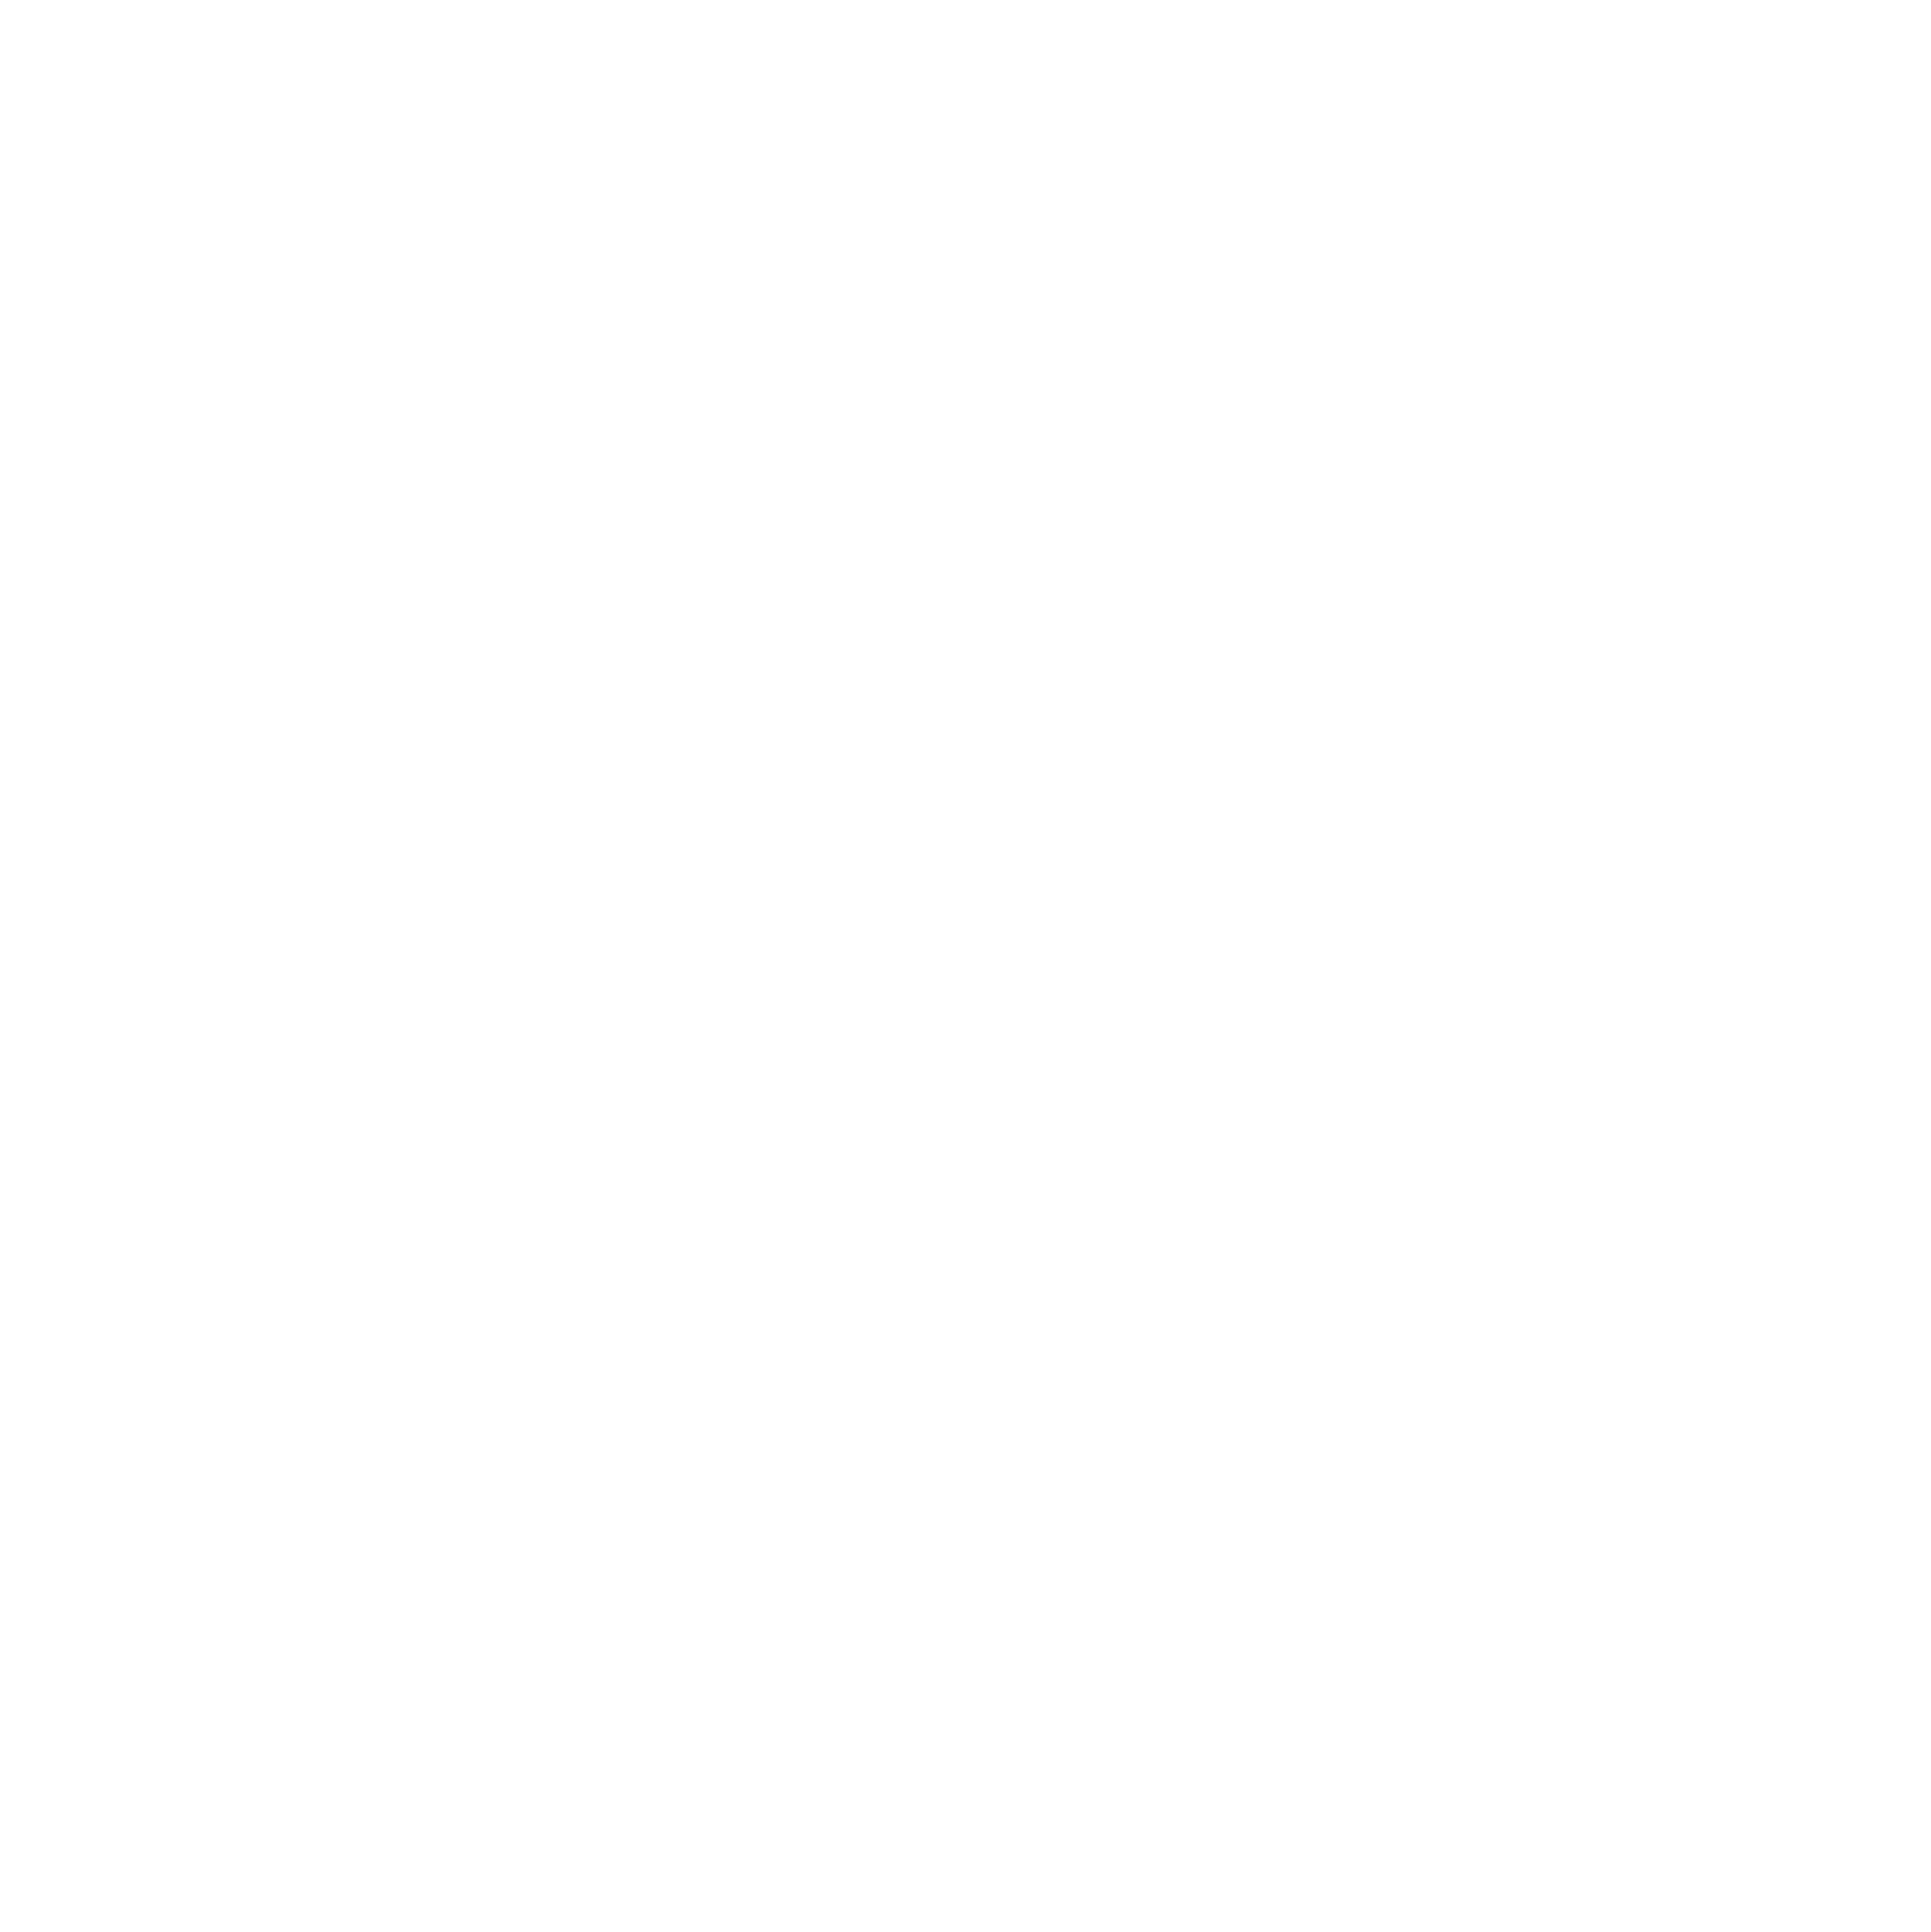

12:00 bilby WARNING : Axis limits cannot be NaN or Inf
12:00 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


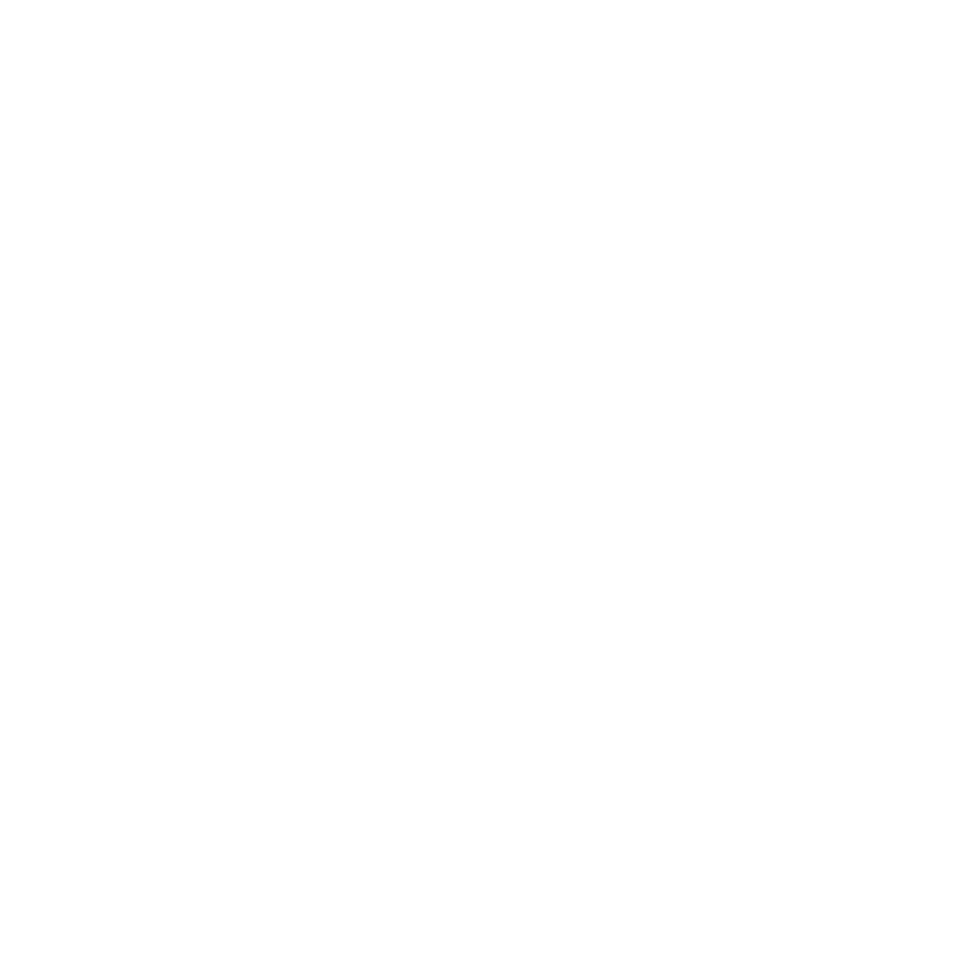

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
12:00 bilby INFO    : Sampling time: 0:00:46.747571


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
12:01 bilby INFO    : Summary of results:
nsamples: 2875
ln_noise_evidence:    nan
ln_evidence: 3315.841 +/-  0.238
ln_bayes_factor:    nan +/-  0.238



<IPython.core.display.Javascript object>


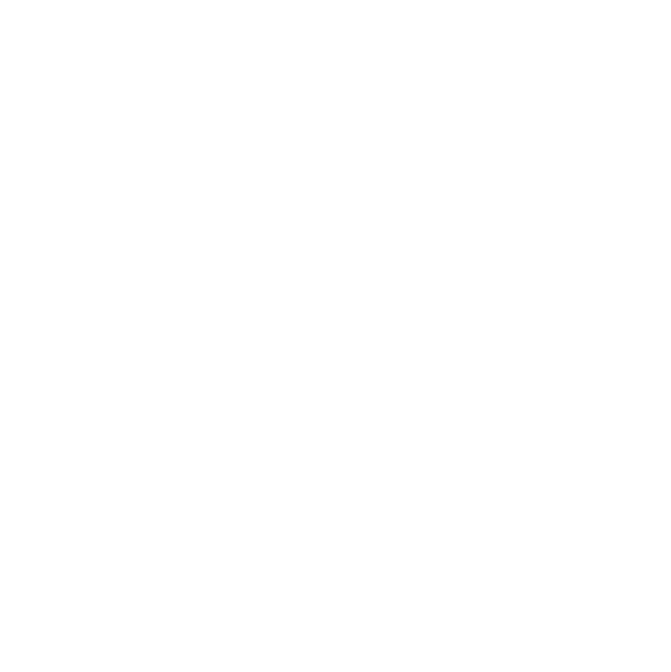

<IPython.core.display.Javascript object>


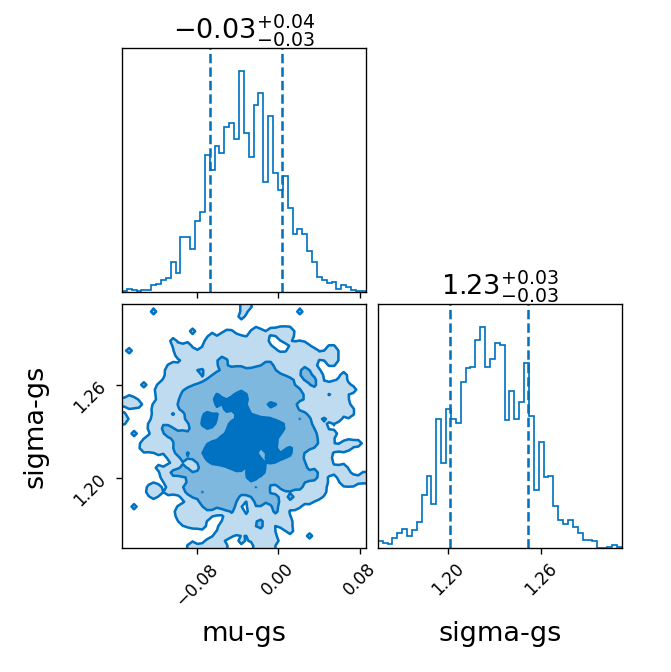

In [33]:
outdir=outdir = "/home/akulkarn/notebooks/bibly_results_NoiseEnergy_Dist/"

result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True
    )
result.plot_corner()

<IPython.core.display.Javascript object>


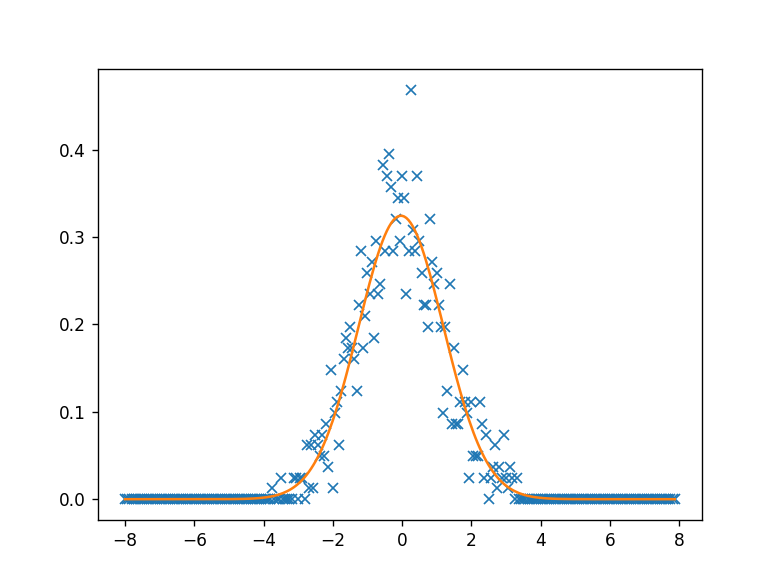

In [34]:
plt.figure()
plt.plot(noise_bin[0:-1],np.histogram(Energy_noise[:,0,10],bins=np.arange(-8,8,16/256),density=True)[0],'x',label='noise_hist')

plt.plot(noise_bin[0:-1],(gaussian(noise_bin[0:-1],-0.03,1.23)),label='fitted gaussian')


##### Now running for the actual pulse energy distribution

In [46]:
#likelihood = Multinomial_Atharva(energy_hist,energy_bin[0:-1],get_prob_pulseEnergy)
likelihood = bilby.likelihood.GaussianLikelihood(energy_bin[0:-1], energy_hist, get_prob_pulseEnergy)#, <sigma>)
priors=dict()
priors["mu_ln"] = bilby.core.prior.Uniform(0, 10, "mu_ln")
priors["sigma_ln"] = bilby.core.prior.Uniform(0, 2, "sigma_ln")
priors["sigma"] = bilby.core.prior.Uniform(0, 10, "sigma")

13:51 bilby INFO    : Running for label 'label', output will be saved to '/home/akulkarn/notebooks/bibly_results_Energy_Dist/'
13:51 bilby INFO    : Search parameters:
13:51 bilby INFO    :   mu_ln = Uniform(minimum=0, maximum=10, name='mu_ln', latex_label='mu_ln', unit=None, boundary=None)
13:51 bilby INFO    :   sigma_ln = Uniform(minimum=0, maximum=2, name='sigma_ln', latex_label='sigma_ln', unit=None, boundary=None)
13:51 bilby INFO    :   sigma = Uniform(minimum=0, maximum=10, name='sigma', latex_label='sigma', unit=None, boundary=None)
13:51 bilby INFO    : Single likelihood evaluation took 6.149e-03 s


0it [00:00, ?it/s]

13:51 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'print_progress': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 250, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 150, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7ff1ee4c5610>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
13:51 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:51 bilby INFO    : Using dynesty version 1.0.1
13:51 bilby INFO    : Using the bilby-implemented rw

<IPython.core.display.Javascript object>


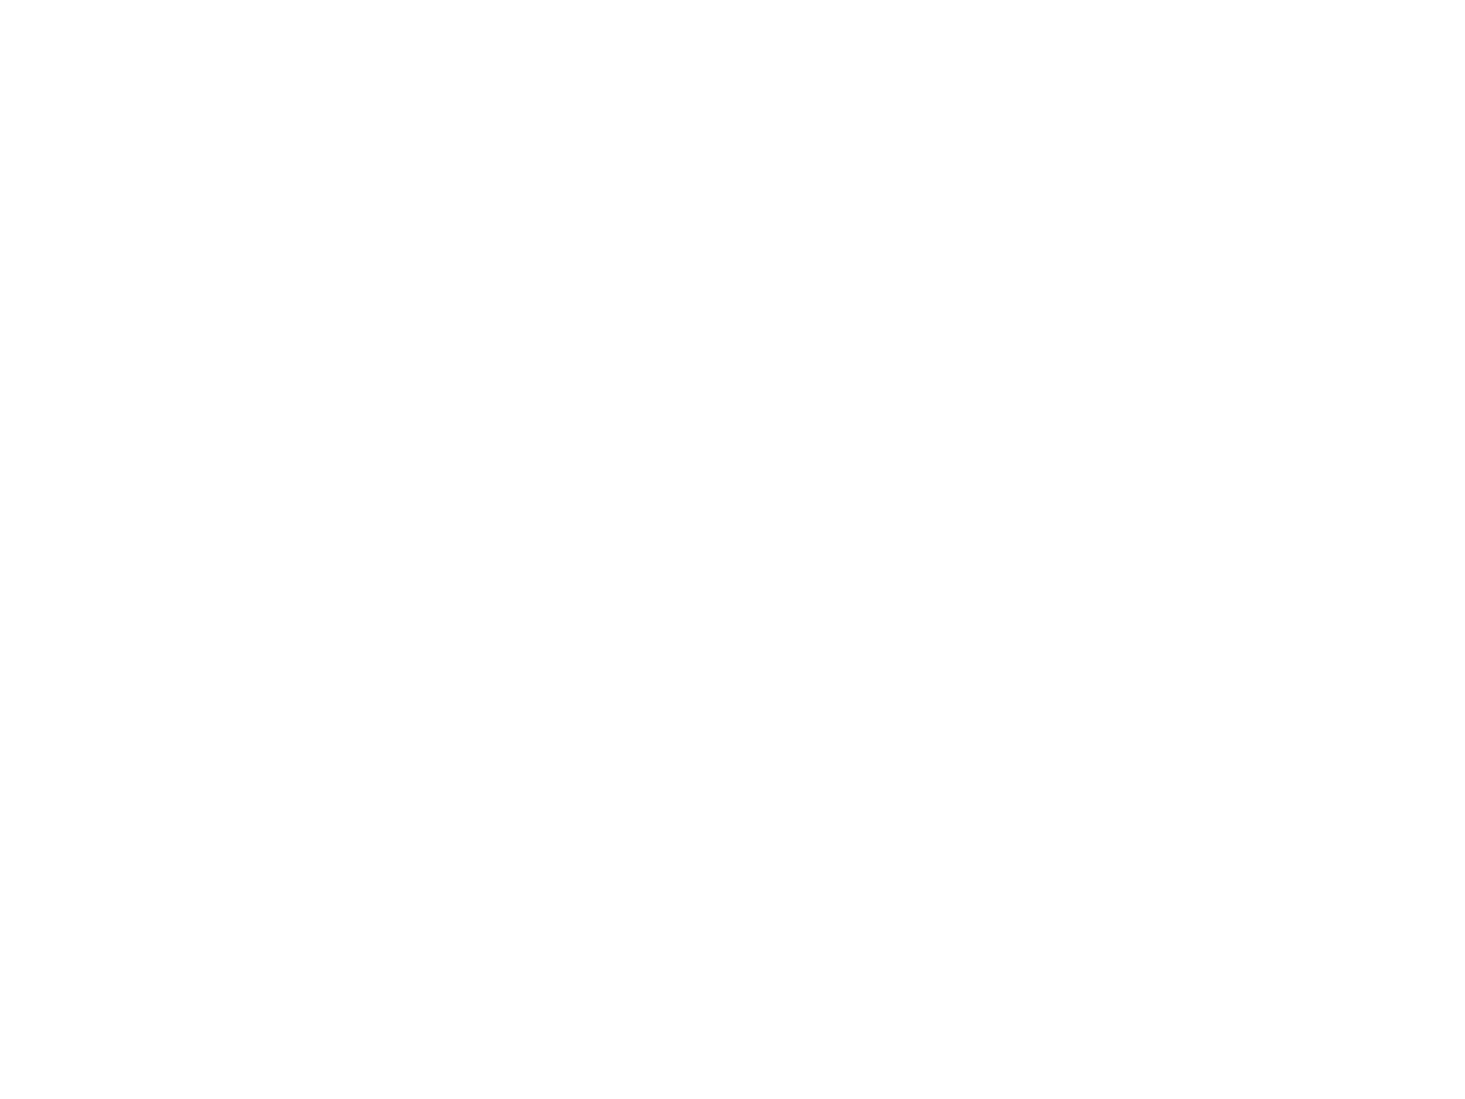

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


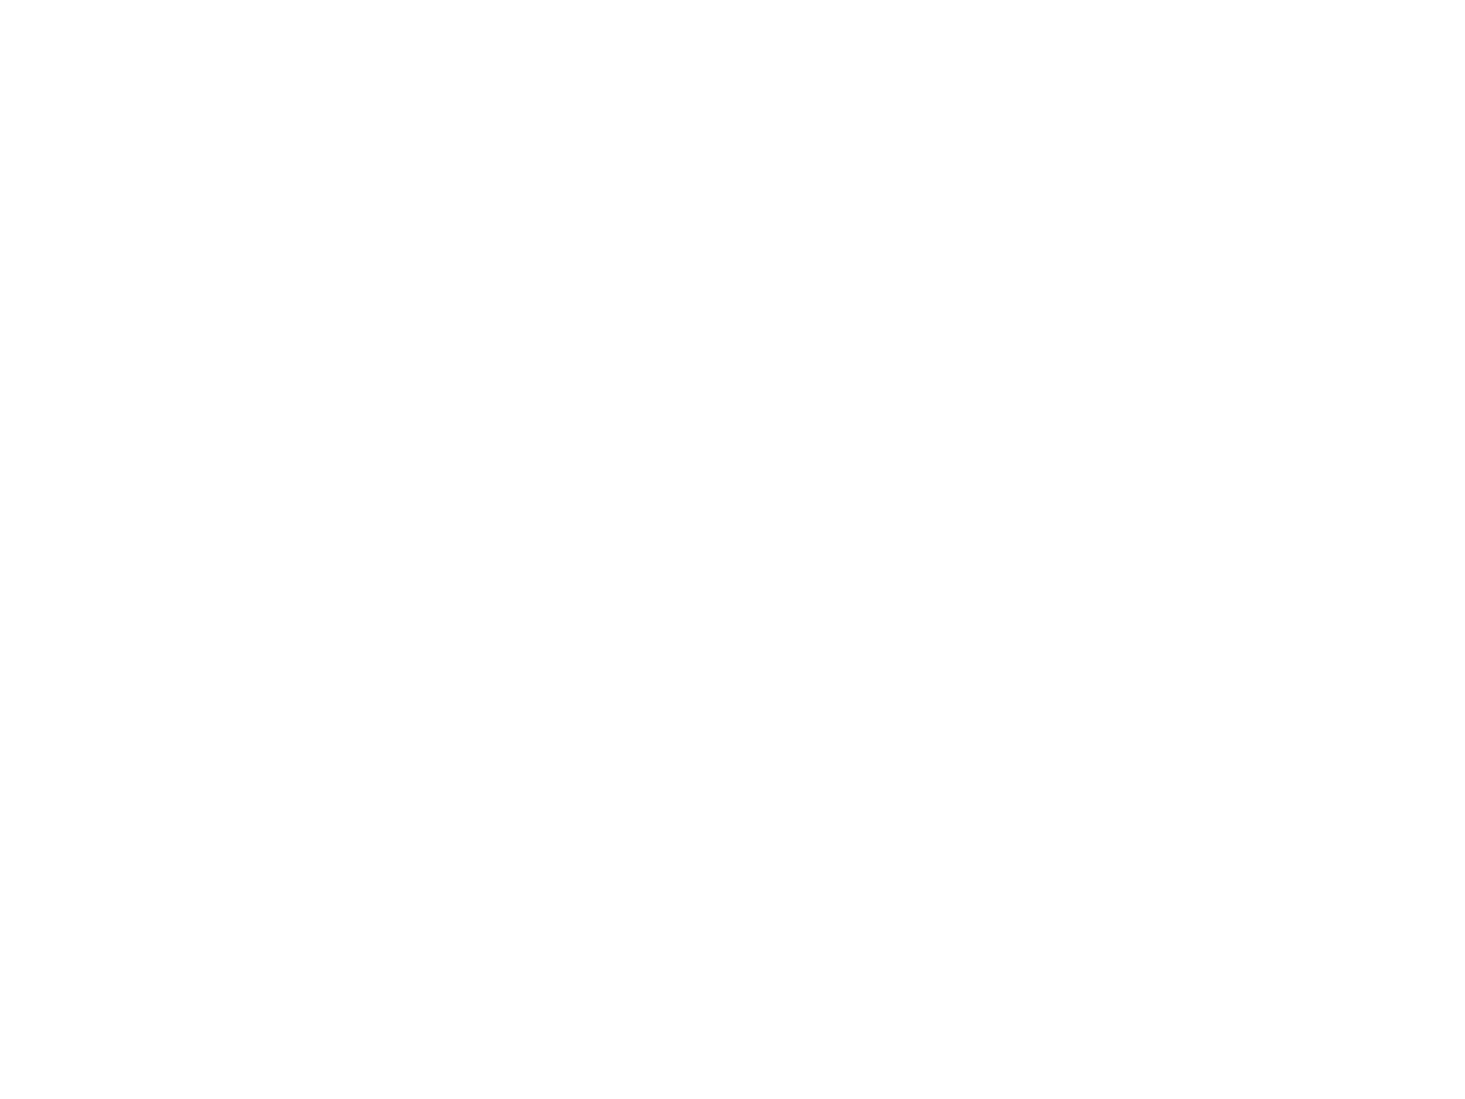

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

<IPython.core.display.Javascript object>


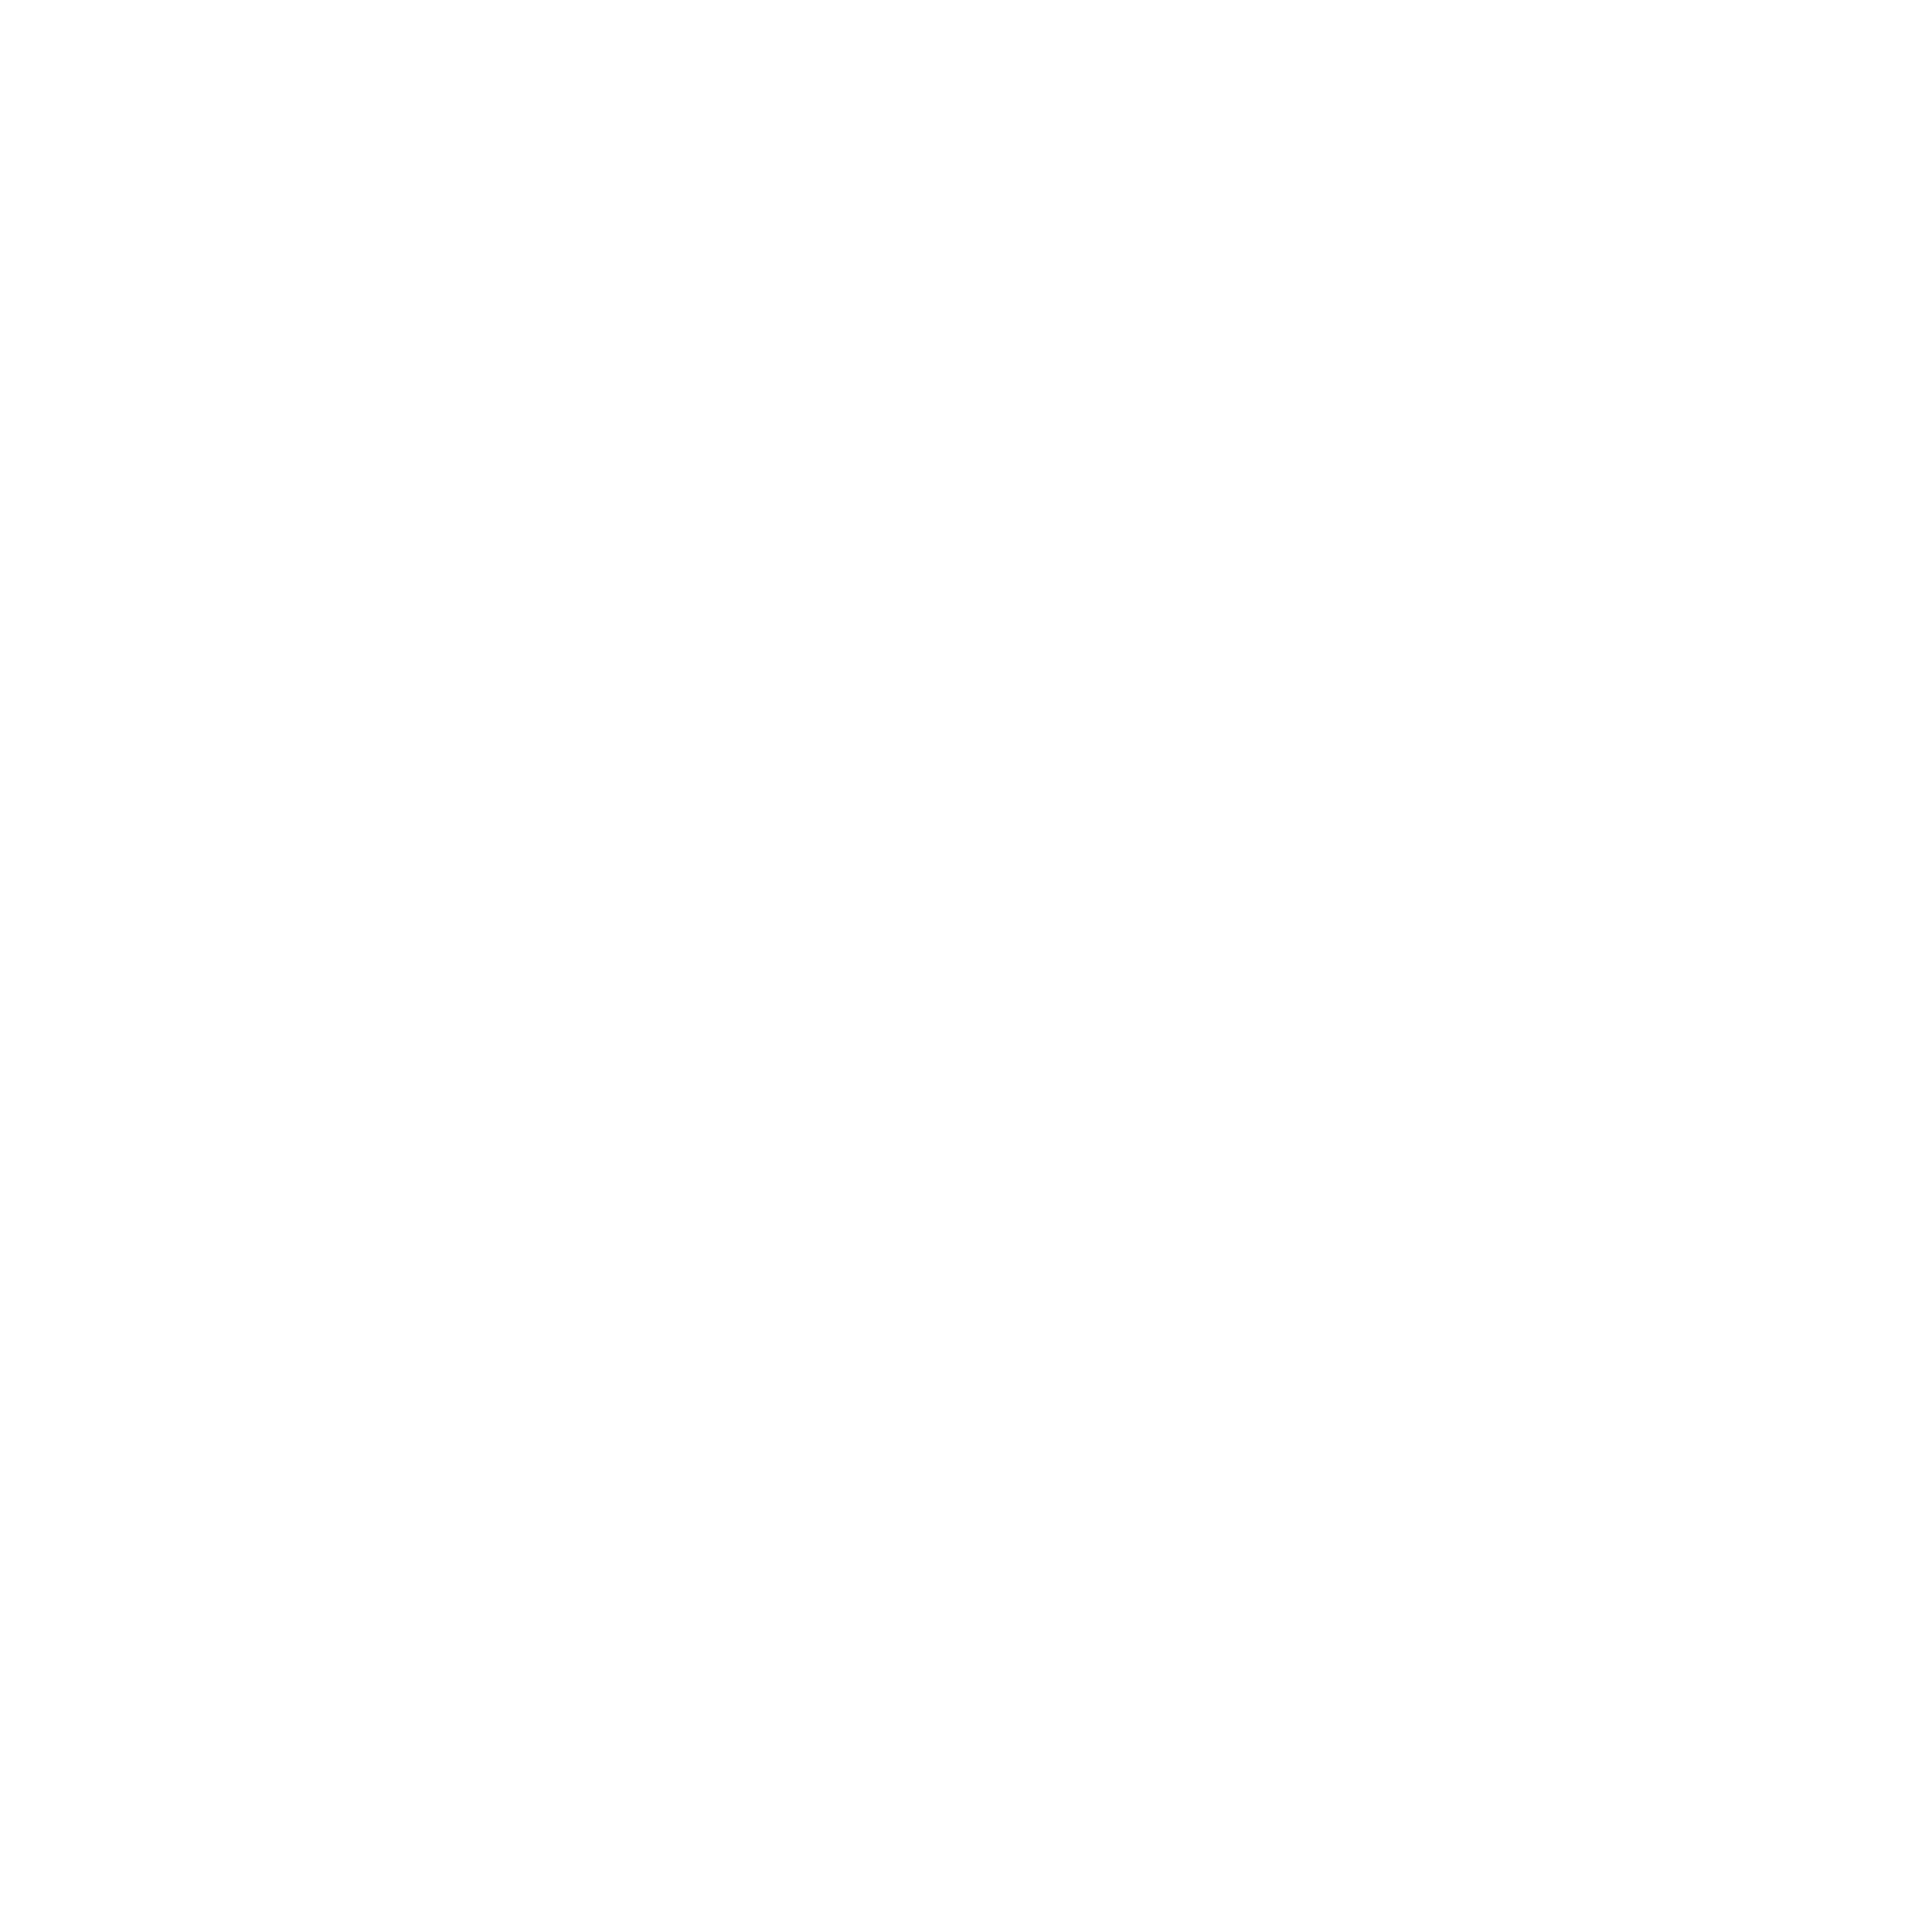

14:00 bilby WARNING : Axis limits cannot be NaN or Inf
14:00 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


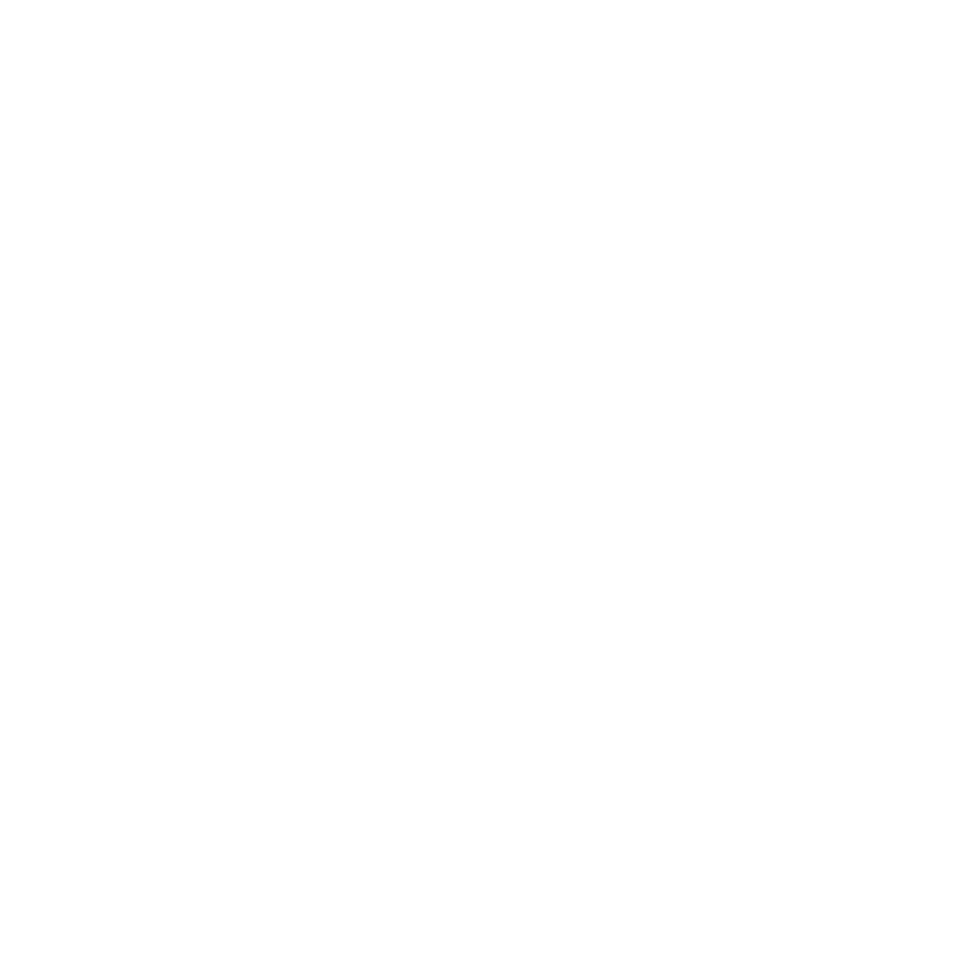

14:10 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


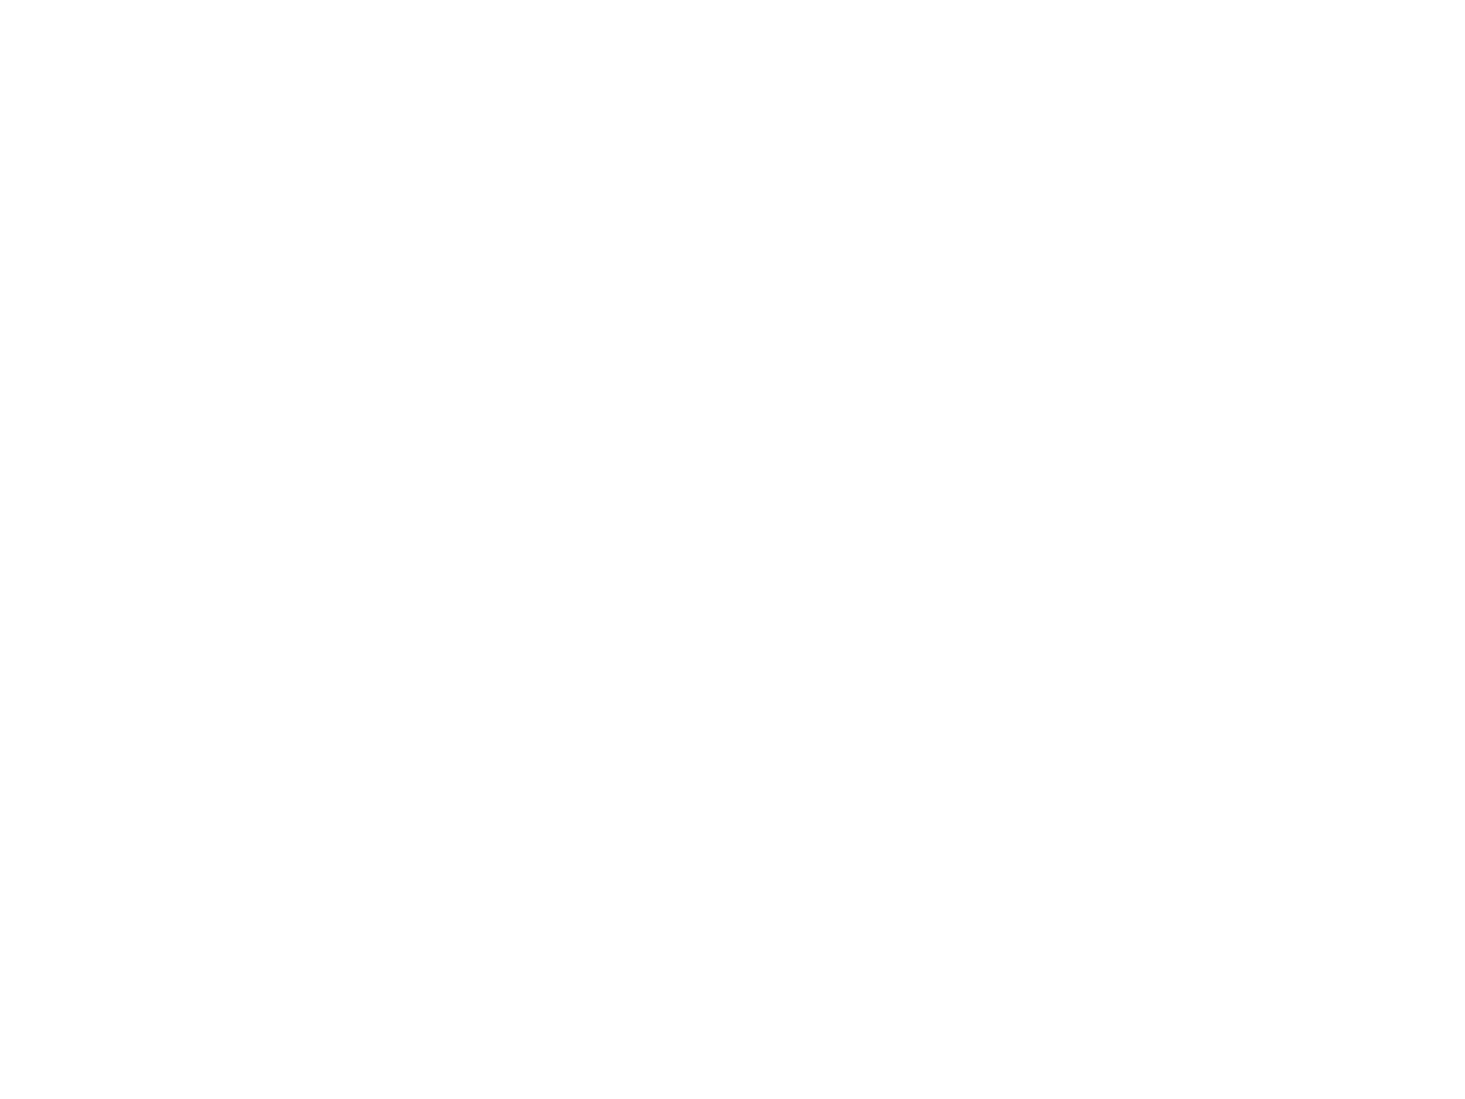

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


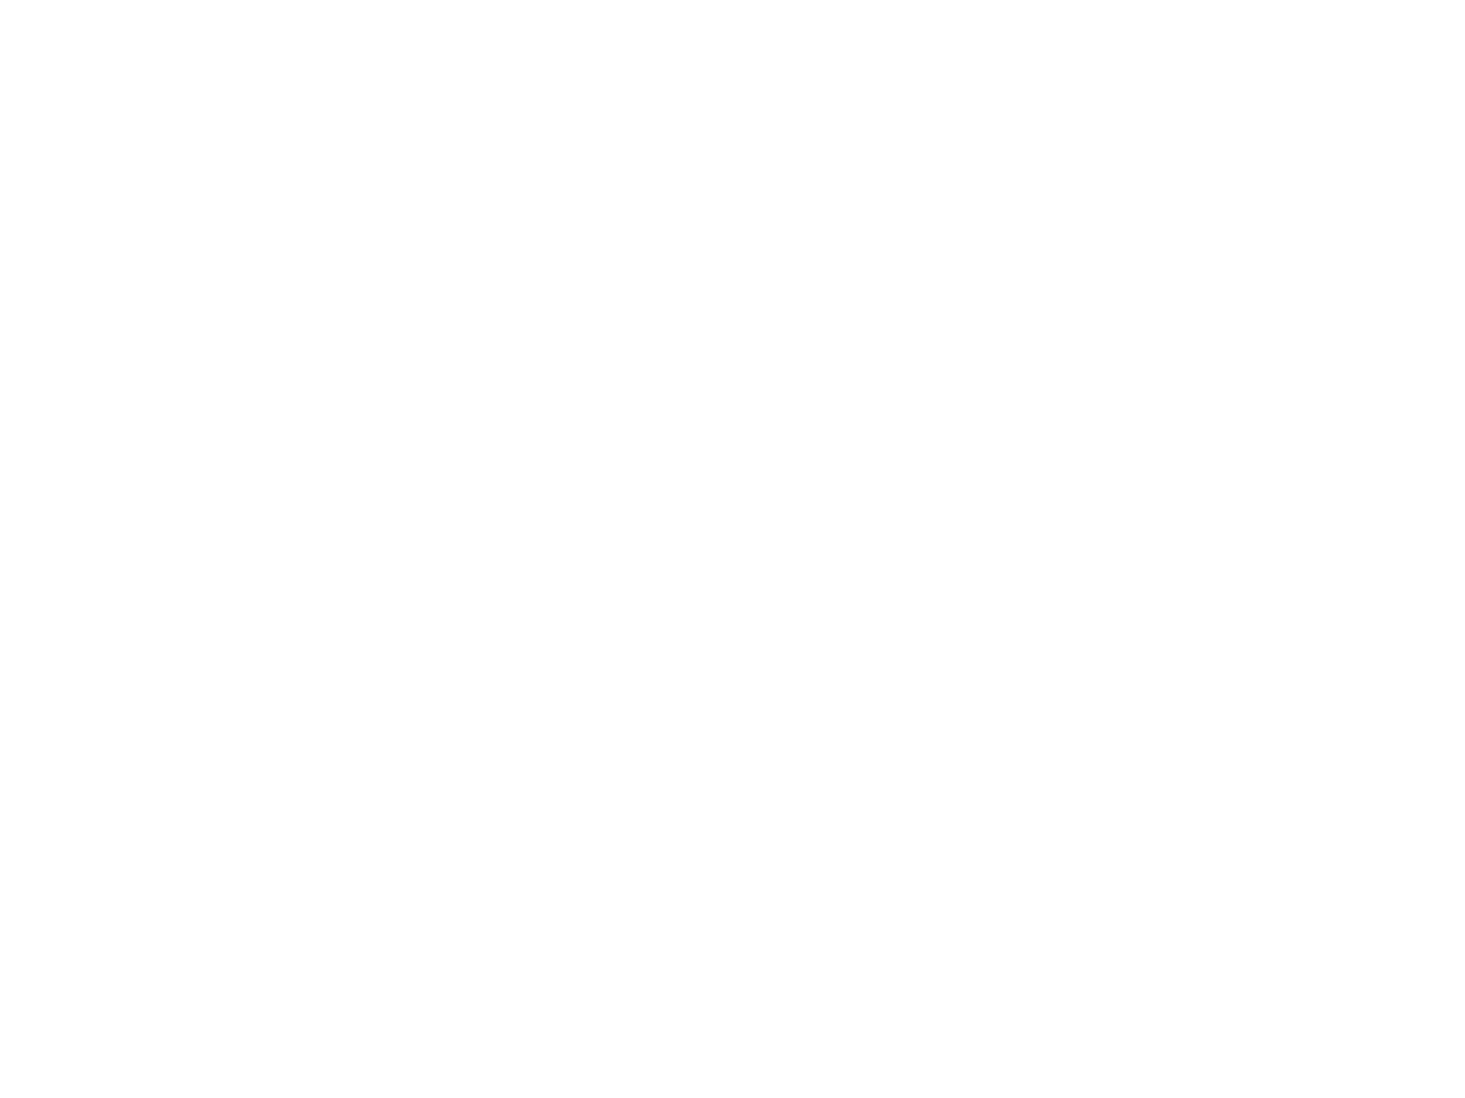

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:675: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

<IPython.core.display.Javascript object>


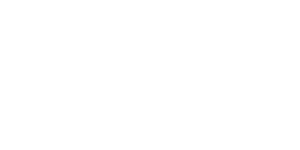

14:10 bilby WARNING : Axis limits cannot be NaN or Inf
14:10 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


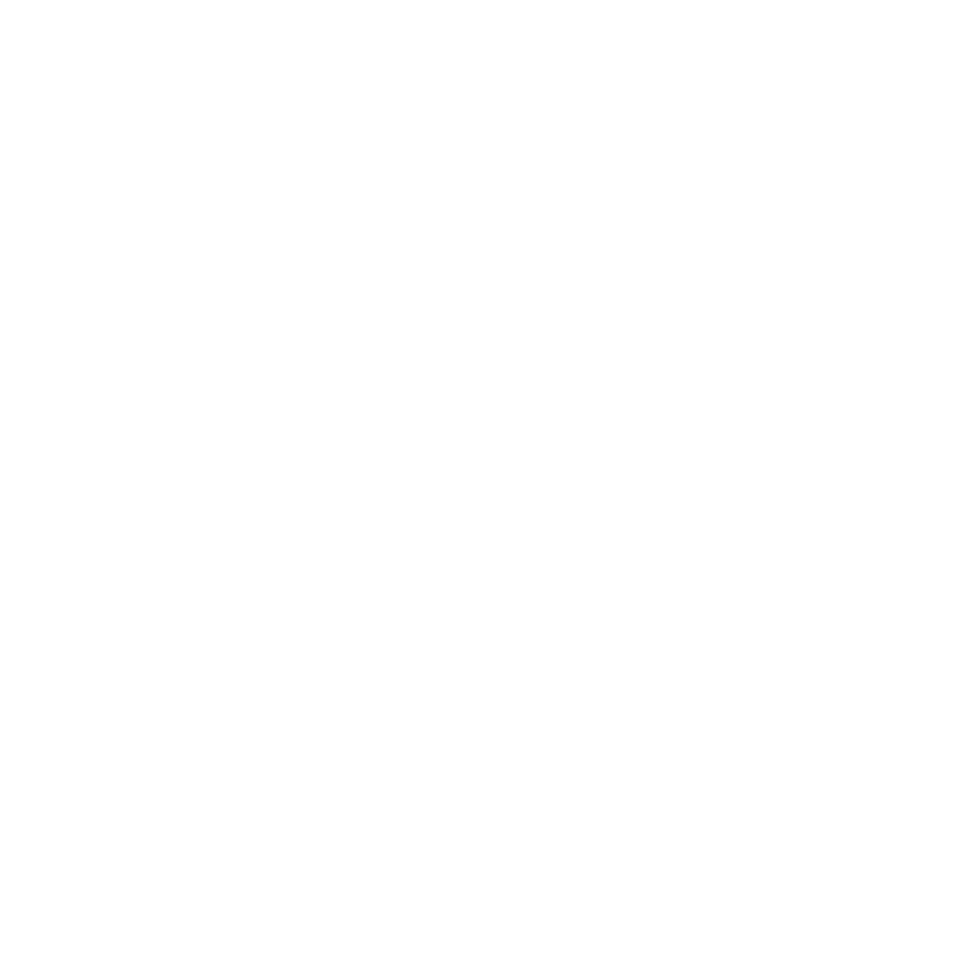

14:20 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


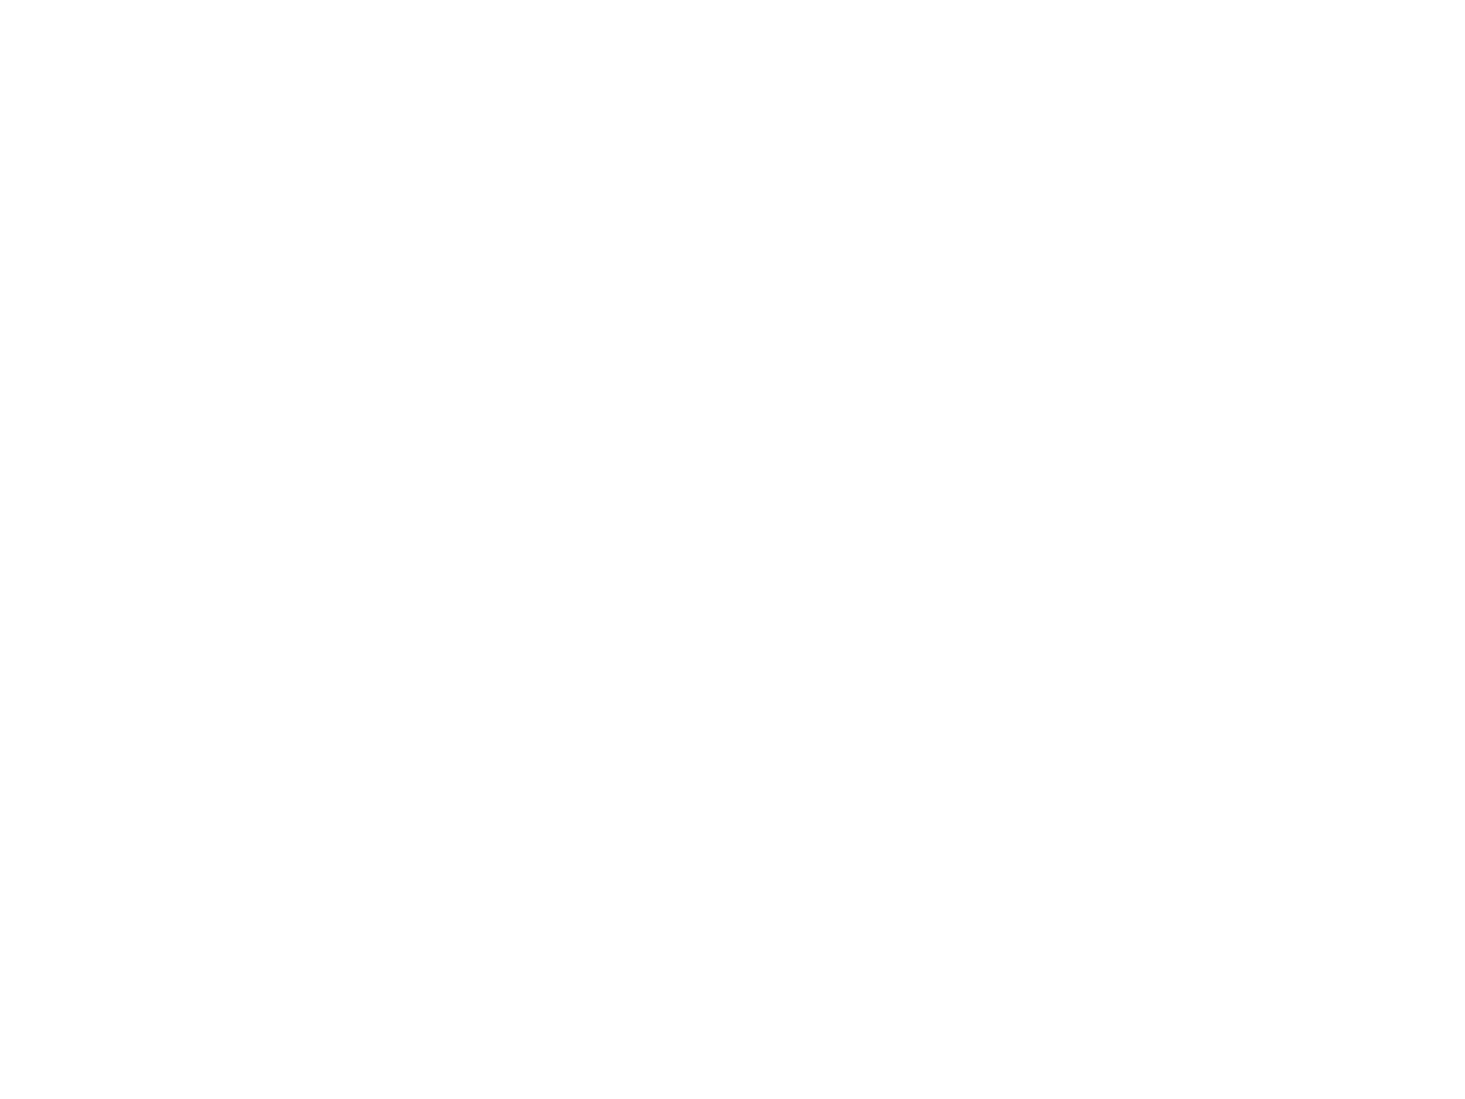

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


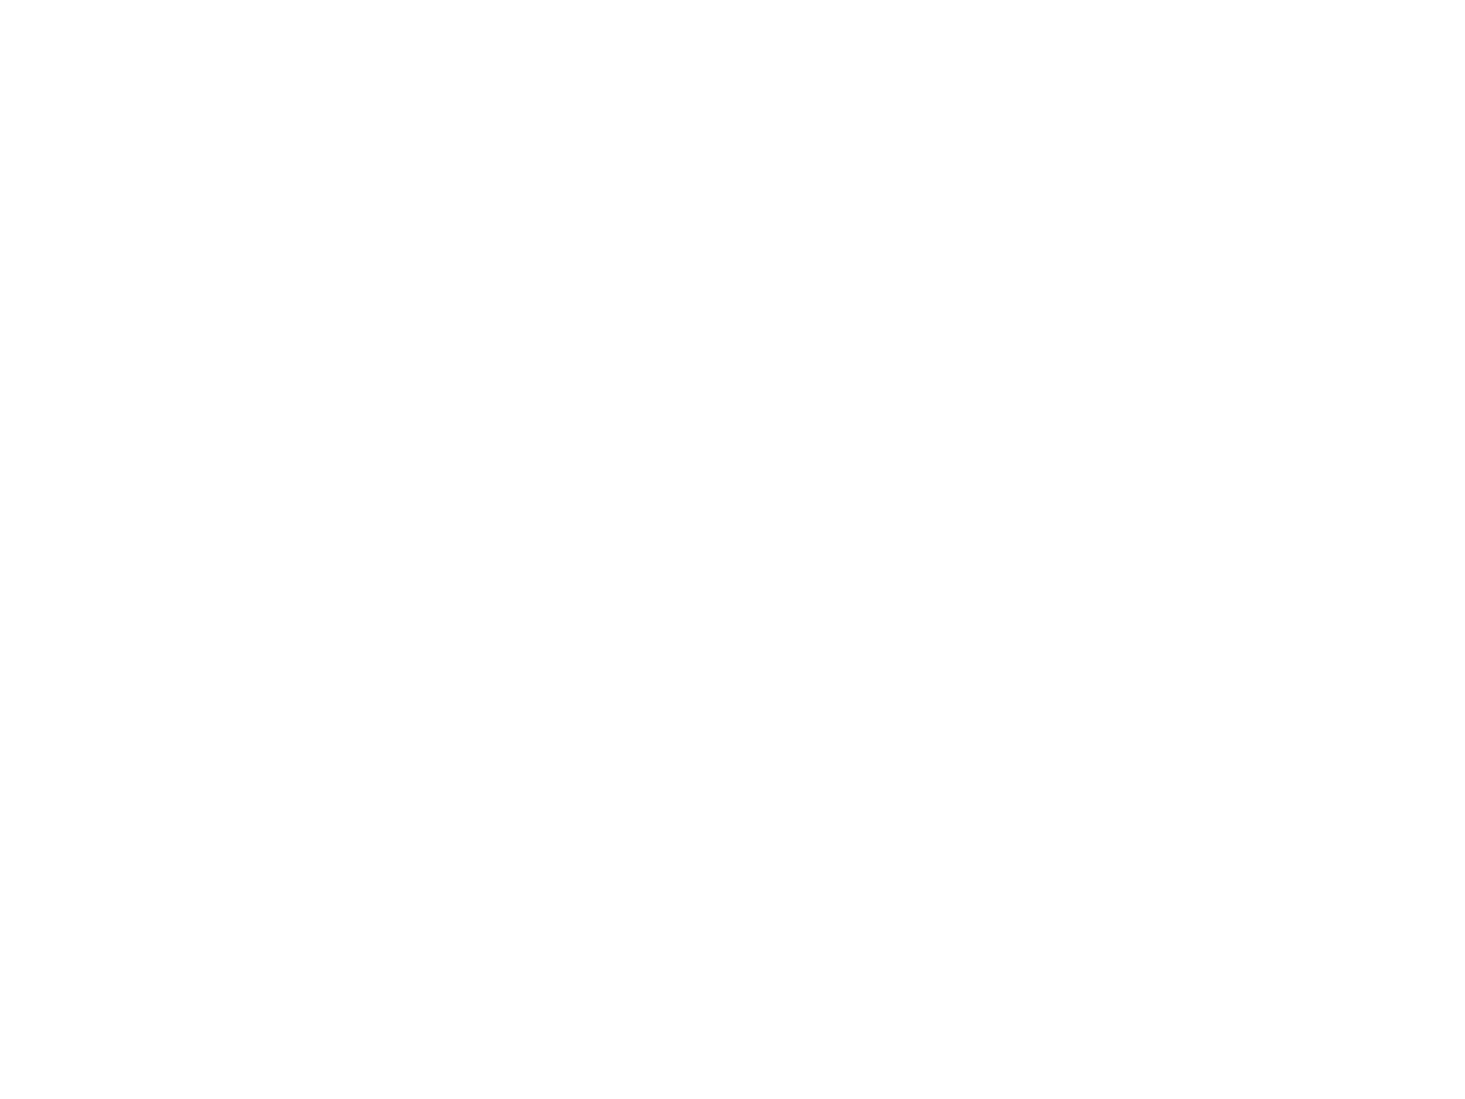

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


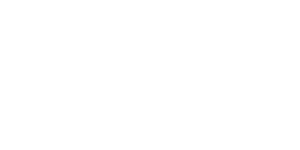

14:20 bilby WARNING : Axis limits cannot be NaN or Inf
14:20 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


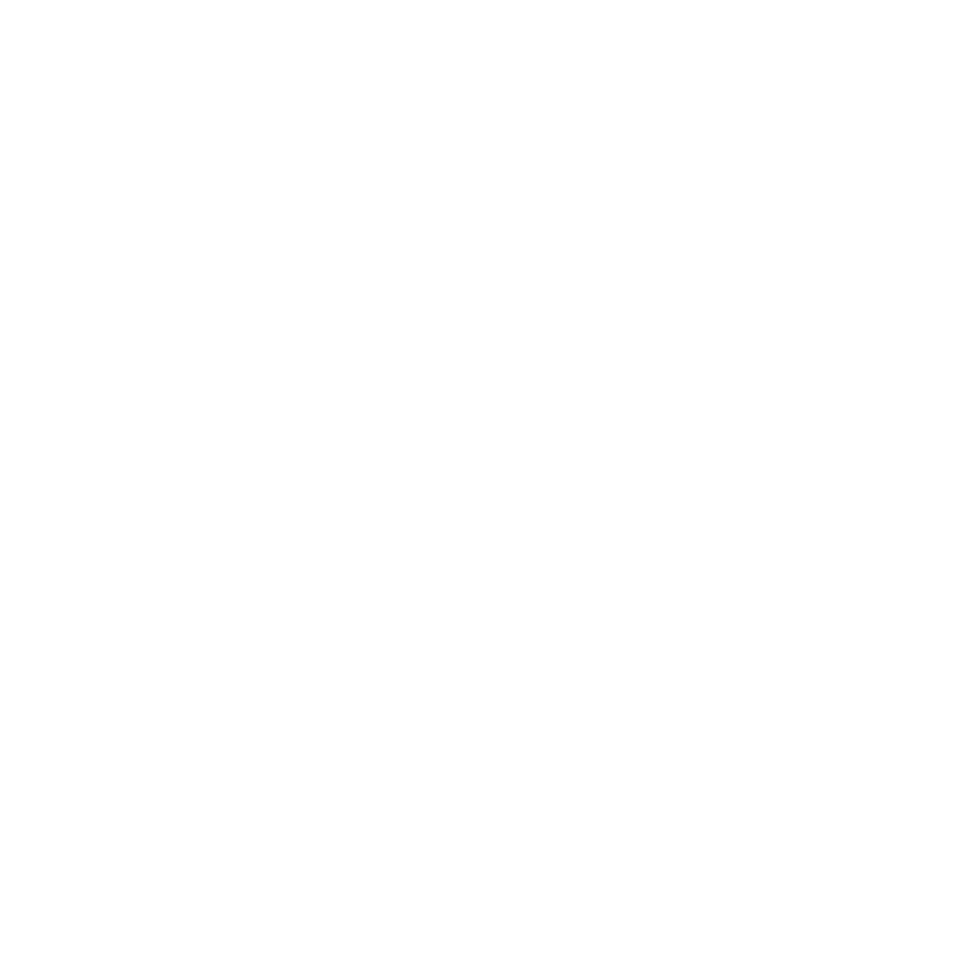

14:30 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


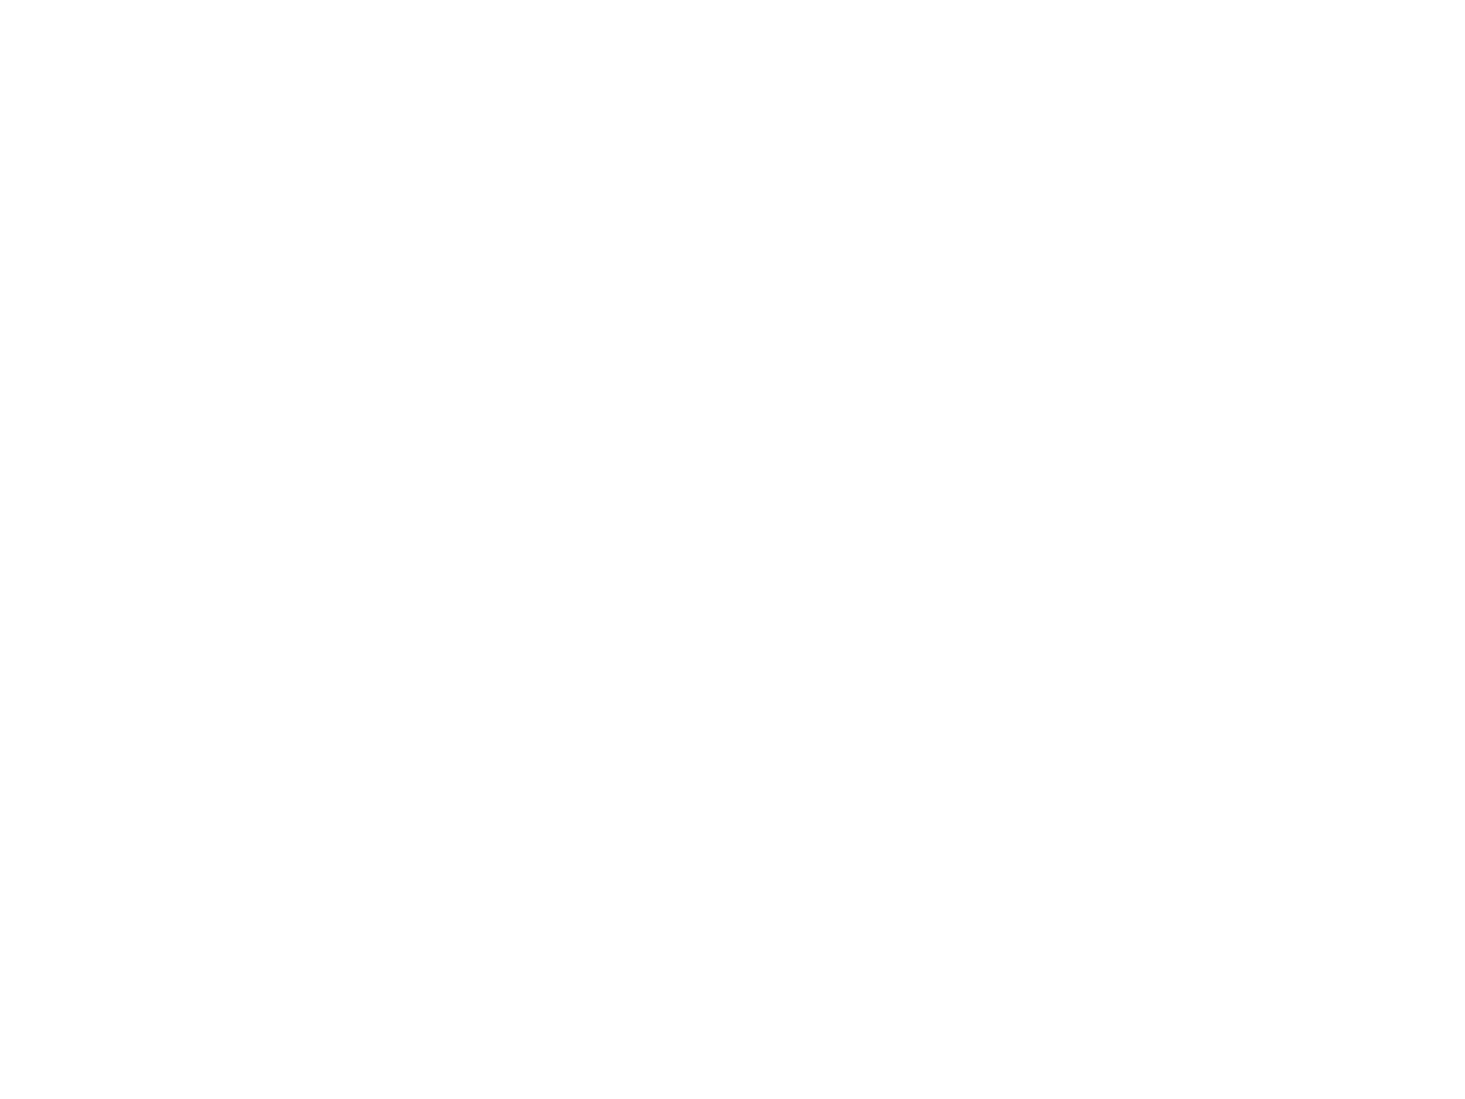

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


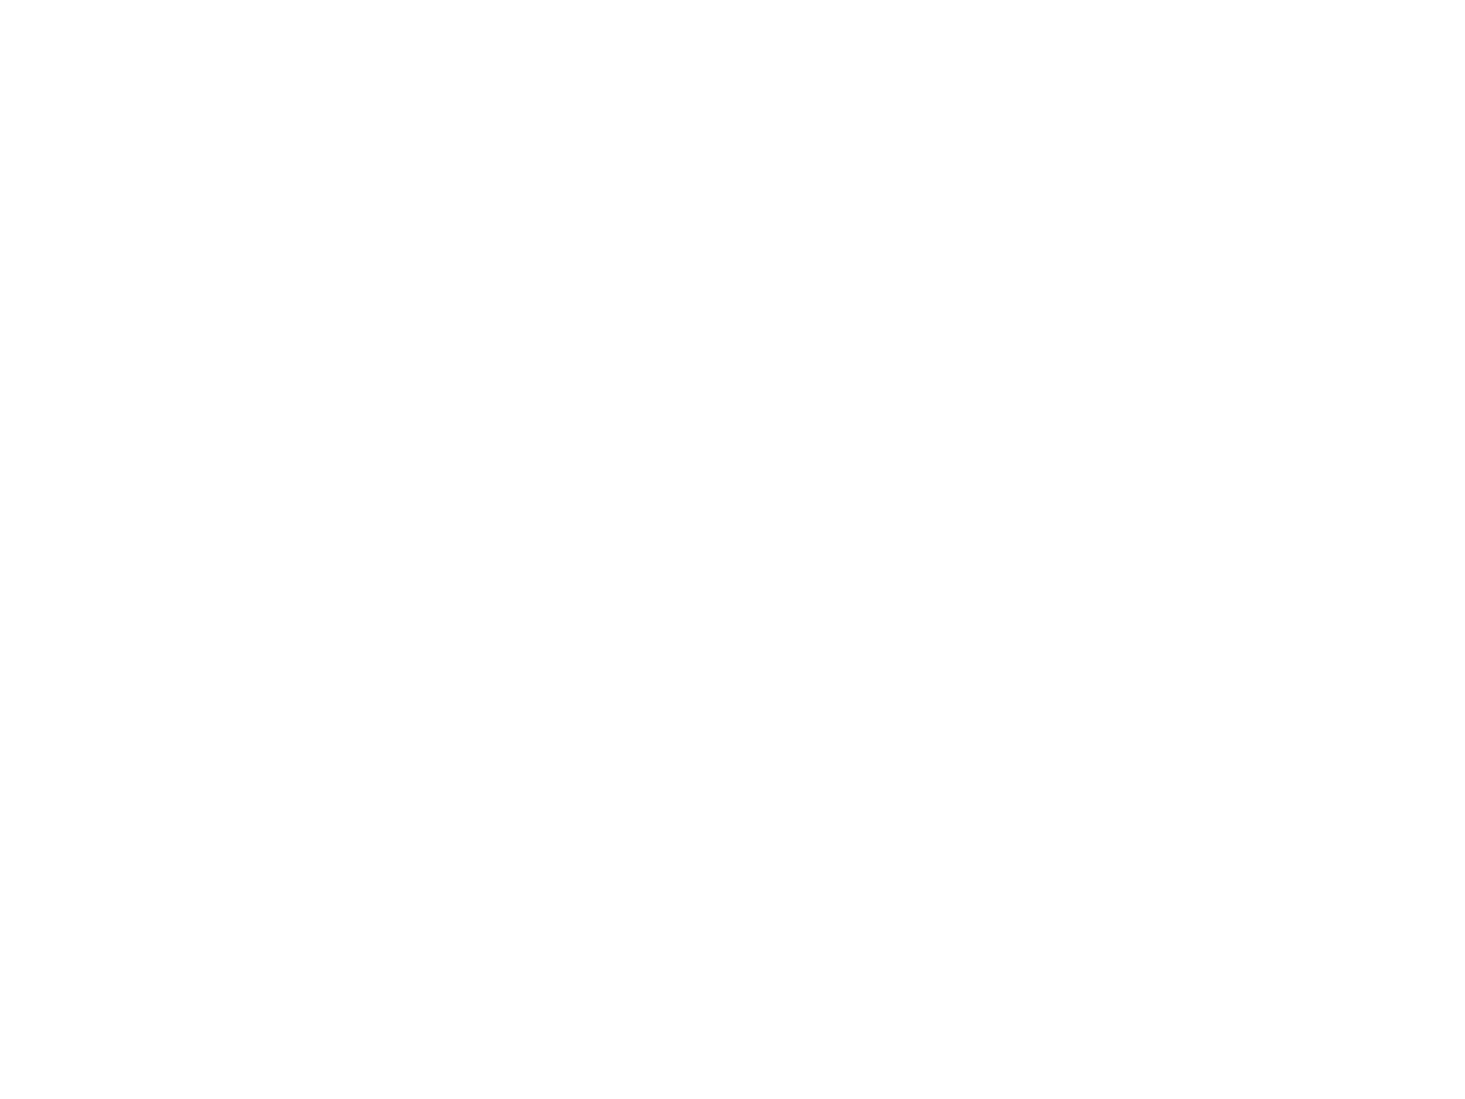

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


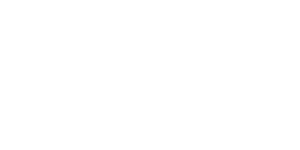

14:30 bilby WARNING : Axis limits cannot be NaN or Inf
14:30 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


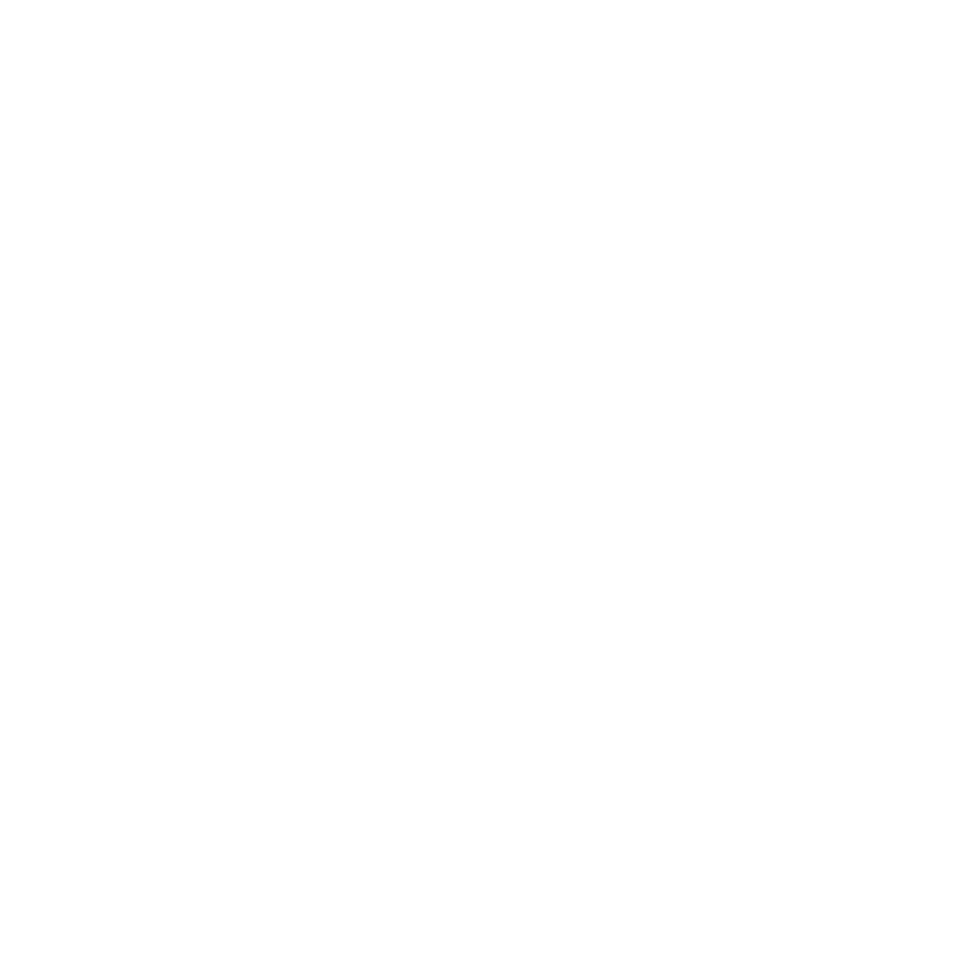

14:40 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


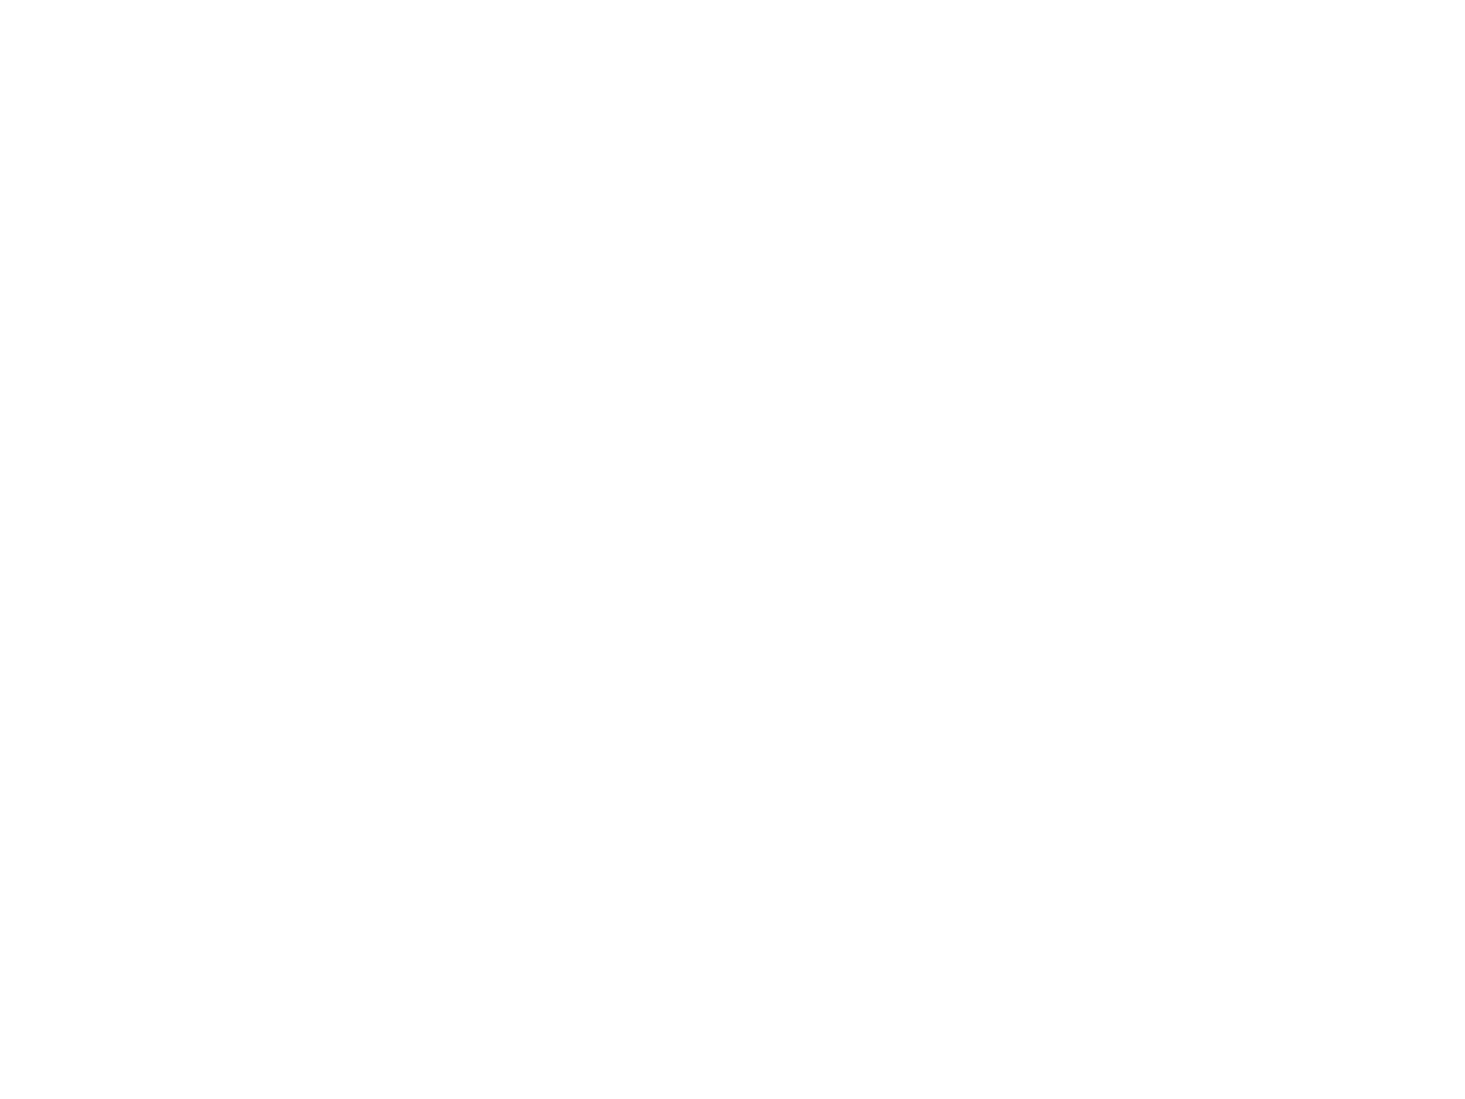

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


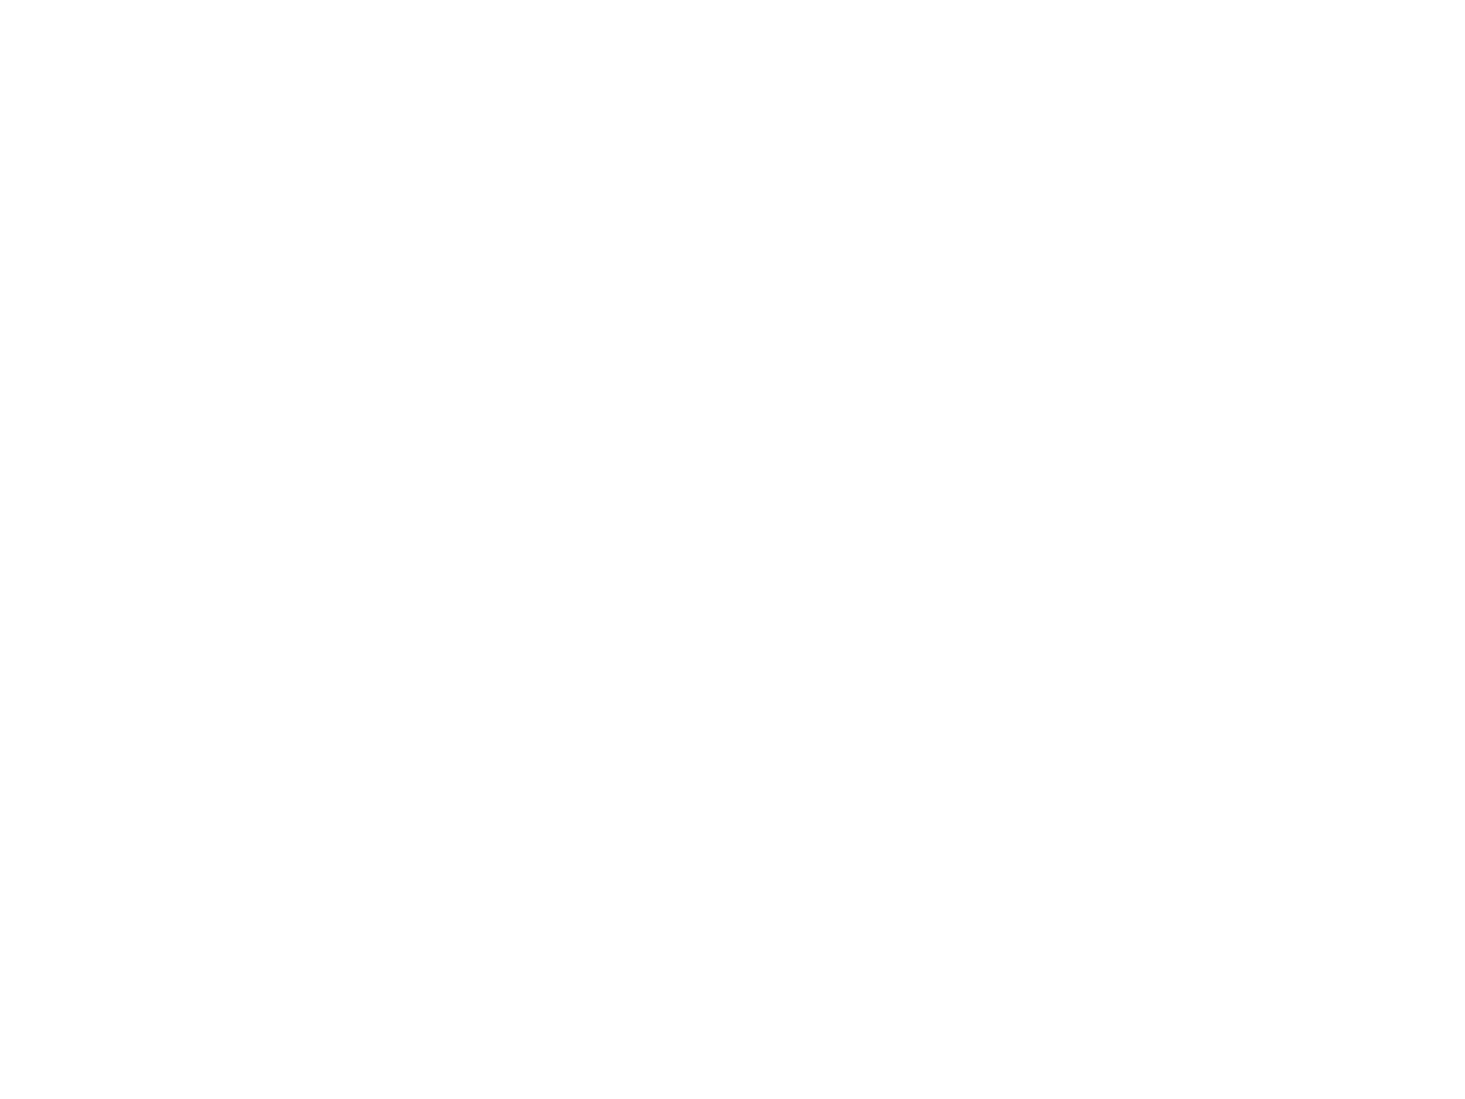

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


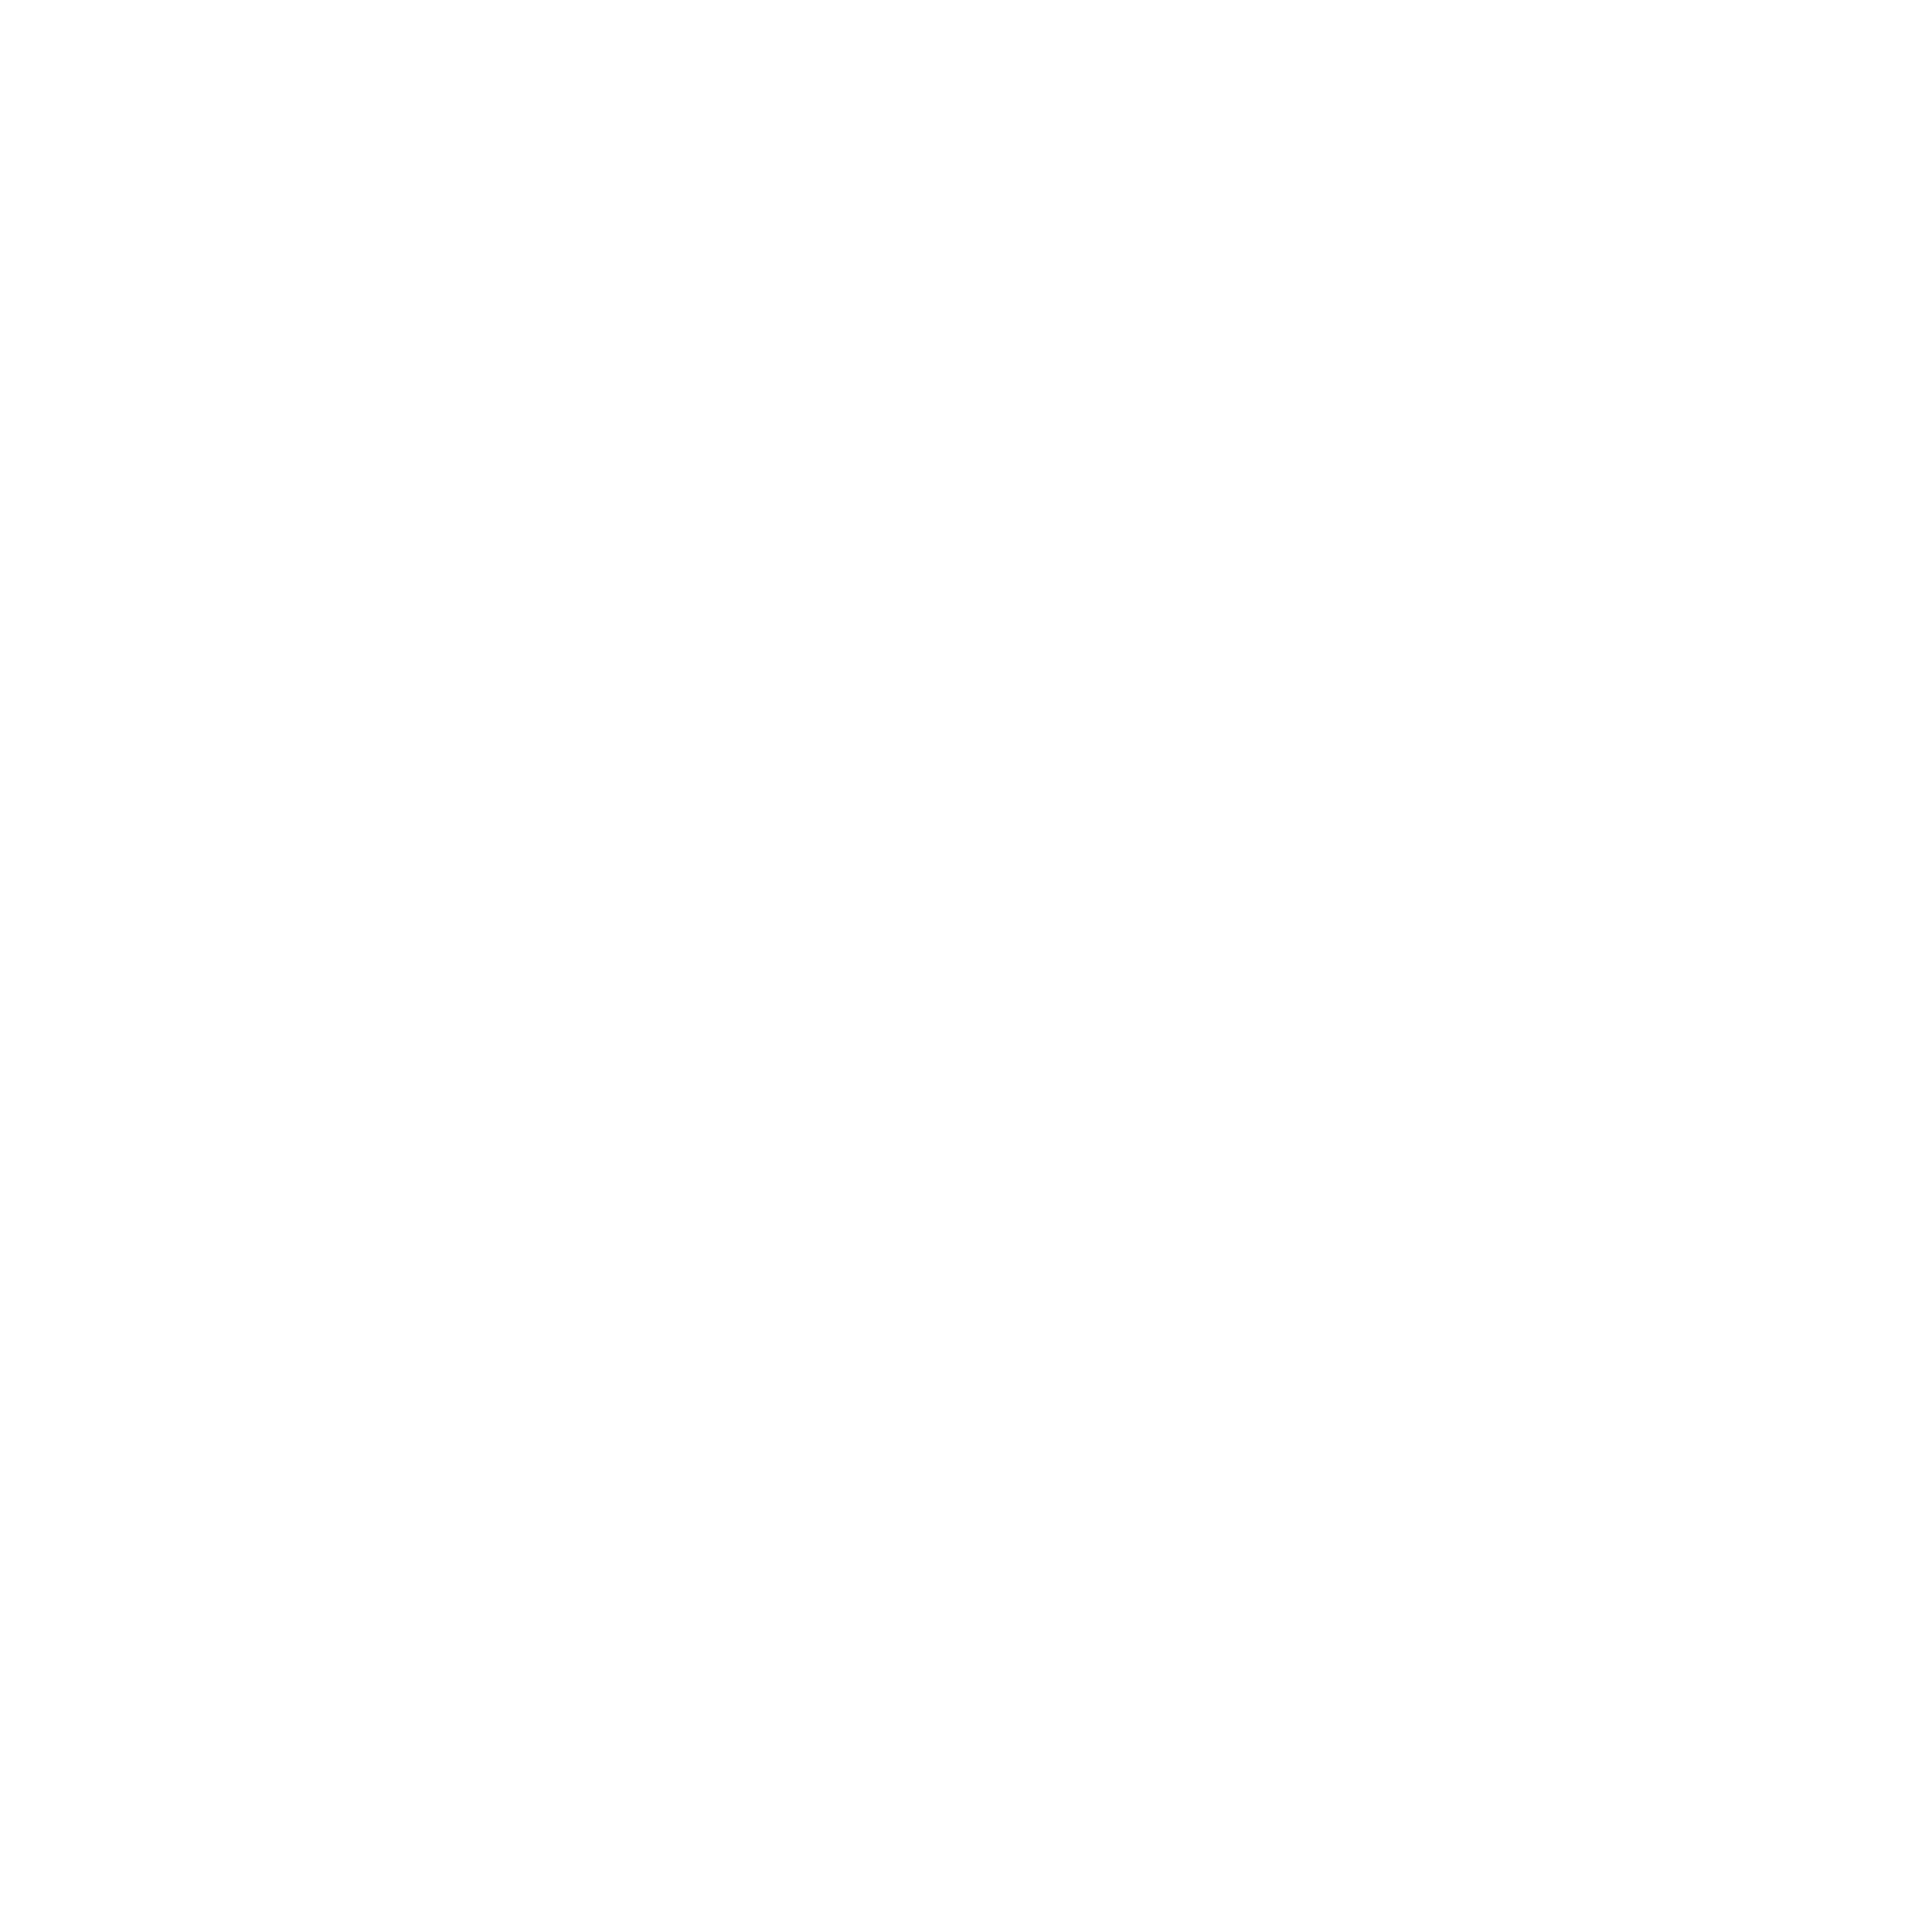

14:40 bilby WARNING : Axis limits cannot be NaN or Inf
14:40 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


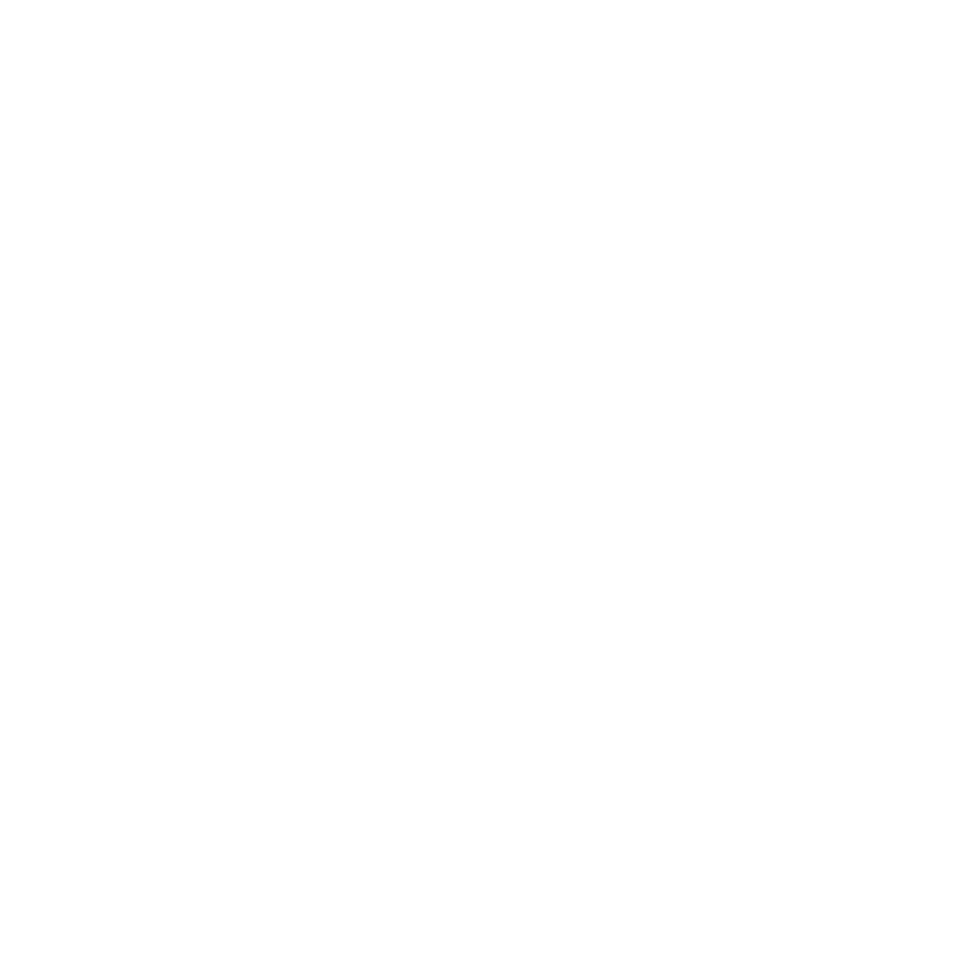

14:51 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


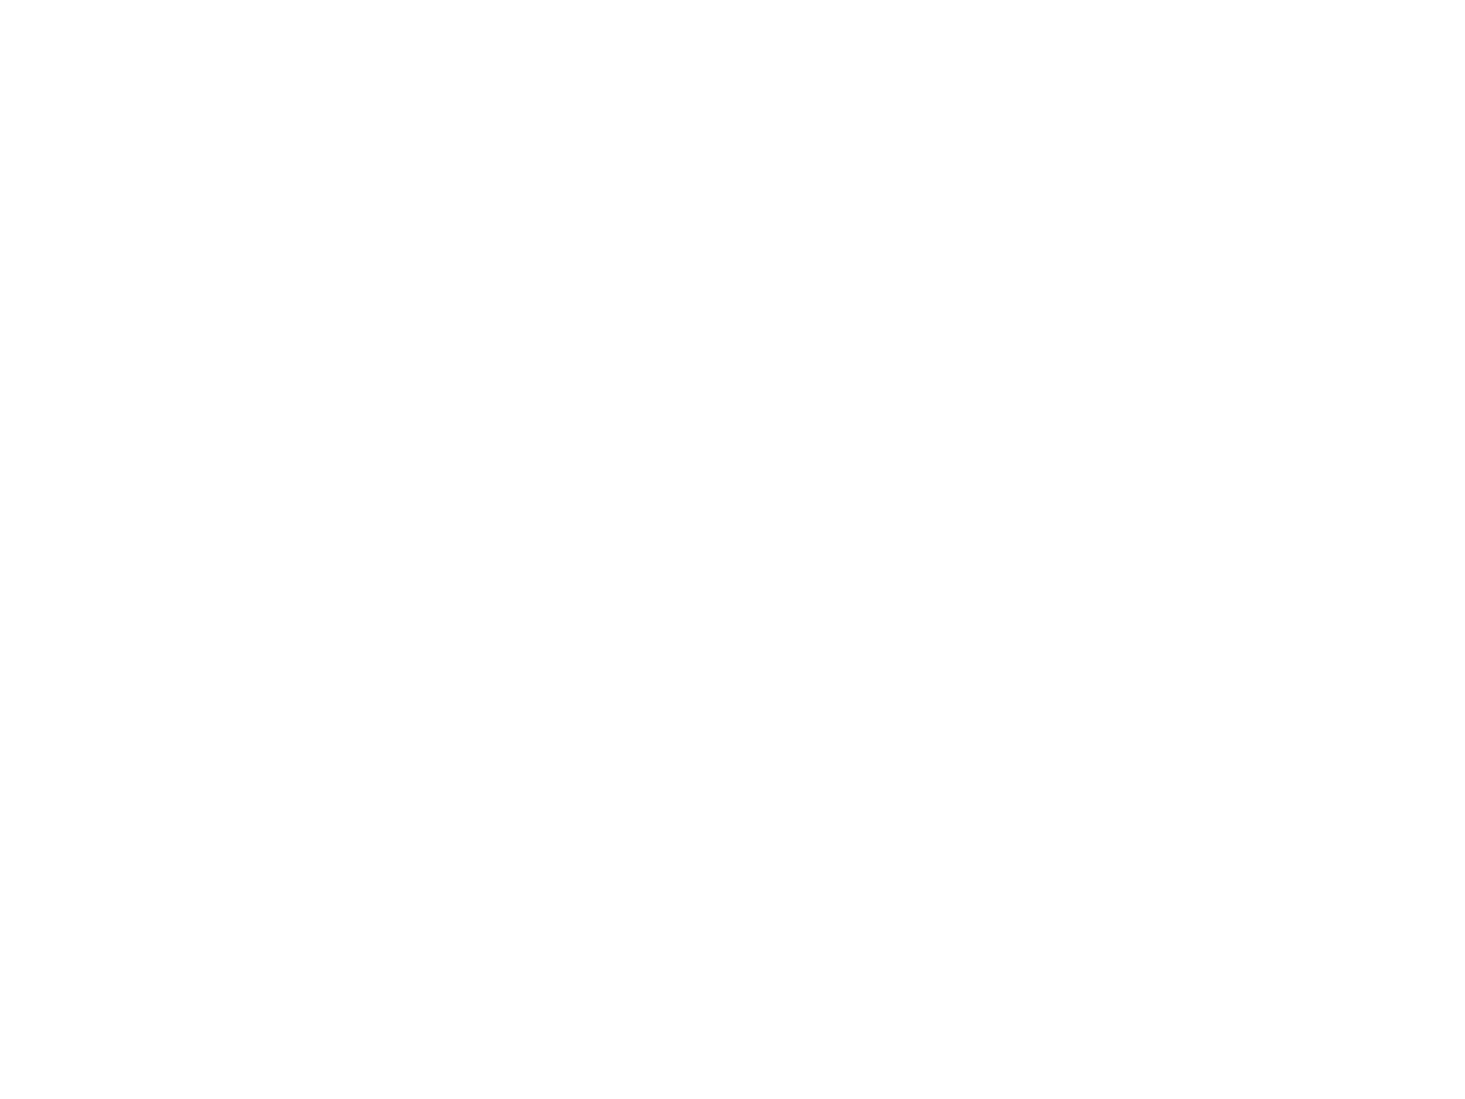

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


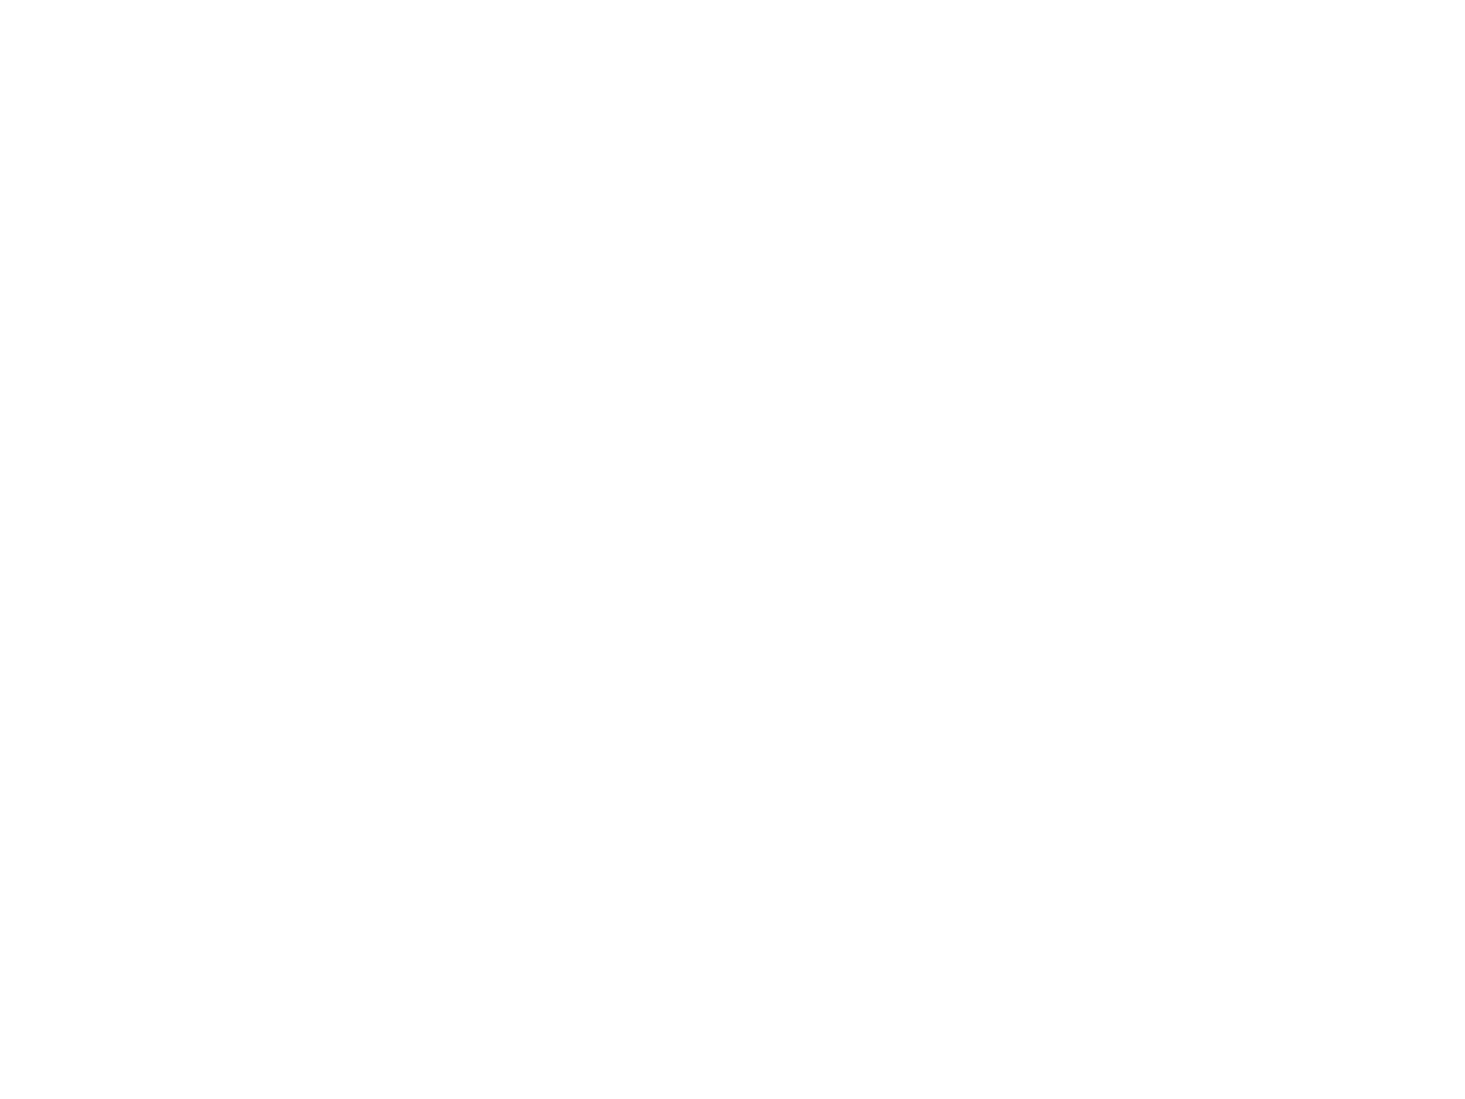

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


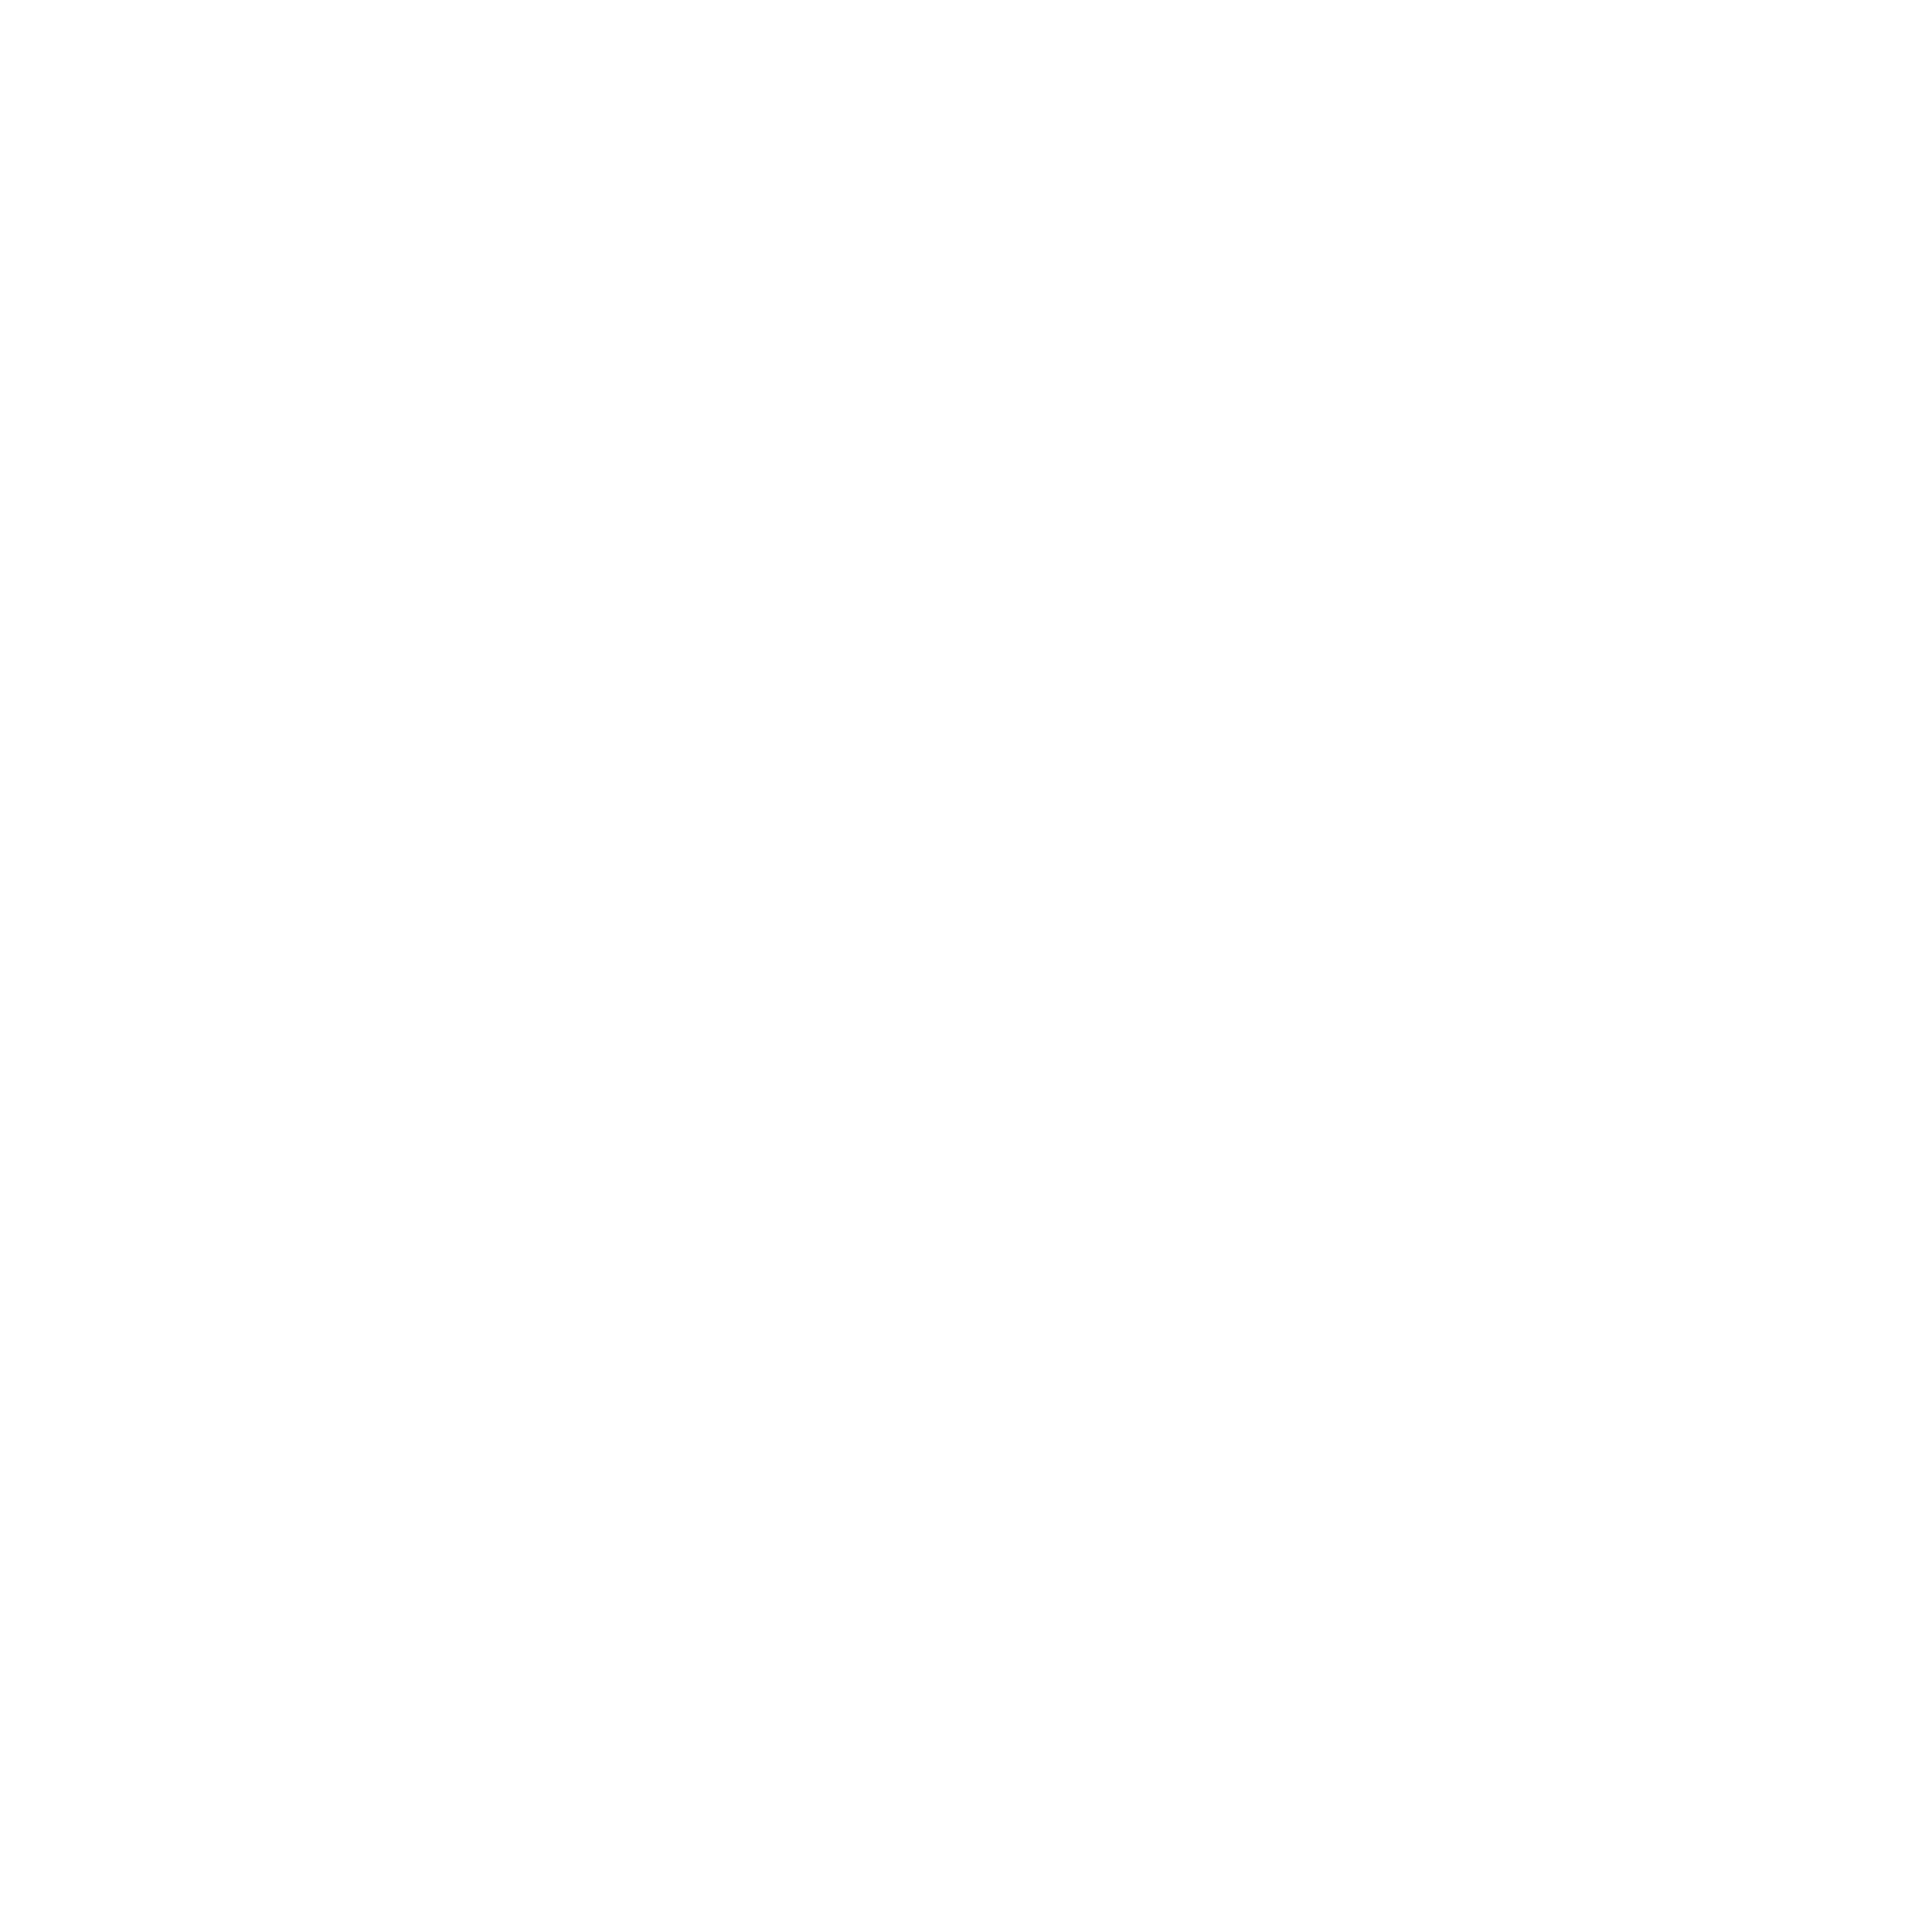

14:51 bilby WARNING : Axis limits cannot be NaN or Inf
14:51 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


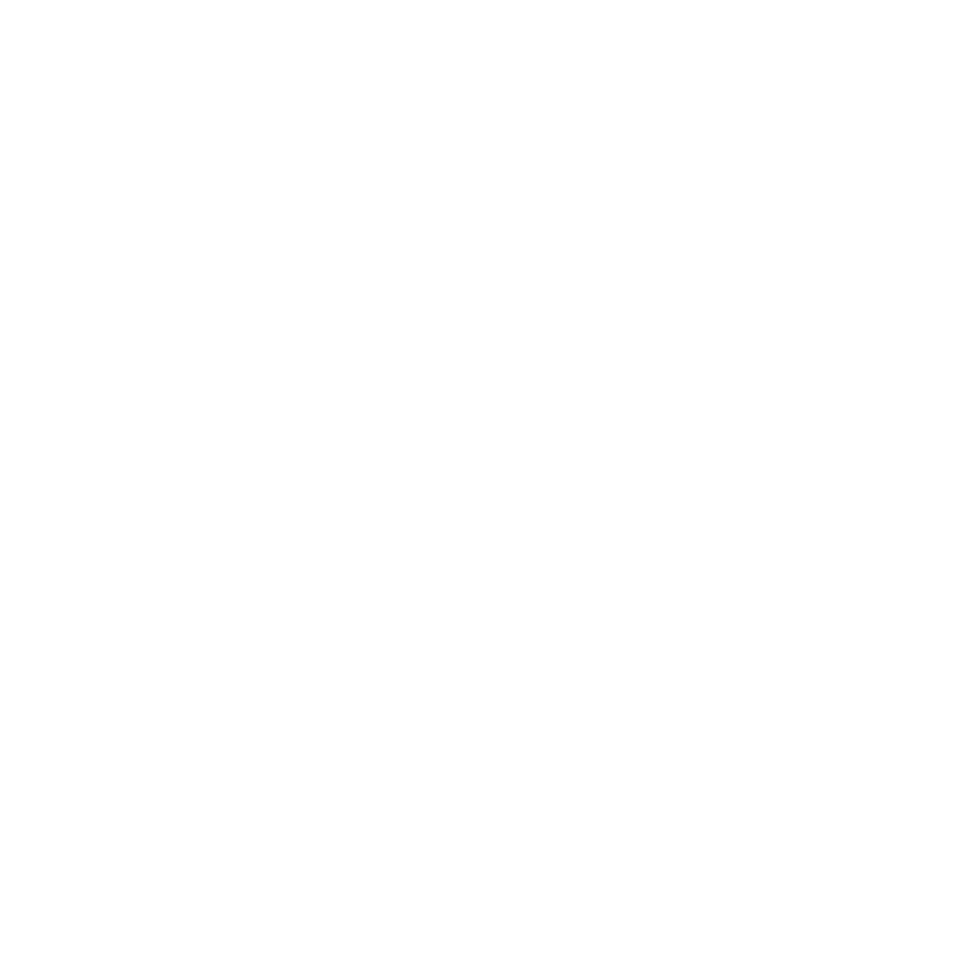

15:01 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


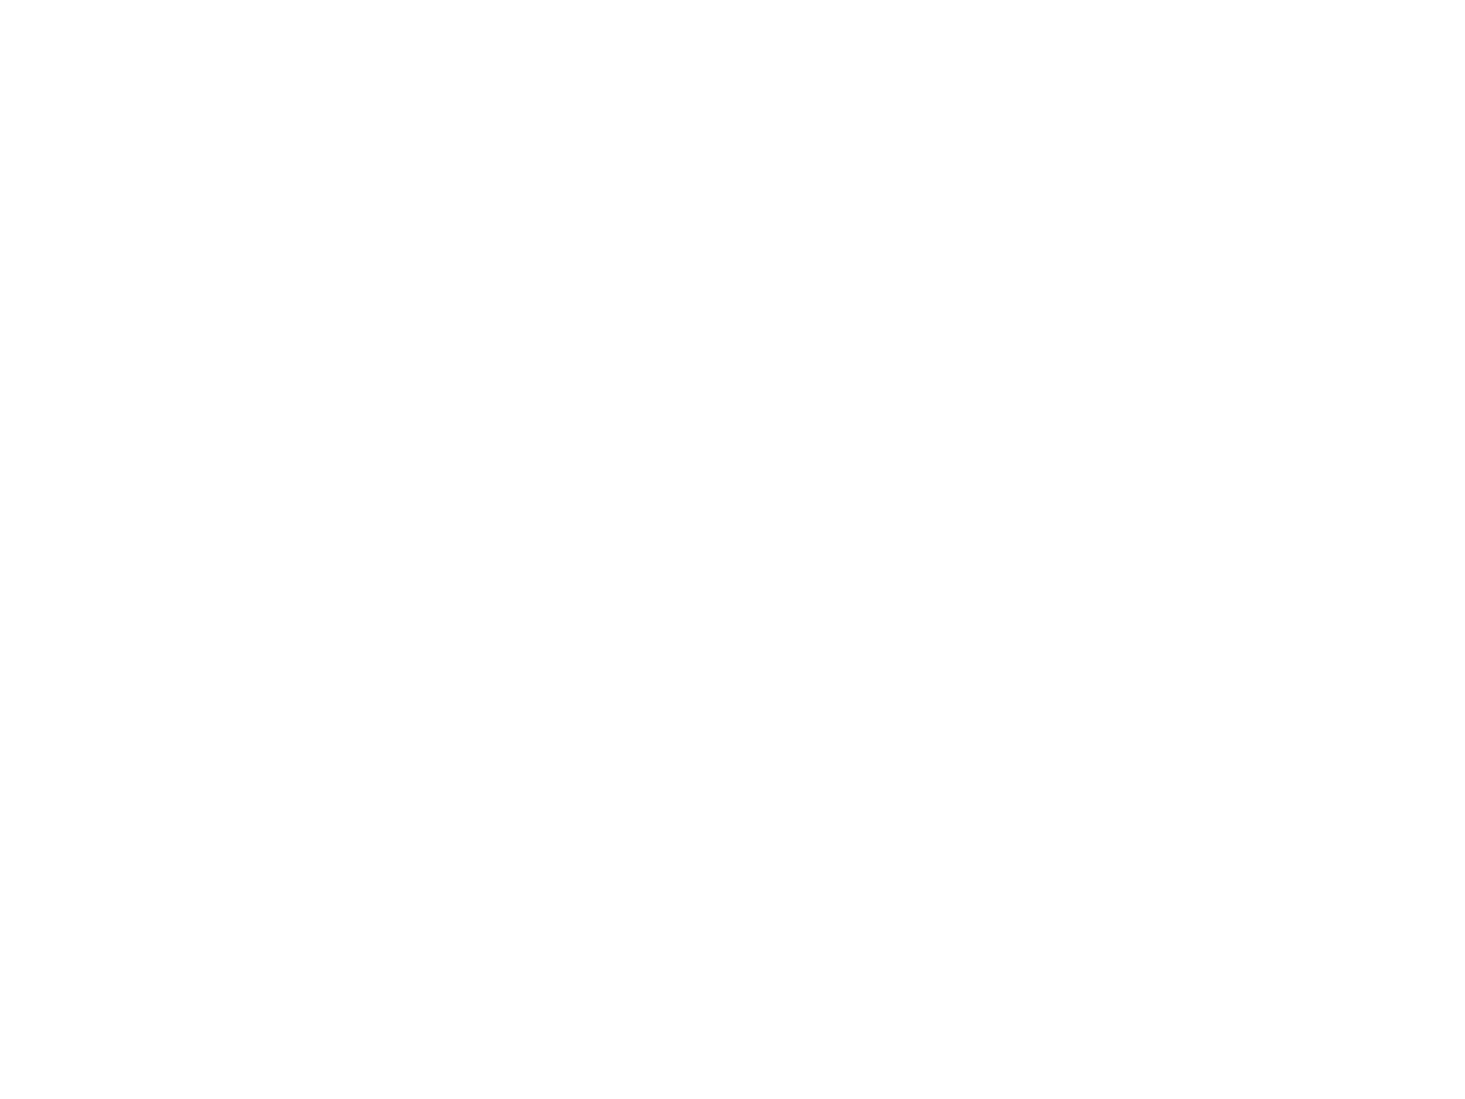

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


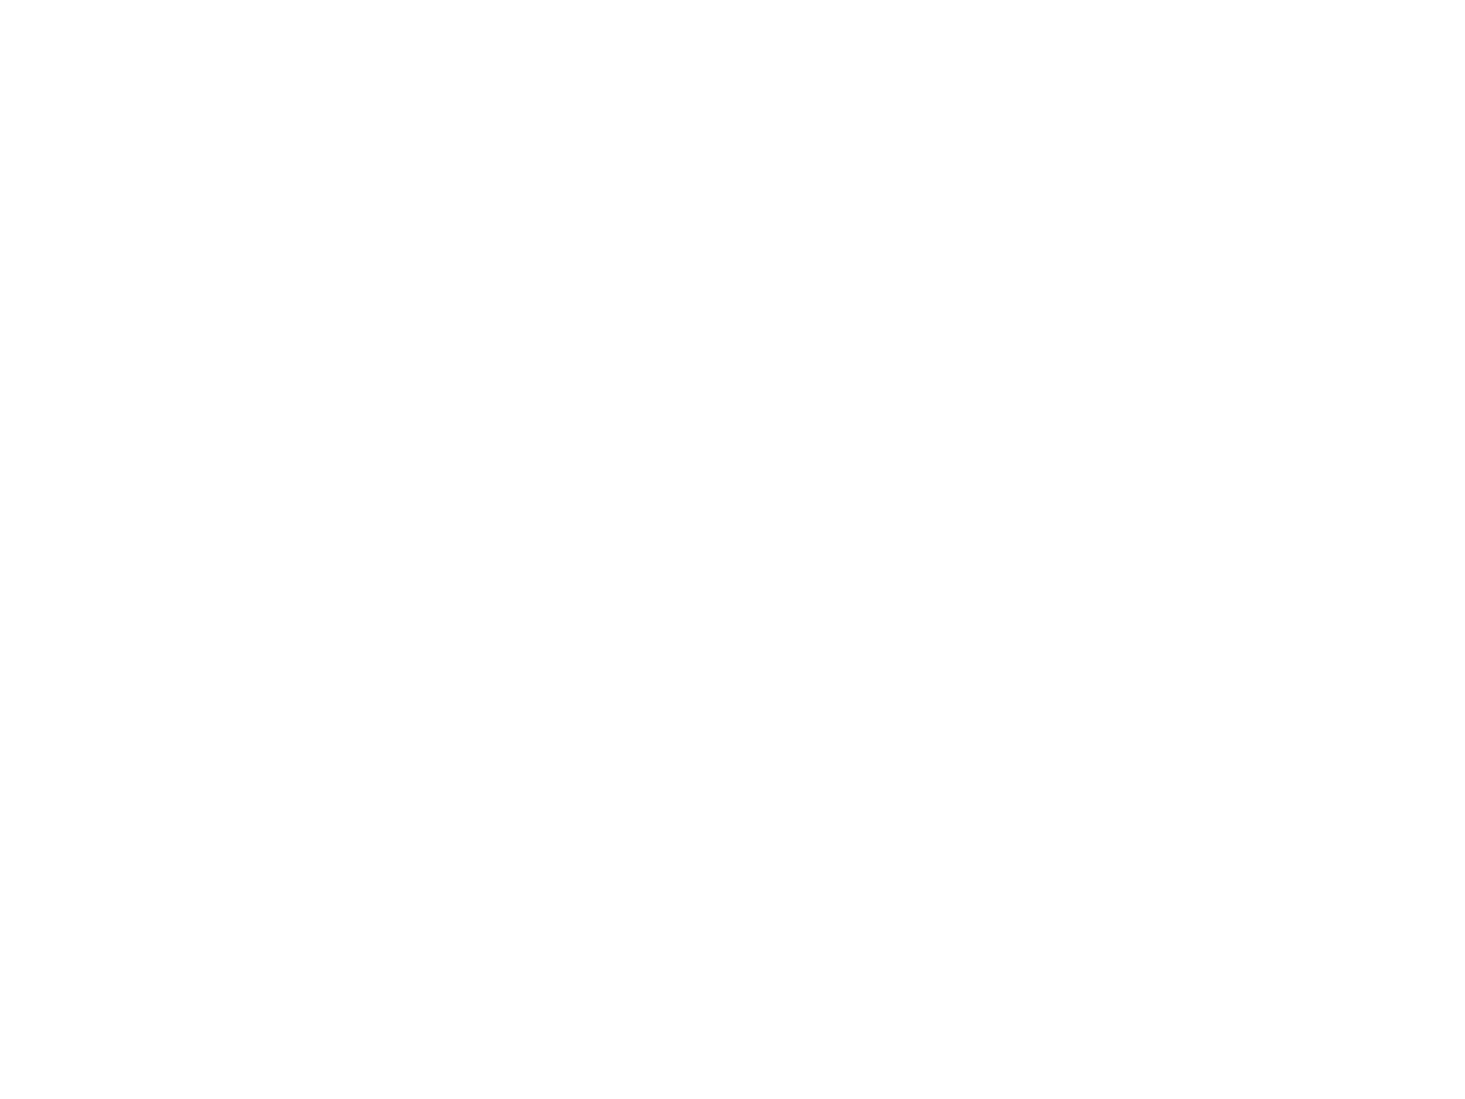

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


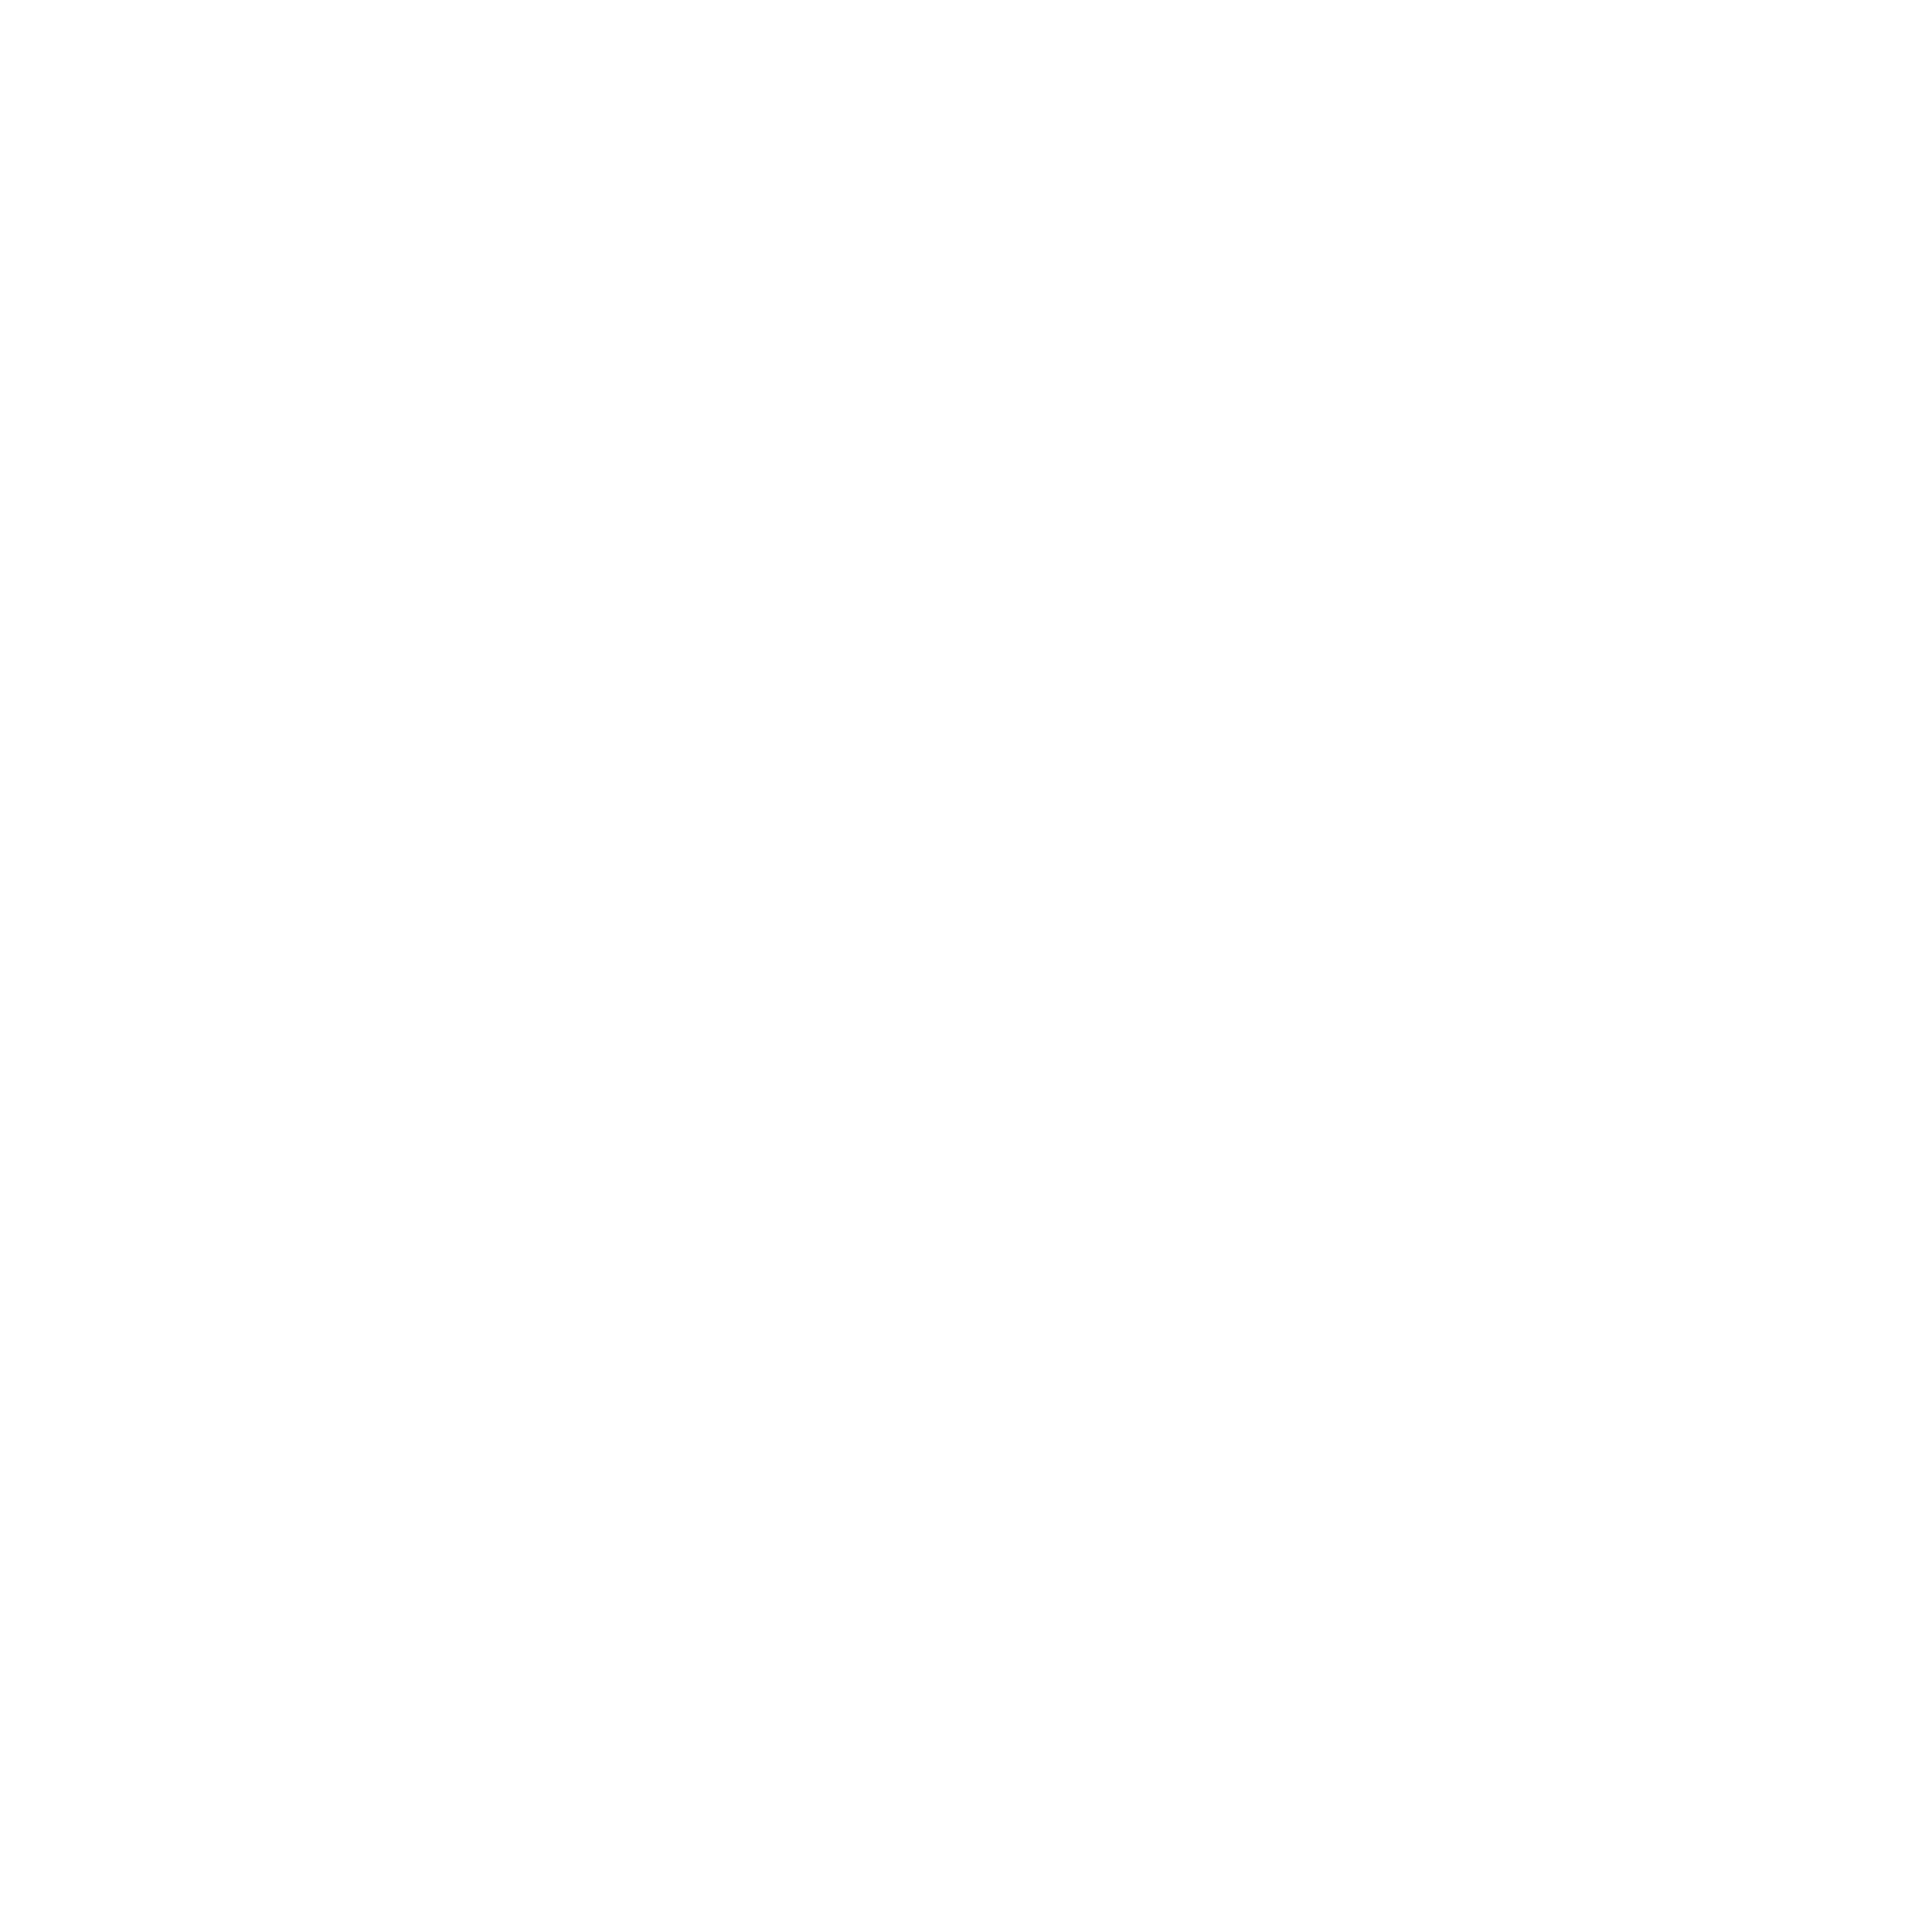

15:01 bilby WARNING : Axis limits cannot be NaN or Inf
15:01 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


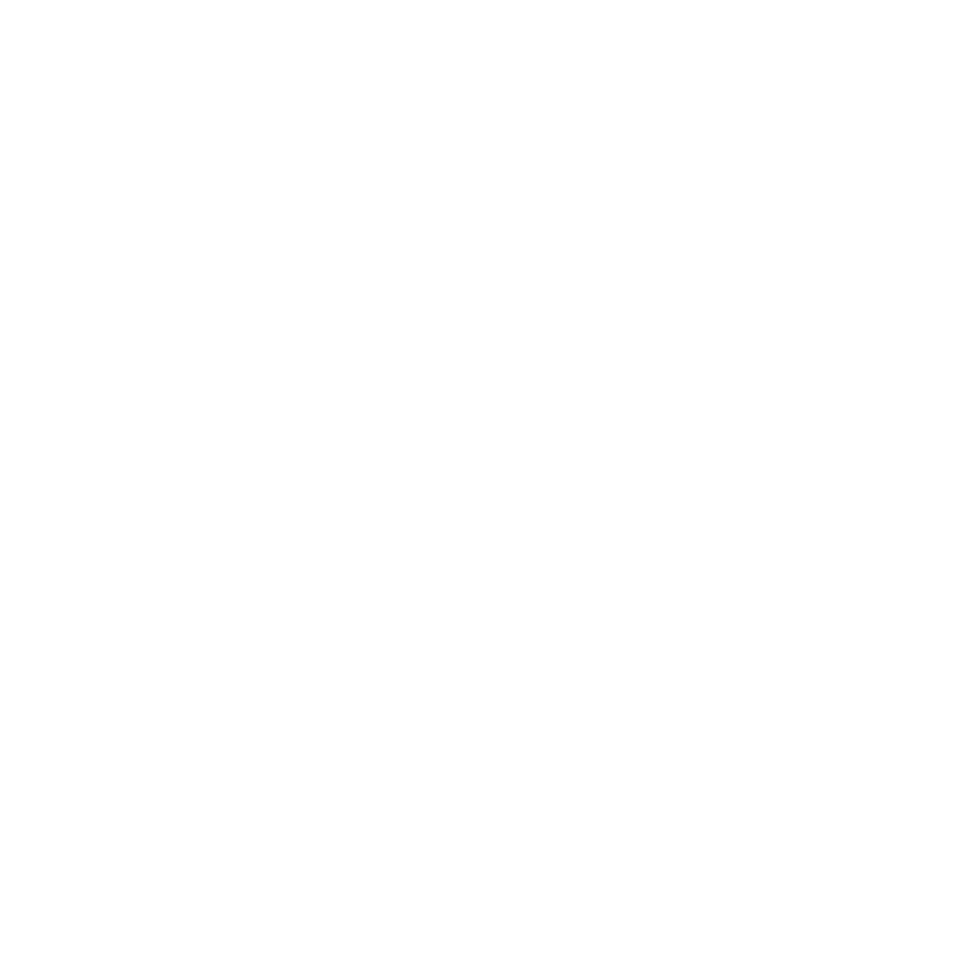

15:08 bilby INFO    : Written checkpoint file /home/akulkarn/notebooks/bibly_results_Energy_Dist//label_resume.pickle
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


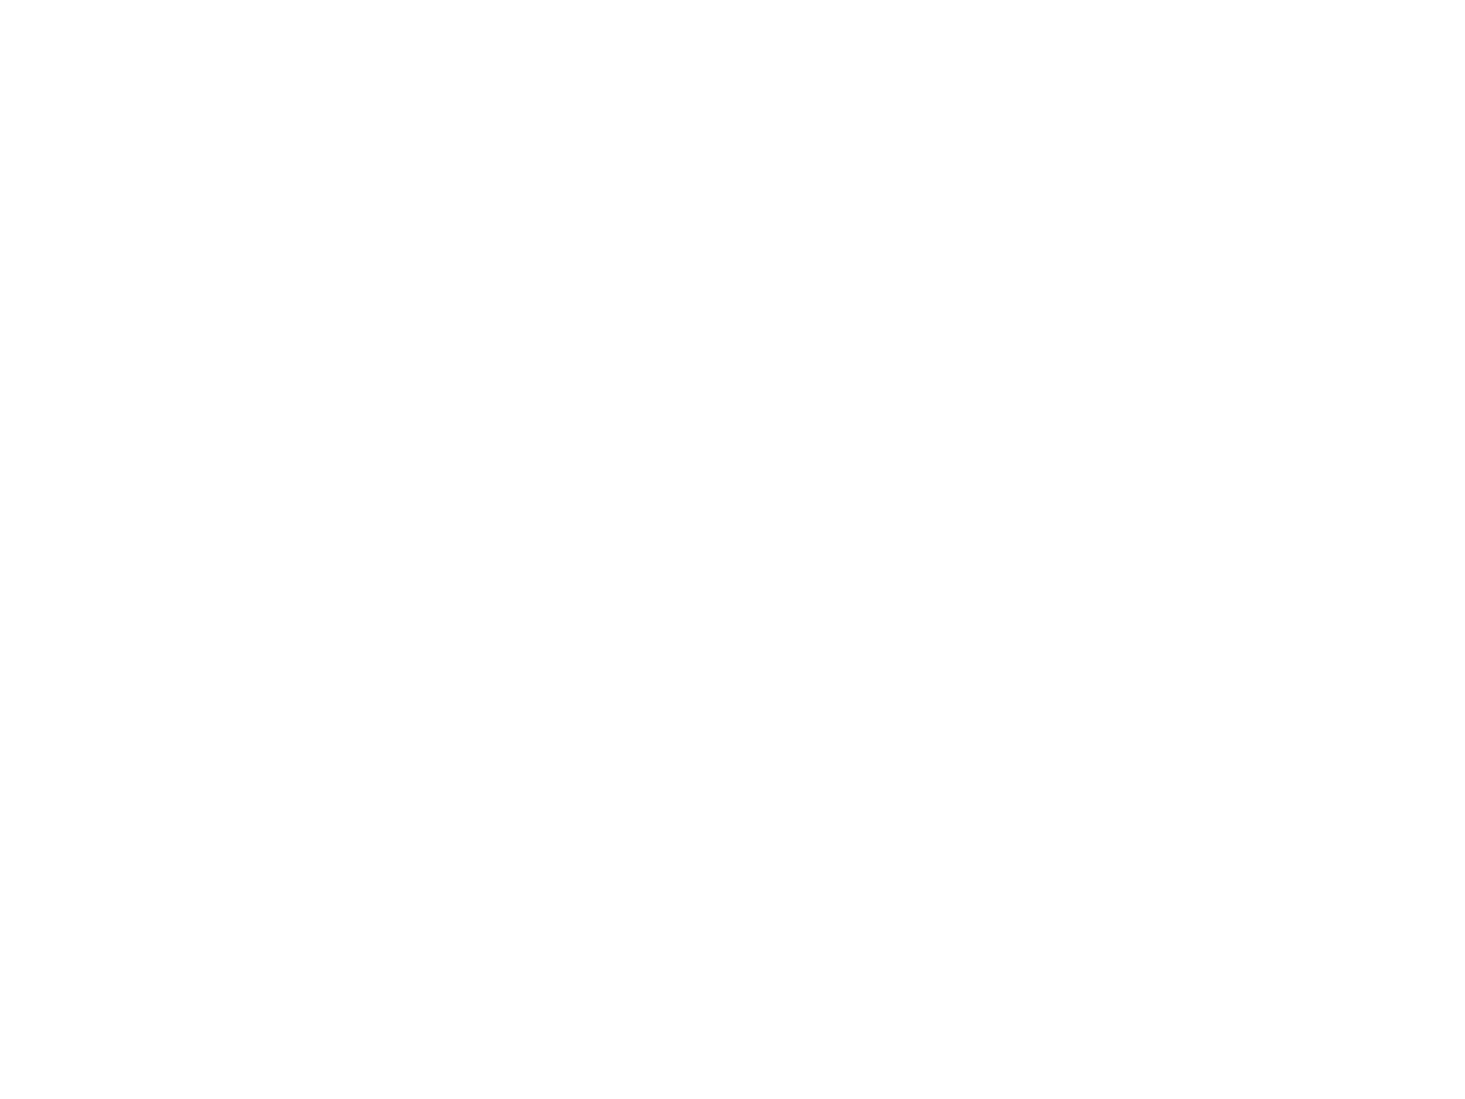

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)


<IPython.core.display.Javascript object>


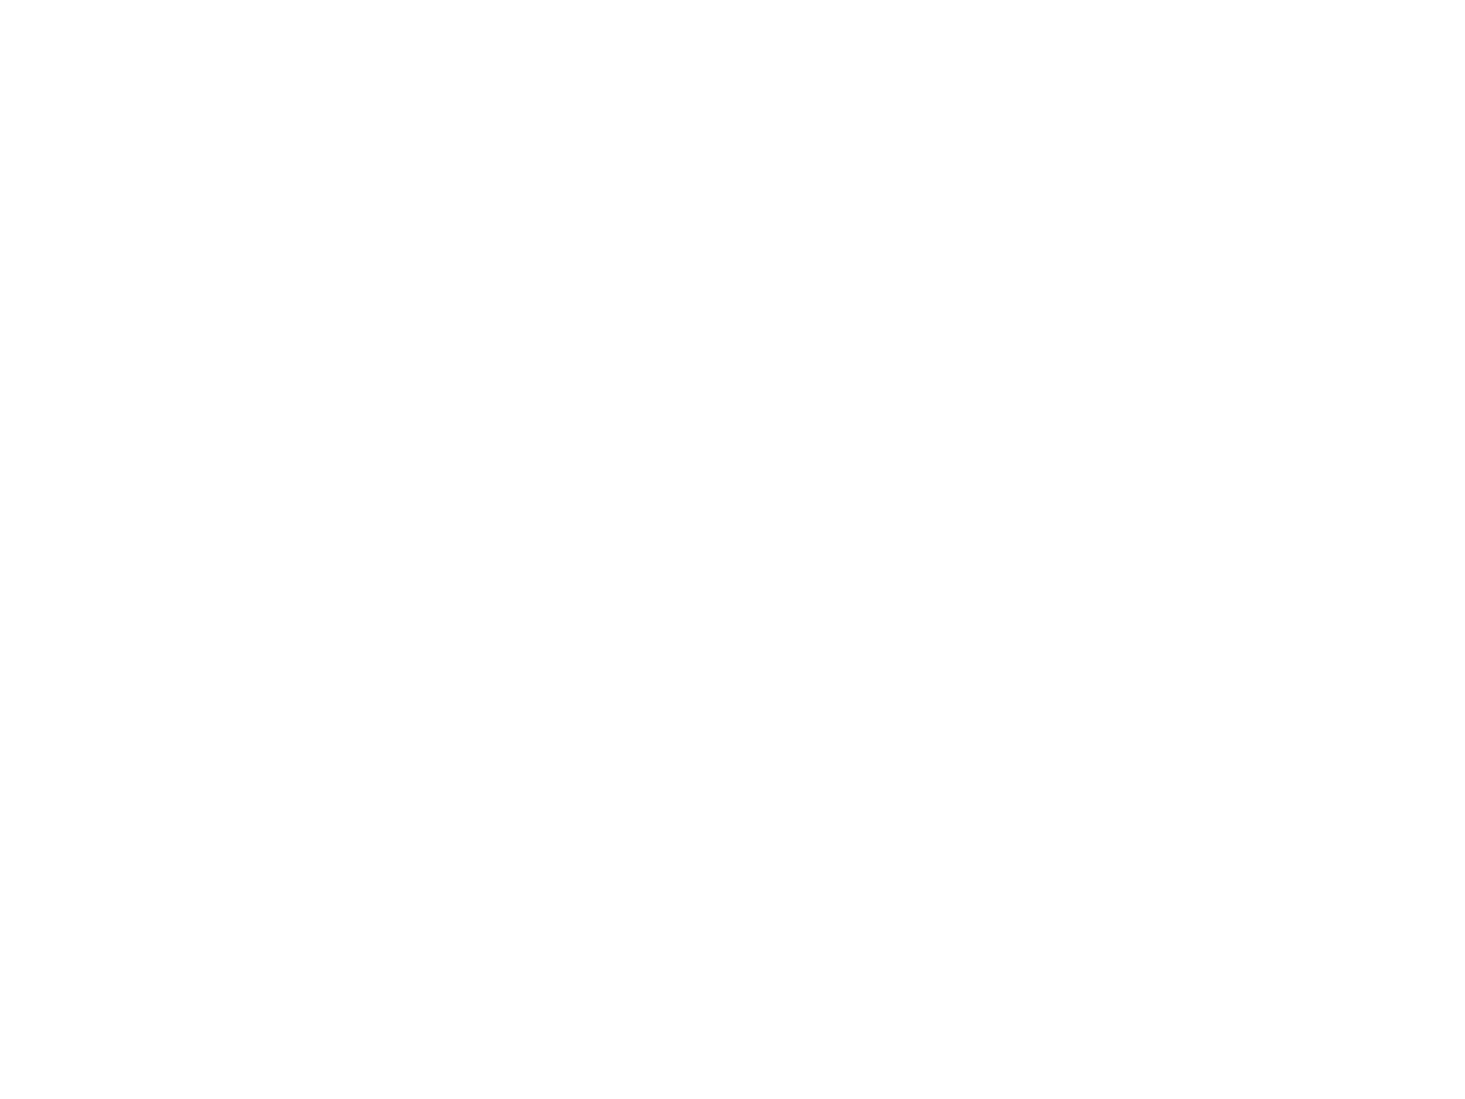

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))


<IPython.core.display.Javascript object>


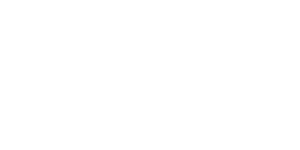

15:08 bilby WARNING : Axis limits cannot be NaN or Inf
15:08 bilby WARNING : Failed to create dynesty run plot at checkpoint


<IPython.core.display.Javascript object>


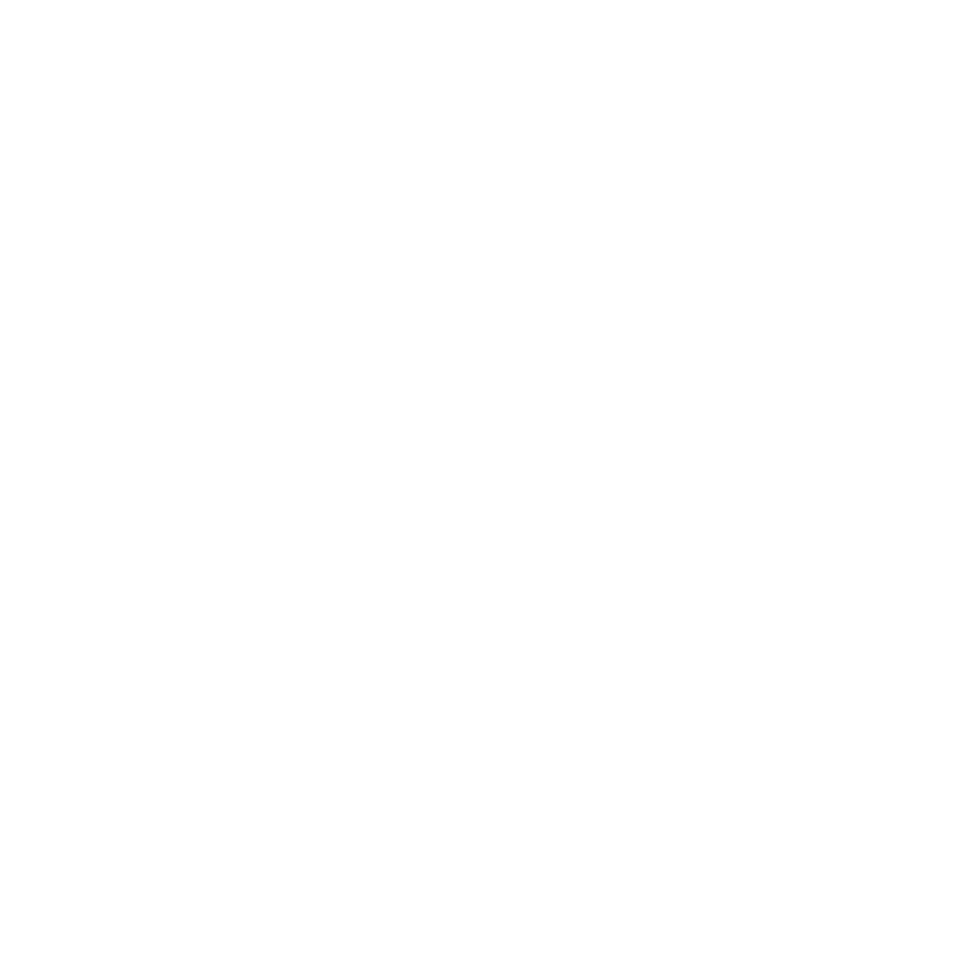

/home/akulkarn/.conda/envs/py3/lib/python3.8/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
15:08 bilby INFO    : Sampling time: 1:17:06.090623
15:08 bilby INFO    : Summary of results:
nsamples: 7146
ln_noise_evidence:    nan
ln_evidence: 7800.893 +/-  0.437
ln_bayes_factor:    nan +/-  0.437



<IPython.core.display.Javascript object>


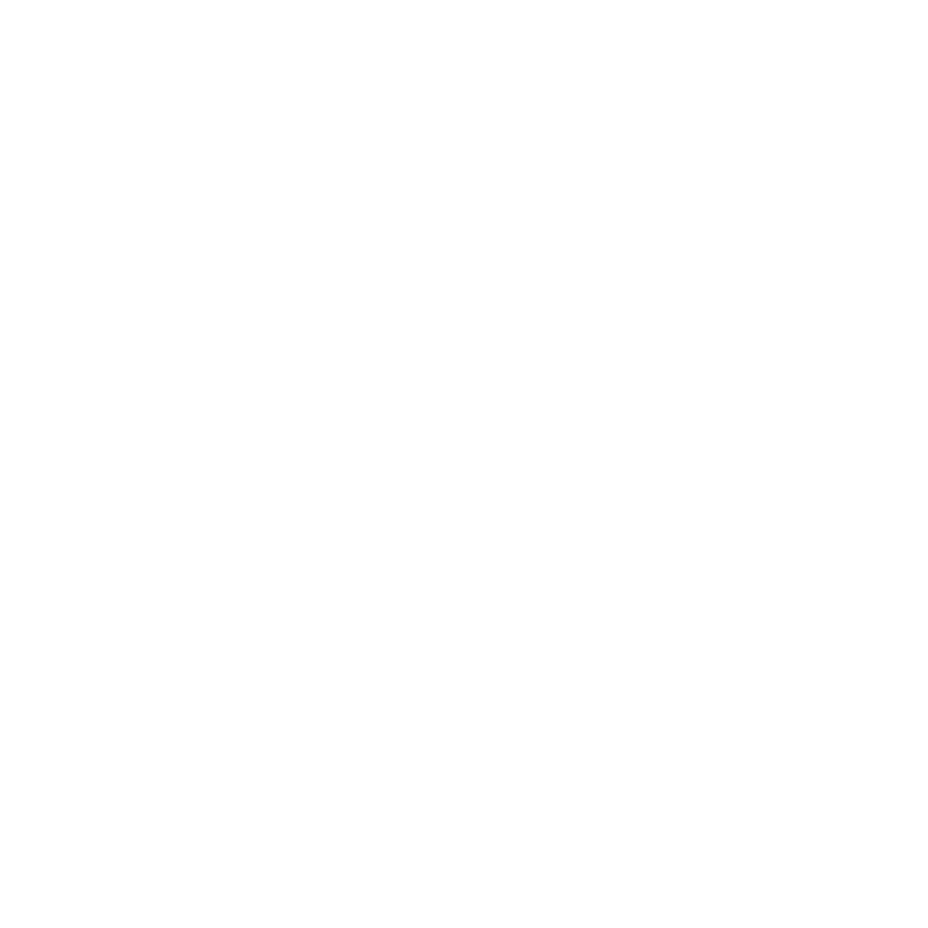

<IPython.core.display.Javascript object>


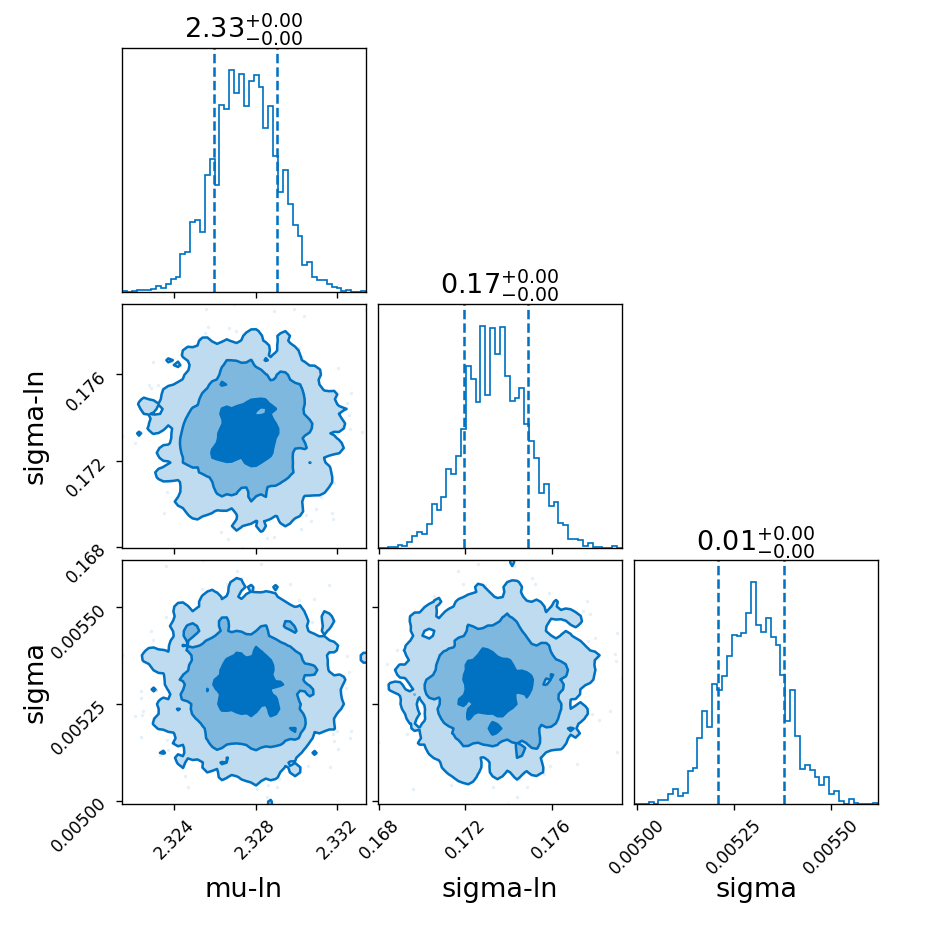

In [47]:
outdir=outdir = "/home/akulkarn/notebooks/bibly_results_Energy_Dist/"

result = bilby.run_sampler(
        likelihood=likelihood,
        priors=priors,
        sampler="dynesty",
        nlive=250,
        outdir=outdir,
        clean=True,
        conversion_function
    )
result.plot_corner()

<IPython.core.display.Javascript object>


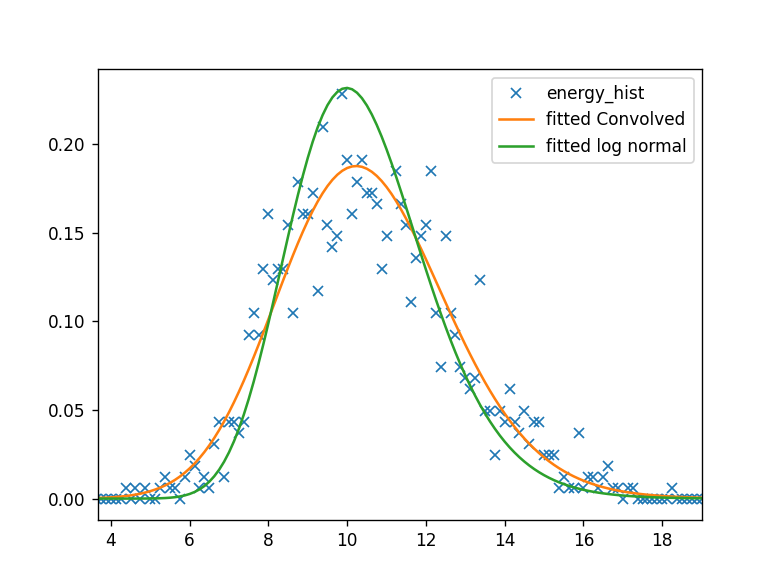

In [49]:
plt.figure()
plt.plot(energy_bin[0:-1],np.histogram(Energy_main_comp[:,0,10],bins=np.arange(-128,128,(256)/2048),density=True)[0],'x',label='energy_hist')
#plt.plot(noise_bin[0:-1],np.histogram(Energy_noise[:,0,chn],bins=np.arange(-8,8,16/256),density=True)[0],'x',label='noise_hist')
plt.plot(energy_bin[0:-1],(get_prob_pulseEnergy(energy_bin[0:-1],2.33,0.17)),label='fitted Convolved')
plt.plot(energy_bin[0:-1],(log_normal(energy_bin[0:-1],2.33,0.17)),label='fitted log normal')

plt.legend()
#plt.plot(log_normal()
#plt.plot(energy_bin[0:-1],pdf_energy_hist)

###### Calculating the mean and std of the pulse energies from the inferred distriution

In [2]:
from scipy.integrate import quad

def log_normal_mu(x,mu_ln,sigma_ln):
    return x*(1/(x*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x)-mu_ln)**2))

def log_normal_std(x,mu_ln,sigma_ln):
    return ((x-quad(log_normal_mu, 0.001, np.inf, args=(mu_ln,sigma_ln))[0])**2)*(1/(x*sigma_ln*np.sqrt(2*np.pi)))*(np.exp((-1/(2*sigma_ln**2))*(np.log(x)-mu_ln)**2))
    

In [11]:
mu=[];sigma=[]

outdir='/home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/MeerKAT_SinglePulse_Gaussian'

for chn in range(int(os.popen("ls /home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/MeerKAT_SinglePulse_Gaussian | grep 'Chn' | wc -l").read().strip('\n'))):
    if chn in [30]:#[15,19,24]:
        mu.append(np.nan)
        sigma.append(np.nan)
    else:
        result = bilby.result.read_in_result(outdir=os.path.join(outdir,'Chn_'+str(chn)), label='label')
        mu.append(np.median(result.posterior['mu_ln'].values))
        sigma.append(np.median(result.posterior['sigma_ln'].values))

<IPython.core.display.Javascript object>


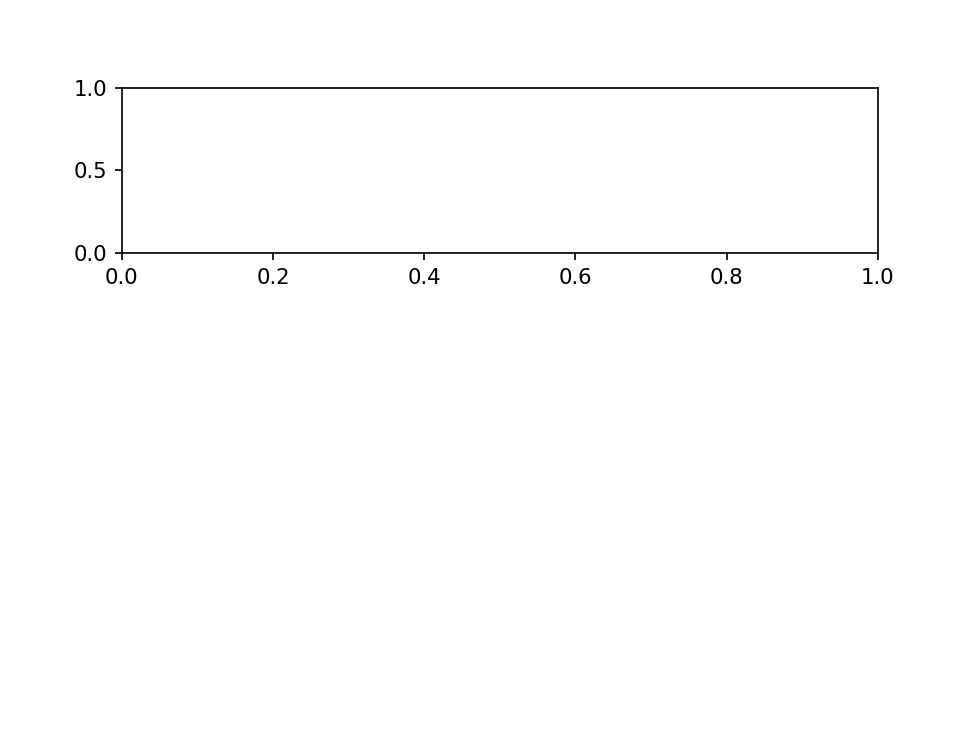

NameError: name 'Freq_MeerKAT' is not defined

In [12]:
    

mod_index_Energies=[]
mu_energy=[]
std_energy=[]
for m, s in zip(mu,sigma):
    mu_energy_temp = quad(log_normal_mu, 0.001, np.inf, args=(m,s))
    mu_energy.append(mu_energy_temp[0])
    std_energy_temp = np.sqrt(quad(log_normal_std, 0.001, np.inf, args=(m,s)))
    std_energy.append(std_energy_temp[0])
    mod_index_Energies.append(std_energy_temp[0]/mu_energy_temp[0])
 

plt.figure()
plt.subplot(3,1,1)
plt.plot(Freq_MeerKAT,mu_energy,'o',label='mu')
plt.legend()
plt.subplot(3,1,2)
plt.plot(Freq_MeerKAT,std_energy,'o',label='Sigma')
plt.legend()
plt.subplot(3,1,3)
plt.plot(Freq_MeerKAT,mod_index_Energies,'o',label='Mod_Index')
plt.legend()

<IPython.core.display.Javascript object>


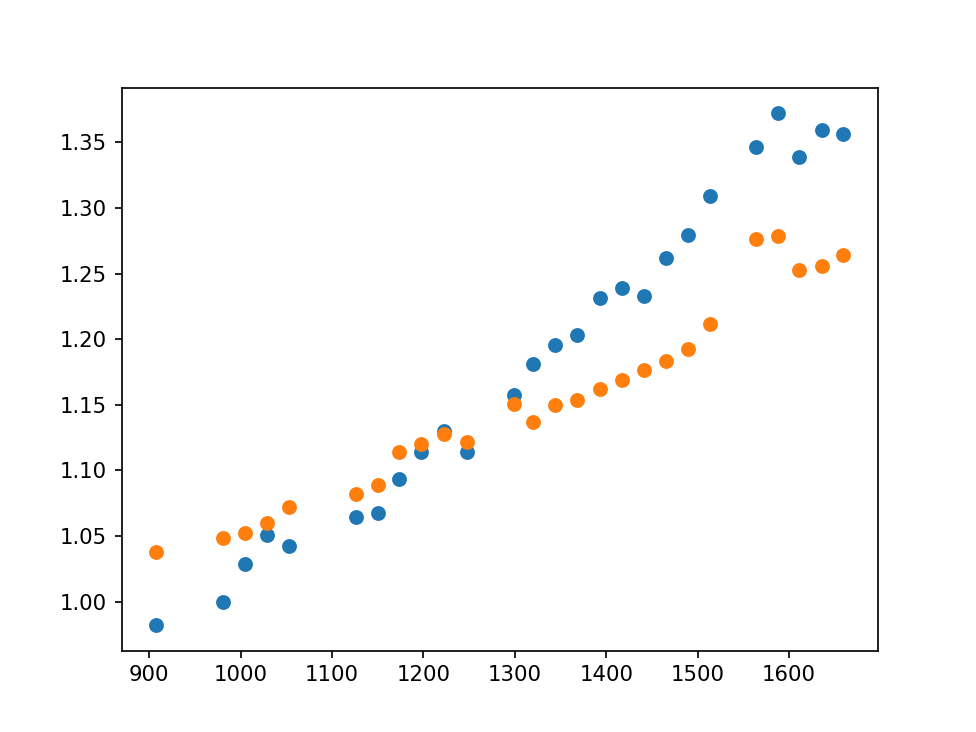

In [23]:
plt.figure()
shift=0.5
plt.plot(Freq_MeerKAT,modIndex_MeerKAT[0,:,512],'o',label="MeerKAT")
plt.plot(Freq_MeerKAT,np.array(mod_index_Energies)+shift,'o',label='Mod_Index')
#plt.scatter(modIndex_MeerKAT[0,:,512],np.array(mod_index_Energies))

##### Comparing the value of modulation index obtained from pulse energy distributions and phase resolved modulation index obtained such that the no of binsused for pulse energy calculations matches with no. of bins summed before getting modulation index.

In [22]:
%%time
pol=0
d_vec=[1,2,5,7,9,11,13,15,17,19,21]
modIndex_cum=np.ndarray([data.shape[2],len(d_vec)])
itr=0
for d in d_vec:
    for freq in range(data.shape[2]):
        data_tmp=np.mean(data[:,pol,freq,512-d:512+d],axis=1)
        noise_tmp=np.mean(data[:,pol,freq,0:2*d],axis=1)
        modIndex_cum[freq,itr]=np.sqrt(np.var(data_tmp)-np.mean(np.var(noise_tmp)))/np.mean(data_tmp)
    itr+=1

CPU times: user 576 ms, sys: 1.85 ms, total: 578 ms
Wall time: 576 ms


<IPython.core.display.Javascript object>


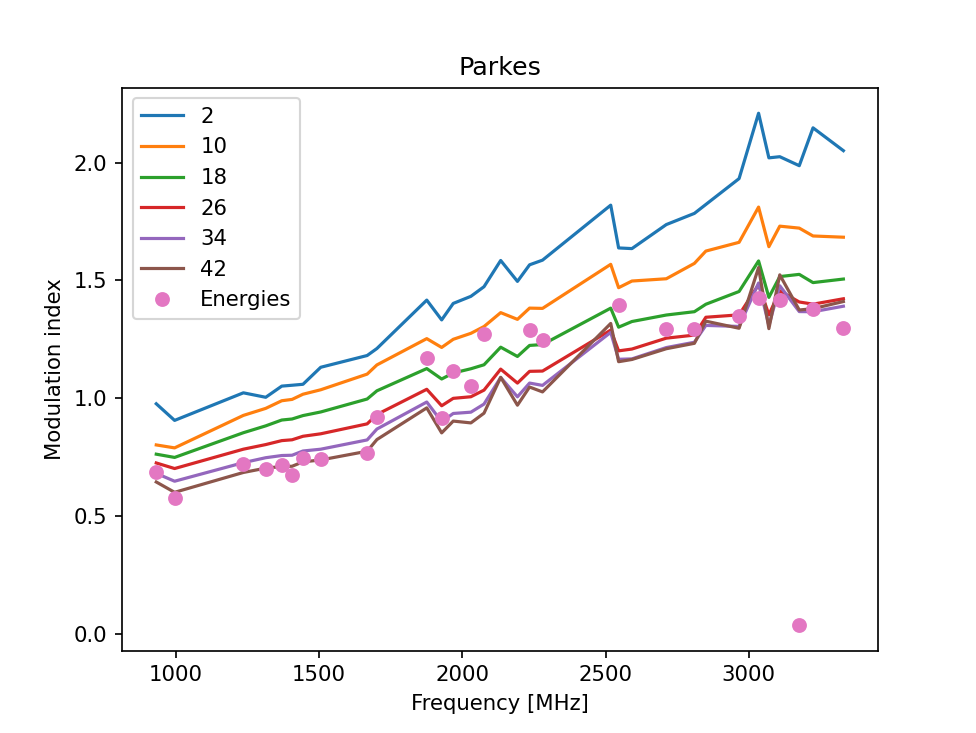

Text(0.5, 1.0, 'Parkes')

In [28]:
plt.figure()
for d in range(int(modIndex_cum.shape[1]/2)+1):
    plt.plot(Freq,modIndex_cum[:,2*d],'-',label=2*d_vec[2*d])
plt.plot(np.delete(Freq,[15,19,24]),mod_index_Energies,'o',label='Energies')
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Modulation index")
plt.title(telescope)

The frequency dependenc of modulation index was thought to be originating because the width of the profile becomes narrower at higher frequencies where as in the first analysis the energies were computed using a constant window of 40 bins. Thus in a separate analysis we compute the modulation index in a variable window depending on the width of the profile.

In [ ]:
main_mu,main_sigma=np.loadtxt("/home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/MeerKAT_SinglePulse_Gaussian_VarWidth/LogNormal_fits.txt")
C1_mu,C1_sigma=np.loadtxt("/home/akulkarn/notebooks/bibly_results_Energy_Dist_Gaussian/MeerKAT_SinglePulse_Gaussian_C1_VarWidth//LogNormal_fits.txt")

main_mod_index_Energies=[]
main_mu_energy=[]
main_std_energy=[]

for m, s in zip(main_mu,main_sigma):
    main_mu_energy_temp = quad(log_normal_mu, 0.001, np.inf, args=(m,s))
    main_mu_energy.append(main_mu_energy_temp[0])
    main_std_energy_temp = np.sqrt(quad(log_normal_std, 0.001, np.inf, args=(m,s)))
    main_std_energy.append(main_std_energy_temp[0])
    main_mod_index_Energies.append(main_std_energy_temp[0]/main_mu_energy_temp[0])

C1_mod_index_Energies=[]
C1_mu_energy=[]
C1_std_energy=[]
for m, s in zip(C1_mu,C1_sigma):
    C1_mu_energy_temp = quad(log_normal_mu, 0.001, np.inf, args=(m,s))
    C1_mu_energy.append(C1_mu_energy_temp[0])
    C1_std_energy_temp = np.sqrt(quad(log_normal_std, 0.001, np.inf, args=(m,s)))
    C1_std_energy.append(C1_std_energy_temp[0])
    C1_mod_index_Energies.append(C1_std_energy_temp[0]/C1_mu_energy_temp[0])
    

<IPython.core.display.Javascript object>


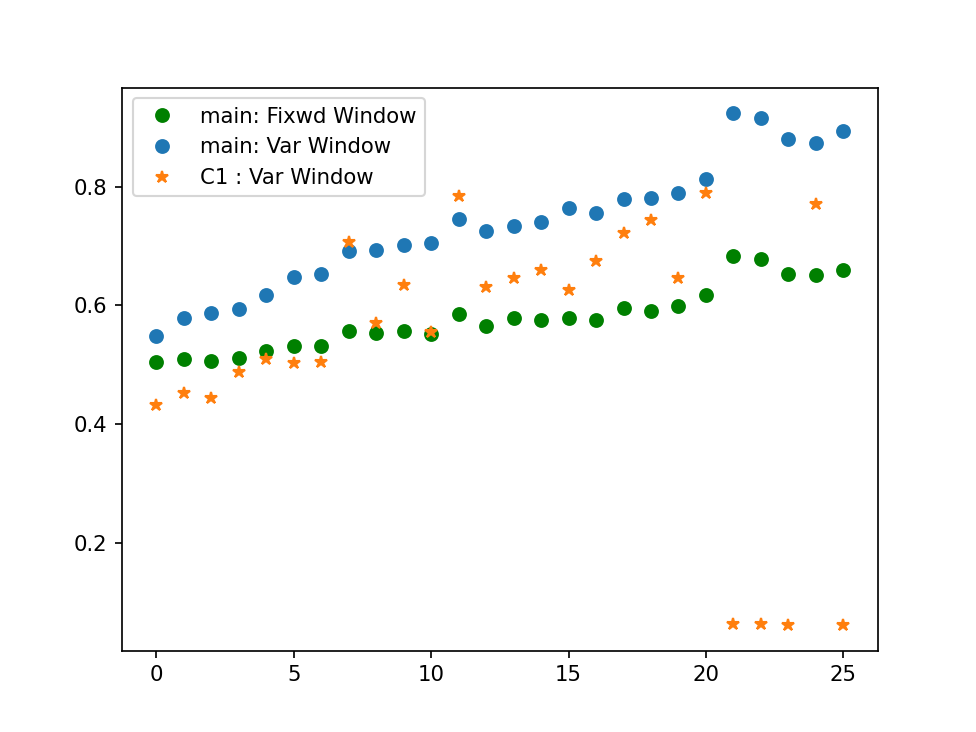

In [20]:
plt.figure()
plt.plot(np.array(mod_index_Energies),'o',color='g',label='main: Fixwd Window')
plt.plot(main_mod_index_Energies,'o',label='main: Var Window')
plt.plot(C1_mod_index_Energies,'*',label='C1 : Var Window')
#plt.ylim(0.95,1.4)
plt.legend()